<a href="https://colab.research.google.com/github/osmarbraz/sri/blob/main/2_1_AnaliseDados_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise do conjunto de dados

Gera gráficos e tabelas com distribuições de dados.

**Entrada:** `dataset.zip`, `datasetpos.zip` e `datasetner.zip`.

- Dentro do arquivo compactado `dataset.zip` está o arquivo `dataset.csv`. Cada linha de `dataset.csv` é formado por `["id","sentencas","documento"]`.
   - `"id"` é o idenficador do documento na base de dados.
  - `"sentencas"` é uma lista com as sentenças do documento.
  - `"documento"` o documento limpo, mas não segmentado.

- Dentro do arquivo compactado `datasetpos.zip` está o arquivo `datasetpos.csv`. Cada linha do arquivo `datasetpos.csv` é formado por `["id","pos_documento"]`.
  - `"id"` é o idenficador do documento no dataset.
  - `"pos_documento"` é uma lista das sentenças do documento, formado por `"tokens","pos","verbos" e "lemma"`.
    - `"tokens"` é uma lista com os tokens da sentença.
    - `"pos"` é uma lista com as postagging das palavras da sentença.
    - `"verbos"` é uma lista com os verbos da sentença.
    - `"lemma"` é uma lista com os lemmas das palavras da sentença.

- Dentro do arquivo compactado `datasetner.zip` está o arquivo `datasetnes.csv`. Cada linha do arquivo `datasetpos.csv` é formado por `["id","ner_documento"]`.
  - `"id"` é o idenficador do documento no dataset.
  - `"ner_documento"` é uma lista com as entidades reconhecidas do documento, formado por `["indice_sentenca","lista_entidades"]`.
    - `"indice_sentenca"` é o índice da sentença no documento.
    - `"lista_entidades"` é uma lista com as entidades reconhecidas na sentença formado por `["texto entidade"`,`"tipo entidade"`, `"posição inicial"` e `"posição final"]`.    


**Processamento**:
1. Copia e descompacta o arquivo "`dataset.zip`", "`datasetpos.zip`" "`datasetner.zip`" para a máquina local do
Google Colab.
2. Carrega os arquivos para gerar gráficos e tabelas com distribuições dos dados.

# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório do notebook no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================
def verificaDiretorioNotebook():
  '''
    Verifica se existe o diretório do notebook no diretório corrente.
  '''

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_NOTEBOOK):
      # Cria o diretório
      os.makedirs(DIRETORIO_NOTEBOOK)
      logging.info("Diretório do notebook criado: {}".format(DIRETORIO_NOTEBOOK))

  return DIRETORIO_NOTEBOOK

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
  '''
  Pega a tempo em segundos e retorna uma string hh:mm:ss
  '''
  # Arredonda para o segundo mais próximo.
  tempoArredondado = int(round((tempo)))

  # Formata como hh:mm:ss
  return str(datetime.timedelta(seconds=tempoArredondado))

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModelosParametros:
  max_seq_len: Optional[int] = field(
      default=None,
      metadata={"help": "max seq len"},
  )
  pretrained_model_name_or_path: str = field(
      default="neuralmind/bert-base-portuguese-cased",
      metadata={"help": "nome do modelo pré-treinado do BERT."},
  )
  modelo_spacy: str = field(
      default="pt_core_news_lg",
      metadata={"help": "nome do modelo do spaCy."},
  )
  sentenciar_documento: bool = field(
      default=True,
      metadata={"help": "Dividir o documento em sentenças(frases)."},
  )
  do_lower_case: bool = field(
      default=False,
      metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
  )
  output_attentions: bool = field(
      default=False,
      metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
  )
  output_hidden_states: bool = field(
      default=False,
      metadata={"help": "habilita gerar as camadas ocultas do modelo."},
  )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
  '''
  Retorna um dispositivo de GPU se disponível ou CPU.

  Retorno:
    `device` - Um device de GPU ou CPU.
  '''

  # Se existe GPU disponível.
  if torch.cuda.is_available():

      # Diz ao PyTorch para usar GPU.
      device = torch.device("cuda")

      logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
      logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

  # Se não.
  else:
      logging.info("Sem GPU disponível, usando CPU.")
      device = torch.device("cpu")

  return device

In [ ]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
  '''
  Conecta um modelo BERT a GPU.

  Parâmetros:
    `model` - Um modelo BERT carregado.
    `device` - Um device de GPU.

  Retorno:
    `model` - Um objeto model BERT conectado a GPU.
  '''
  # Associa a GPU ao modelo.
  model.to(device)

  # Se existe GPU disponível.
  if torch.cuda.is_available():
      # Diga ao pytorch para rodar este modelo na GPU.
      logging.info("Pytorch rodando o modelo na GPU.")
      model.cuda()

  else:
      logging.info("Pytorch rodando sem GPU.")

  return model

Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # import necessário
  from google.colab import drive

  # Monta o drive na pasta especificada
  drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.7 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [ ]:
# Instala dependências do spacy
!pip install -U pip==25.1.1 setuptools==80.9.0 wheel==0.45.1

In [ ]:
# Instala uma versão específica
!pip install -U spacy==3.8.7

## 1.8 Instalação do BERT

Instala a interface pytorch para o BERT by Hugging Face.

https://huggingface.co/docs/transformers/installation



In [ ]:
!pip install -U transformers==4.49.0

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModelosParametros(
  max_seq_len = 512,

  #pretrained_model_name_or_path = "bert-large-cased",
  #pretrained_model_name_or_path = "bert-base-cased"
  #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
  pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",
  #pretrained_model_name_or_path = "bert-base-multilingual-cased",
  #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

  #modelo_spacy = "en_core_web_lg",
  #modelo_spacy = "en_core_web_md",
  #modelo_spacy = "en_core_web_sm",
  modelo_spacy = "pt_core_news_lg",
  #modelo_spacy = "pt_core_news_md",
  #modelo_spacy = "pt_core_news_sm",

  do_lower_case = False,   # default True
  output_attentions = False,  # default False
  output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do notebook
DIRETORIO_NOTEBOOK = "SRI"

## Define o caminho para os arquivos de dados

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Diretório local para os arquivos de dados
  DIRETORIO_LOCAL = "/content/" + DIRETORIO_NOTEBOOK + "/"

  # Diretório no google drive com os arquivos de dados
  DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/" + DIRETORIO_NOTEBOOK + "/data/"
else:

  # Diretório local para os arquivos de dados
  DIRETORIO_LOCAL = "./data/"

  # Diretório no google drive com os arquivos de dados
  DIRETORIO_DRIVE = "./data/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 14
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do documento default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 spaCy

## 3.1 Download arquivo modelo

Uso:
https://spacy.io/usage

Modelos:
https://spacy.io/models

In [ ]:
!python -m spacy download $model_args.modelo_spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 29.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 3.2 Carrega o modelo

In [ ]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

nlp = spacy.load(model_args.modelo_spacy)

## 3.3 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [ ]:
def getStopwords(nlp):
  '''
  Recupera as stop words do nlp(Spacy).

  Parâmetros:
    `nlp` - Um modelo spaCy carregado.
  '''

  spacy_stopwords = nlp.Defaults.stop_words

  return spacy_stopwords

Lista dos stopwords

In [ ]:
print("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

Quantidade de stopwords: 416.
{'nunca', 'vai', 'que', 'um', 'neste', 'inicio', 'valor', 'faz', 'seus', 'as', 'vão', 'pôde', 'fostes', 'quem', 'oitava', 'conhecida', 'na', 'teu', 'sistema', 'ontem', 'puderam', 'quinta', 'estão', 'vens', 'iniciar', 'tuas', 'porquê', 'estou', 'nove', 'era', 'entre', 'eu', 'me', 'tivestes', 'pontos', 'somente', 'onze', 'menos', 'mal', 'estes', 'relação', 'perto', 'tentaram', 'sexto', 'adeus', 'forma', 'vem', 'momento', 'oito', 'nessa', 'vez', 'algumas', 'vais', 'des', 'dez', 'sete', 'bom', 'números', 'depois', 'menor', 'quero', 'duas', 'três', 'vocês', 'ora', 'ainda', 'parte', 'mês', 'ponto', 'obrigado', 'quando', 'segundo', 'alguns', 'dois', 'estivestes', 'vós', 'de', 'meses', 'sei', 'cujo', 'desse', 'tentar', 'do', 'nosso', 'nível', 'muitos', 'tipo', 'terceiro', 'te', 'estive', 'todo', 'for', 'primeira', 'agora', 'direita', 'estava', 'posição', 'tais', 'tente', 'cima', 'tiveste', 'foi', 'corrente', 'maior', 'lhe', 'pode', 'bem', 'faço', 'fui', 'aí', 'cuj

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [ ]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [ ]:
def getDicPOSQtde(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novo_dic = dict()

  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

In [ ]:
def getDicTodasPOSQtde(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novo_dic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}

  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [ ]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getDicTodasNERQtde

Conta as NER de uma sentença

In [ ]:
def getDicTodasNERQtde(lista):

  # Dicionário com as classes de entidade e quantidades
  conjunto = {"LOC":0, "MISC":0, "ORG":0, "PER":0}

  for x in lista:
    valor = conjunto.get(x[1])
    if valor != None:
      conjunto[x[1]] = valor + 1
    else:
      conjunto[x[1]] = 1

  return conjunto

### getSomaDicx

Soma os valores de dicionários com as mesmas chaves.

In [ ]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):

  # Soma os dicionários da lista
  novo_dic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))

  return novo_dic

# 4 BERT

## 4.1 Modelo Pré-treinado BERT

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [ ]:
# Import das bibliotecas
from transformers import BertModel

# Carrega o modelo
model = BertModel.from_pretrained(model_args.pretrained_model_name_or_path,
                                  output_attentions=model_args.output_attentions,
                                  output_hidden_states=model_args.output_hidden_states)

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

## 4.2 Tokenizador BERT

O tokenizador utiliza WordPiece, veja em [artigo original](https://arxiv.org/pdf/1609.08144.pdf).

In [ ]:
# Import das bibliotecas
from transformers import BertTokenizer

# Carrega o tokenizador
#tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path)

tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path,
                                          do_lower_case=model_args.do_lower_case)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## 4.3 Funções Auxiliares

### getNomeModeloBERT

In [ ]:
def getNomeModeloBERT(model_args):
    '''
    Recupera uma string com uma descrição do modelo BERT para nomes de arquivos e diretórios.

    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.

    Retorno:
    `MODELO_BERT` - Nome do modelo BERT.
    '''

    # Verifica o nome do modelo(default SEM_MODELO_BERT)
    MODELO_BERT = "SEM_MODELO_BERT"

    if 'neuralmind' in model_args.pretrained_model_name_or_path:
        MODELO_BERT = "_BERTimbau"

    else:
        if 'multilingual' in model_args.pretrained_model_name_or_path:
            MODELO_BERT = "_BERTmultilingual"

    return MODELO_BERT

### getTamanhoBERT

In [ ]:
def getTamanhoBERT(model_args):
    '''
    Recupera uma string com o tamanho(dimensão) do modelo BERT para nomes de arquivos e diretórios.

    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.

    Retorno:
    `TAMANHO_BERT` - Nome do tamanho do modelo BERT.
    '''

    # Verifica o tamanho do modelo(default large)
    TAMANHO_BERT = "_large"

    if 'base' in model_args.pretrained_model_name_or_path:
        TAMANHO_BERT = "_base"

    return TAMANHO_BERT

### Recupera detalhes do BERT

In [ ]:
# Verifica o nome do modelo BERT a ser utilizado
MODELO_BERT = getNomeModeloBERT(model_args)

# Verifica o tamanho do modelo(default large)
TAMANHO_BERT = getTamanhoBERT(model_args)

### getPalavrasDesconhecidasBERT

In [ ]:
def getPalavrasDesconhecidasBERT(sentenca_token):
  '''
    Conta o número de palavras desconhecidas na sentença tokenizada pelo BERT.

    Parâmetros:
    `sentenca_token` - Lista de tokens da sentença gerado pelo BERT.

    Retorno:
    `lista_palavras_desconhecidas` - Lista com as palavras desconhecidas.
  '''
  proximo = False
  achei = False
  token_palavra = ""
  token_bert = []
  lista_palavras_desconhecidas = []

  for k, token in enumerate(sentenca_token):
      # Sem ##
      if "##" not in token:
        token_palavra = token
        token_bert = []
        token_bert.append(token)

      # Verifica se é um token desconhecido
      if "##" in token:
        achei = True
        # Guarda o token
        token_palavra = token_palavra + token[2:]
        token_bert.append(token)
        # Se o próximo é continuação do token
        if k+1 < len(sentenca_token):
          if "##" in sentenca_token[k+1]:
            proximo = True
          else:
            proximo = False
        else:
            proximo = False

      # Se terminei o token guarda a palavra
      if achei == True and proximo == False:
          achei = False
          lista_palavras_desconhecidas.append([token_palavra, token_bert])
          token_palavra = ""
          token_bert = []

  return lista_palavras_desconhecidas

# 5 Estatísticas Dataset

## 5.1 Carregamento do Dataset, PoS-Tagging e NER

### 5.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_DATASET = "dataset.csv"
NOME_ARQUIVO_DATASET_COMPACTADO = "dataset.zip"
NOME_ARQUIVO_DATASET_POS = "datasetpos.csv"
NOME_ARQUIVO_DATASET_POS_COMPACTADO = "datasetpos.zip"
NOME_ARQUIVO_DATASET_NER = "datasetner.csv"
NOME_ARQUIVO_DATASET_NER_COMPACTADO = "datasetner.zip"

### 5.1.2 Cria o diretório local para receber os dados

In [ ]:
# Importando as bibliotecas.
import os

# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Cria o diretório para receber os arquivos Originais e Permutados
  # Diretório a ser criado
  dirbase = DIRETORIO_LOCAL[:-1]

  if not os.path.exists(dirbase):
      # Cria o diretório
      os.makedirs(dirbase)
      logging.info("Diretório criado: {}".format(dirbase))
  else:
      logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/SRI


### 5.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_POS_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_DATASET_NER_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia.")

INFO:root:Terminei a cópia.


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_DATASET_NER_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação.")

INFO:root:Terminei a descompactação.


### 5.1.4 Carregamento das lista com os dados dos arquivos e postagging

#### Carrega o arquivo dos dados e POS

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Abre o arquivo e retorna o DataFrame
df_dataset = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET, sep=";", encoding="UTF-8")
df_dataset_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET_POS, sep=";", encoding="UTF-8")
df_dataset_ner = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_DATASET_NER, sep=";", encoding="UTF-8")

logging.info("TERMINADO DOCUMENTOS: {}.".format(len(df_dataset)))
logging.info("TERMINADO DOCUMENTOS POS: {}.".format(len(df_dataset_pos)))
logging.info("TERMINADO DOCUMENTOS NER: {}.".format(len(df_dataset_ner)))

INFO:root:TERMINADO DOCUMENTOS: 20.
INFO:root:TERMINADO DOCUMENTOS POS: 20.
INFO:root:TERMINADO DOCUMENTOS NER: 20.


In [ ]:
df_dataset.sample(5)

,id,sentencas,documento
6,7,['A aviação israelense atacou 150 alvos na mad...,A aviação israelense atacou 150 alvos na madru...
16,17,['O time de Bernardinho derrotou a Rússia por ...,O time de Bernardinho derrotou a Rússia por 3 ...
0,1,"['Depois de 20 dias de tempo seco, voltou a ch...","Depois de 20 dias de tempo seco, voltou a chov..."
14,15,['Quase metade dos vôos previstos para decolar...,Quase metade dos vôos previstos para decolar n...
3,4,['Usando telescópios do Observatório Europeu S...,Usando telescópios do Observatório Europeu Sul...


In [ ]:
df_dataset_pos.sample(5)

,id,pos_documento
3,4,"[[['Usando', 'telescópios', 'do', 'Observatóri..."
13,14,"[[['A', 'pista', 'principal', 'do', 'Aeroporto..."
10,11,"[[['Nove', 'pessoas', 'morreram', ',', 'sendo'..."
14,15,"[[['Quase', 'metade', 'dos', 'vôos', 'previsto..."
17,18,"[[['O', 'Itaú', ',', 'segundo', 'maior', 'banc..."


In [ ]:
df_dataset_ner.sample(5)

,id,ner_documento
15,16,"[[0, [['Brasil', 'LOC', 2, 8], ['Colômbia', 'L..."
9,10,"[[0, [['Ação Contra a Fome', 'MISC', 36, 54], ..."
4,5,"[[0, [['Bernardinho', 'PER', 60, 71], ['Finlân..."
3,4,"[[0, [['Observatório Europeu Sul', 'LOC', 22, ..."
17,18,"[[0, [['Itaú', 'ORG', 2, 6], ['País', 'LOC', 3..."


#### Corrigir os tipos de colunas dos dados, POS e NER

Em lista documento:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em lista pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

Em lista ner:
- coluna 1 - `ner_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
df_dataset["sentencas"] = df_dataset["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
df_dataset_pos["pos_documento"] = df_dataset_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
df_dataset_ner["ner_documento"] = df_dataset_ner["ner_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO DOCUMENTOS: {}.".format(len(df_dataset)))
logging.info("TERMINADO CORREÇÃO DOCUMENTOS POS: {}.".format(len(df_dataset_pos)))
logging.info("TERMINADO CORREÇÃO DOCUMENTOS NER: {}.".format(len(df_dataset_ner)))

INFO:root:TERMINADO CORREÇÃO DOCUMENTOS: 20.
INFO:root:TERMINADO CORREÇÃO DOCUMENTOS POS: 20.
INFO:root:TERMINADO CORREÇÃO DOCUMENTOS NER: 20.


#### Criando dados indexados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_indexado = df_dataset.set_index(["id"])
df_dataset_indexado.head()

,sentencas,documento
id,,
1,"[Depois de 20 dias de tempo seco, voltou a cho...","Depois de 20 dias de tempo seco, voltou a chov..."
2,[Ao menos 17 pessoas morreram após a queda de ...,Ao menos 17 pessoas morreram após a queda de u...
3,"[O ministro da Defesa, Nelson Jobim, informou ...","O ministro da Defesa, Nelson Jobim, informou n..."
4,[Usando telescópios do Observatório Europeu Su...,Usando telescópios do Observatório Europeu Sul...
5,"[A seleção brasileira masculina de vôlei, que ...","A seleção brasileira masculina de vôlei, que é..."


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_pos_indexado = df_dataset_pos.set_index(["id"])
df_dataset_pos_indexado.head()

,pos_documento
id,
1,"[[[Depois, de, 20, dias, de, tempo, seco, ,, v..."
2,"[[[Ao, menos, 17, pessoas, morreram, após, a, ..."
3,"[[[O, ministro, da, Defesa, ,, Nelson, Jobim, ..."
4,"[[[Usando, telescópios, do, Observatório, Euro..."
5,"[[[A, seleção, brasileira, masculina, de, vôle..."


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
df_dataset_ner_indexado = df_dataset_ner.set_index(["id"])
df_dataset_ner_indexado.head()

,ner_documento
id,
1,"[[0, []], [1, [['São Paulo', 'LOC', 17, 26], [..."
2,"[[0, [['República Democrática do Congo', 'LOC'..."
3,"[[0, [['Nelson Jobim', 'PER', 22, 34], ['Solan..."
4,"[[0, [['Observatório Europeu Sul', 'LOC', 22, ..."
5,"[[0, [['Bernardinho', 'PER', 60, 71], ['Finlân..."


## 5.2 Estatísticas

### 5.2.1 Processamento estatísticas



In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documentos = []
stats_documentos_pos = []
stats_documentos_ner = []
stats_documentos_dic_pos = []
stats_documentos_dic_ner =[]
stats_sentencas = []
stats_sentencas_dic_pos = []
stats_sentencas_dic_ner = []

# Dicionário de ocorrência de palavras
dicionario_palavras = {}
# Lista de palavras desconhecidas
lista_palavras_desconhecidas_geral = []
# Lista do documento tokenizado
documento_tokenizado = []

# Declaração e inicialização de contadores do conjunto de dados
total_sentencas_geral = 0
total_palavras_geral = 0
total_palavras_sem_stopwords_geral = 0
total_tokens_geral = 0
total_entidades_geral = 0
total_abaixo_512_geral = 0
total_2_ou_mais_locucoes_verbais = 0
total_sentencas_com_uma_palavra_geral = 0
total_verbos_documento_geral = 0
total_verbos_aux_documento_geral = 0
total_substantivo_documento_geral = 0
total_verbos_aux_substantivo_documento_geral = 0

print("Processando",len(df_dataset),"documentos")

# Barra de progresso dos documentos
df_dataset_bar = tqdm_notebook(df_dataset.iterrows(), desc=f"Documentos", unit=f" documento", total=len(df_dataset))

# Percorre os documentos do conjunto de dados
for i, linha_documento in df_dataset_bar:
    # Recupera o id do documento
    id_documento = linha_documento["id"]
    #print("id_documento:",id_documento)

    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento["sentencas"]
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento))

    # Localiza e carrega a lista das POSTagging das sentenças do documento de acordo com o tipo armazenado
    # Considera somente a posição 1 com as sentenças
    lista_pos_documento = df_dataset_pos.iloc[i][1]
    #print("lista_pos_documento:",lista_pos_documento)
    #print("len(lista_pos_documento):",len(lista_pos_documento))

    # Localiza e carrega a lista das NER das sentenças do documento de acordo com o tipo armazenado
    # Descarta a posição 0 com o id do documento e considera somente a posição 1 com as entidades
    lista_ner_documento = df_dataset_ner.iloc[i][1]
    # print("lista_ner_documento:",lista_ner_documento)
    # print("len(lista_ner_documento):",len(lista_ner_documento))

    # Calcula o total de sentenças do documento
    total_sentencas_geral = total_sentencas_geral + len(lista_sentenca_documento)

    # Inicialização contadores de documento
    total_palavras_documento = 0
    total_palavras_sem_stopword_documento = 0
    total_tokens_BERT_documento = 0
    total_locucoes_verbais_documento = 0
    total_entidades_documento = 0
    total_verbos_documento = 0
    total_verbos_aux_documento = 0
    total_substantivo_documento = 0
    total_verbos_aux_substantivo_documento = 0

    lista_palavras_desconhecidas_documento = []

    # Acumula os dicionários de POS das sentenças
    lista_dic_pos_doc  = []

    # Acumula os dicionários de NER das sentenças
    lista_dic_ner_doc  = []

    # Acumula a lista de NER das sentenças
    stats_sentencas_ner =[]

    # Acumula a lista de  POS das sentenças
    stats_sentencas_pos = []

    # Guarda as sentenças tokenizadas pelo BERT do documento
    documento_tokenizado_sentenca = []

    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):

      #print("sentenca:",sentenca)

      # Recupera a lista dos tokens, PoS-Tagging, Verbos e entidades da sentença
      sentenca_token = lista_pos_documento[j][0]
      #print("sentenca_token:",sentenca_token)
      #print("len(sentenca_token):",len(sentenca_token))
      sentenca_pos = lista_pos_documento[j][1]
      #print("sentenca_pos:",sentenca_pos)
      sentenca_verbos = lista_pos_documento[j][2]
      #print("sentenca_verbos:",sentenca_verbos)
      # Recupera a lista das NER da sentença
      sentenca_ner = lista_ner_documento[j][1]
      # print("sentenca_ner:",sentenca_ner)

      ######### Estatístidas das Entidades Nomeadas
      # Guarda as entidades da sentença
      entidade_sentenca_ner = []

      qtde_ner_sentenca = 0

      # Percorre as entidades da sentença
      for k, entidade in enumerate(sentenca_ner):
        #print(entidade[0], entidade[1])
        # Gera lista das NER da sentença
        entidade_sentenca_ner.append([linha_documento[0], j, entidade[0], entidade[1]])
        # Conta o total de entidades do documento
        qtde_ner_sentenca = qtde_ner_sentenca + 1

      # Guarda as entidades da sentença
      stats_sentencas_ner = stats_sentencas_ner + entidade_sentenca_ner

      # Gera as estatísticas de NER da sentença
      contaNERSentenca = getDicTodasNERQtde(sentenca_ner)

      # Registra as estatísticas de entidades da sentença
      stats_sentencas_dic_ner.append([linha_documento[0], j, contaNERSentenca])

      # Acumula o dicionário de ner da sentença ao documento
      lista_dic_ner_doc .append(contaNERSentenca)

      ######### Estatísticas das palavras e PoS
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Conta sentenças com uma palavra
      if qtdePalavra == 1:
        total_sentencas_com_uma_palavra_geral = total_sentencas_com_uma_palavra_geral + 1
        print("sentenca_token:",sentenca_token)
        print(linha_documento)

      # Retorna uma lista com os verbos da sentença
      qtde_locucoes_verbais_sentenca = len(sentenca_verbos)
      total_locucoes_verbais_documento = total_locucoes_verbais_documento + qtde_locucoes_verbais_sentenca

      if qtde_locucoes_verbais_sentenca >= 2:
          total_2_ou_mais_locucoes_verbais = total_2_ou_mais_locucoes_verbais + 1

      # Retorna os tokens da sentença sem as stopwords
      sentencaSemStopWords = getSentencaSemStopWord(sentenca_token, getStopwords(nlp))

      # Quantidade de tokens por Sentença sem as stopwords
      qtde_palavra_sem_stopword = len(sentencaSemStopWords)

      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      # Acumula a quantidade de palavras da Sentença sem stopwords
      total_palavras_sem_stopword_documento = total_palavras_sem_stopword_documento + qtde_palavra_sem_stopword

      # Divide a Sentença em tokens do BERT
      sentenca_tokenizada = tokenizer.tokenize(sentenca)

      # Guarda a sentença tokenizada do documento
      documento_tokenizado_sentenca = documento_tokenizado_sentenca + sentenca_tokenizada

      # Quantidade de tokens por Sentença
      qtde_token_BERT = len(sentenca_tokenizada)

      # Recupera as palavras desconhecidas pelo BERT (com ##)
      lista_palavras_desconhecidas_sentenca = getPalavrasDesconhecidasBERT(sentenca_tokenizada)

      # Acumula a quantidade de tokens da Sentença
      total_tokens_BERT_documento = total_tokens_BERT_documento + qtde_token_BERT

      # Guarda as postagging das palavras da sentença
      palavra_sentenca_pos = []

      qtde_verbo_sentenca = 0
      qtde_verbo_aux_sentenca = 0
      qtde_substantivo_sentenca = 0
      qtde_verbo_aux_substantivo_sentenca = 0

      # Percorre as palavras da sentença
      for k, palavra in enumerate(sentenca_token):
        # Gera lista das POS Tagging  das palavras da sentença
        palavra_sentenca_pos.append([linha_documento[0], j, palavra, sentenca_pos[k]])

        # Atualiza o dicionário das palavras da sentença
        valor = dicionario_palavras.get(palavra)
        if valor != None:
            dicionario_palavras[palavra] = valor + 1
        else:
            dicionario_palavras[palavra] = 1

        # Avalia o tipo PoS das palavras da sentença
        if sentenca_pos[k] in ["VERB"]:
            qtde_verbo_sentenca = qtde_verbo_sentenca  + 1
        if sentenca_pos[k] in ["VERB","AUX"]:
            qtde_verbo_aux_sentenca = qtde_verbo_aux_sentenca  + 1
        if sentenca_pos[k] in ["NOUN"]:
            qtde_substantivo_sentenca = qtde_substantivo_sentenca + 1
        if sentenca_pos[k] in ["VERB","NOUN","AUX"]:
            qtde_verbo_aux_substantivo_sentenca = qtde_verbo_aux_substantivo_sentenca  + 1

      # Registra as estatística da Sentença
      stats_sentencas.append(
         {
            "id": id_documento,
            "sentenca": j,
            "qtdepalavras" : qtdePalavra,
            "qtdetokensbert" : qtde_token_BERT,
            "qtdepalavrassemstopword" : qtde_palavra_sem_stopword,
            "qtdelocverbo" : qtde_locucoes_verbais_sentenca ,
            "qtdeverbo" : qtde_verbo_sentenca ,
            "qtdeverboaux" : qtde_verbo_aux_sentenca,
            "qtdesubstantivo" : qtde_substantivo_sentenca,
            "qtdeverboauxsubstantivo" : qtde_verbo_aux_substantivo_sentenca,
            "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_sentenca),
            "qtdener" : qtde_ner_sentenca,
         }
      )

      # Acumula os totais do documento
      total_verbos_documento = total_verbos_documento + qtde_verbo_sentenca
      total_entidades_documento = total_entidades_documento + qtde_ner_sentenca
      total_verbos_aux_documento = total_verbos_aux_documento + qtde_verbo_aux_sentenca
      total_substantivo_documento = total_substantivo_documento + qtde_substantivo_sentenca
      total_verbos_aux_substantivo_documento = total_verbos_aux_substantivo_documento + qtde_verbo_aux_substantivo_sentenca
      lista_palavras_desconhecidas_documento = lista_palavras_desconhecidas_documento + lista_palavras_desconhecidas_sentenca

      # Guarda as PoS-tagging da sentença
      stats_sentencas_pos = stats_sentencas_pos + palavra_sentenca_pos

      # Gera as estatísticas de POS Tagging da sentença
      contaPosSentenca = getDicTodasPOSQtde(sentenca_pos)

      # Registra as estatísticas de POS Tagging das sentenças
      stats_sentencas_dic_pos.append([linha_documento[0], j, contaPosSentenca])

      # Acumula o dicionário de pos da sentença
      lista_dic_pos_doc .append(contaPosSentenca)

    # Final da estrutura de repetição das sentenças

    # Guarda as sentenças do documento tokenizada
    documento_tokenizado.append(documento_tokenizado_sentenca)

    # Guarda o total de entidades do conjunto de dados
    total_entidades_geral =  total_entidades_geral + total_entidades_documento

    # Acumula a estatisticas ner das sentenças do documento
    stats_documentos_ner = stats_documentos_ner + stats_sentencas_ner

    # Acumula a estatisticas postagging das sentenças do documento
    stats_documentos_pos = stats_documentos_pos + stats_sentencas_pos

    # Guarda o total de palavras do conjunto de dados
    total_palavras_geral = total_palavras_geral + total_palavras_documento

    # Guarda o total de palavras do conjunto de dados
    total_palavras_sem_stopwords_geral = total_palavras_sem_stopwords_geral + total_palavras_sem_stopword_documento

    # Guarda o total de tokens do conjunto de dados
    total_tokens_geral = total_tokens_geral + total_tokens_BERT_documento

    # Guarda a lista de palavras desconhecidas
    lista_palavras_desconhecidas_geral = lista_palavras_desconhecidas_geral + lista_palavras_desconhecidas_documento

    # Conta se forem menor que 512 tokens
    if total_tokens_BERT_documento < model_args.max_seq_len :
        total_abaixo_512_geral = total_abaixo_512_geral + 1

    # Verifica o total de verbos
    if total_verbos_documento != 0:
      total_verbos_documento_geral = total_verbos_documento_geral + 1
    if total_verbos_aux_documento != 0:
      total_verbos_aux_documento_geral = total_verbos_aux_documento_geral + 1
    if total_substantivo_documento != 0:
      total_substantivo_documento_geral = total_substantivo_documento_geral + 1
    if total_verbos_aux_substantivo_documento != 0:
      total_verbos_aux_substantivo_documento_geral = total_verbos_aux_substantivo_documento_geral + 1

    # Registra as estatística do documento
    stats_documentos.append(
      {
        "id": id_documento,
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,
        "qtdetokensbert" : total_tokens_BERT_documento,
        "qtdepalavrassemstopword" : total_palavras_sem_stopword_documento,
        "qtdelocverbo" : total_locucoes_verbais_documento,
        "qtdeverbo" : total_verbos_documento,
        "qtdeverboaux" : total_verbos_aux_documento,
        "qtdesubstantivo" : total_substantivo_documento,
        "qtdeverboauxsubstantivo" : total_verbos_aux_substantivo_documento,
        "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_documento),
        "qtdener" : total_entidades_documento,
      }
    )

    # Registra as estatísticas de POS Tagging dos documentos
    stats_documentos_dic_pos.append([linha_documento[0], lista_dic_pos_doc ])

    # Registra as estatísticas de NER dos documentos
    stats_documentos_dic_ner.append([linha_documento[0], lista_dic_ner_doc ])

print("Total de Sentenças                             :", total_sentencas_geral)
print("Total de Sentenças com uma palavra             :", total_sentencas_com_uma_palavra_geral)
print("Total de palavras                              :", total_palavras_geral)
print("Total de palavras distintas                    :", len(dicionario_palavras))
print("Total de palavras sem stopwords                :", total_palavras_sem_stopwords_geral)
print("Total de tokens BERT                           :", total_tokens_geral)
print("Total de documentos abaixo 512                 :", total_abaixo_512_geral)
print("Total de entidades reconhecidas                :", total_entidades_geral)
print("Total de palavras desconhecidas repetidas      :", len(lista_palavras_desconhecidas_geral))
print("Total de palavras desconhecidas sem repetições :", len(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral]))))
print("Total de sentenças com 2 ou mais loc verbos    :", total_2_ou_mais_locucoes_verbais, "sendo {:.2%} do total de sentenças".format(total_2_ou_mais_locucoes_verbais/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB)            :", total_verbos_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_documento_geral/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB e AUX)      :", total_verbos_aux_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_documento_geral/total_sentencas_geral))
print("Total de sentenças com substantivos(NOUN)      :", total_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_substantivo_documento_geral/total_sentencas_geral))
print("Total de sentenças com VERB, AUX e NOUN        :", total_verbos_aux_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_substantivo_documento_geral/total_sentencas_geral))

Processando 20 documentos


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

Total de Sentenças                             : 100
Total de Sentenças com uma palavra             : 0
Total de palavras                              : 2708
Total de palavras distintas                    : 1114
Total de palavras sem stopwords                : 1611
Total de tokens BERT                           : 3234
Total de documentos abaixo 512                 : 20
Total de entidades reconhecidas                : 176
Total de palavras desconhecidas repetidas      : 305
Total de palavras desconhecidas sem repetições : 263
Total de sentenças com 2 ou mais loc verbos    : 67 sendo 67.00% do total de sentenças
Total de sentenças com Verbos(VERB)            : 20 sendo 20.00% do total de sentenças
Total de sentenças com Verbos(VERB e AUX)      : 20 sendo 20.00% do total de sentenças
Total de sentenças com substantivos(NOUN)      : 20 sendo 20.00% do total de sentenças
Total de sentenças com VERB, AUX e NOUN        : 20 sendo 20.00% do total de sentenças


/tmp/ipython-input-50-1295529346.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lista_pos_documento = df_dataset_pos.iloc[i][1]
/tmp/ipython-input-50-1295529346.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lista_ner_documento = df_dataset_ner.iloc[i][1]
/tmp/ipython-input-50-1295529346.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats_sentencas_dic_ner.append([linha_documento[0], j, contaNERSentenca])
/tmp/ip

Converte a lista das pos tagging das palavras em um dataframe

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_documentos_pos = pd.DataFrame(stats_documentos_pos, columns=("id", "sentenca", "palavra", "pos"))

In [ ]:
dfstats_documentos_pos.sample(5)

,id,sentenca,palavra,pos
193,2,2,.,PUNCT
813,7,1,200,NUM
646,6,1,prevaricação,NOUN
2654,20,6,pelo,ADP
1656,13,0,argentino,NOUN


Converte a lista das entidades das palavras em um dataframe

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_documentos_ner = pd.DataFrame(stats_documentos_ner, columns=("id", "sentenca", "entidade", "classe"))

In [ ]:
dfstats_documentos_ner.sample(5)

,id,sentenca,entidade,classe
62,7,2,Líbano,LOC
20,3,1,Secretaria de Previdência Complementar,MISC
94,10,1,Tigres de Libertação da Pátria Tâmil,ORG
124,15,2,Infraero,ORG
119,15,0,Zona Sul de São Paulo,LOC


### 5.2.2 Conjunto de dados



In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_documentos_pos.groupby(by=["pos"])['palavra']

# Mostra as estatísticas
lista.describe(include="all").transpose()

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
count,149,533,64,59,63,217,571,123,52,281,349,27,3,216,1
unique,122,50,32,21,4,29,403,75,17,200,8,11,1,167,1
top,nova,de,não,foram,e,o,pessoas,dois,que,Paulo,",",que,R$,informou,finale
freq,4,139,7,10,55,44,11,5,28,9,193,8,3,6,1


In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_documentos_ner.groupby(by=["classe"])['entidade']

# Mostra as estatísticas
lista.describe(include="all").transpose()

classe,LOC,MISC,ORG,PER
count,93,13,43,27
unique,71,12,36,22
top,Brasil,Operação Dominó,Infraero,Kaká
freq,6,2,3,3


### 5.2.3 Por documento

#### 5.2.3.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_documentos = pd.DataFrame(data=stats_documentos)

dfstats_documentos.describe(include="all")

,id,qtdesentencas,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo,qtdepalavrasdesconhecidas,qtdener
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,10.50,5.00,135.40,161.70,80.55,10.65,10.80,13.75,28.55,42.30,15.25,8.80
std,5.92,2.41,48.71,54.41,28.38,5.06,4.81,6.10,12.24,17.22,6.92,3.86
min,1.00,2.00,51.00,62.00,31.00,3.00,3.00,5.00,10.00,15.00,4.00,1.00
25%,5.75,3.75,104.00,127.75,63.75,7.00,7.00,10.00,18.50,30.75,10.00,6.75
50%,10.50,4.00,140.50,172.50,85.00,10.00,11.00,13.00,26.50,39.00,16.00,9.00
75%,15.25,5.25,160.25,192.25,98.75,12.25,12.00,15.00,35.50,51.75,19.00,11.00
max,20.00,10.00,236.00,258.00,135.00,25.00,24.00,28.00,57.00,81.00,30.00,17.00


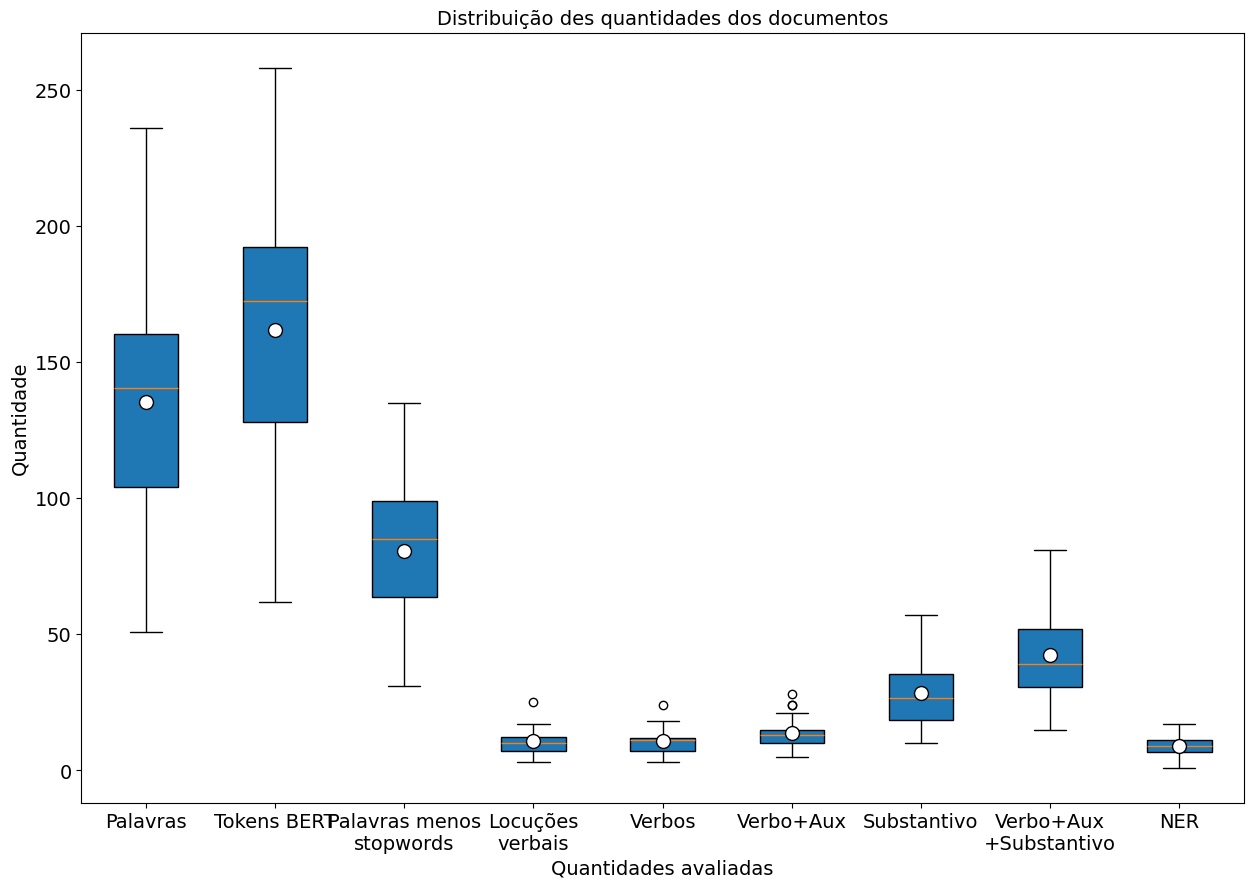

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades dos documentos")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_documentos],
           [x["qtdetokensbert"] for x in stats_documentos],
           [x["qtdepalavrassemstopword"] for x in stats_documentos],
           [x["qtdelocverbo"] for x in stats_documentos],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverboauxsubstantivo"] for x in stats_documentos],
           [x["qtdener"] for x in stats_documentos],
           ]

# Estrutura do gráfico
bplot1 = ax.boxplot(colunas, patch_artist=True,
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
rotulos = ["Palavras",
           "Tokens BERT",
           "Palavras menos\nstopwords",
           "Locuções\nverbais",
           "Verbos",
           "Verbo+Aux",
           "Substantivo",
           "Verbo+Aux\n+Substantivo",
           "NER"]
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, rotulos)

# Mostra o gráfico
plt.show()

#### 5.2.3.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_documentos_dic_pos = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_dic_pos])

# Exibe as estatísticas
dfstats_documentos_dic_pos.describe(include="all")

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.0,20.0,1.0
mean,2.60,10.80,17.45,10.85,28.55,2.95,3.15,26.65,14.05,7.45,3.20,6.15,1.35,0.15,0.0,0.0,1.0
std,2.06,4.81,7.58,5.77,12.24,2.14,2.06,9.55,6.67,4.20,2.07,3.90,1.50,0.49,0.0,0.0,NaN
min,0.00,3.00,6.00,3.00,10.00,0.00,0.00,9.00,2.00,2.00,1.00,2.00,0.00,0.00,0.0,0.0,1.0
25%,1.00,7.00,12.00,7.00,18.50,1.75,2.00,19.00,8.75,4.00,2.00,3.00,0.00,0.00,0.0,0.0,1.0
50%,2.00,11.00,17.00,10.00,26.50,3.00,3.00,27.00,15.50,6.50,2.50,5.00,1.00,0.00,0.0,0.0,1.0
75%,3.25,12.00,21.50,13.00,35.50,4.00,4.00,32.75,18.25,10.25,4.25,7.25,2.25,0.00,0.0,0.0,1.0
max,7.00,24.00,33.00,26.00,57.00,8.00,8.00,46.00,26.00,16.00,8.00,17.00,4.00,2.00,0.0,0.0,1.0


Organiza os dados para gerar o boxplot

In [ ]:
# Converte os dados para o boxplot
lista_dic_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_documentos_dic_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])
    for chave, valor in posx.items():
        lista_dic_postagging.append([x[0], chave, valor])

# Converte em um dataframe
dfstats_documentos_dic_pos = pd.DataFrame(lista_dic_postagging, columns=("id", "pos", "qtde"))

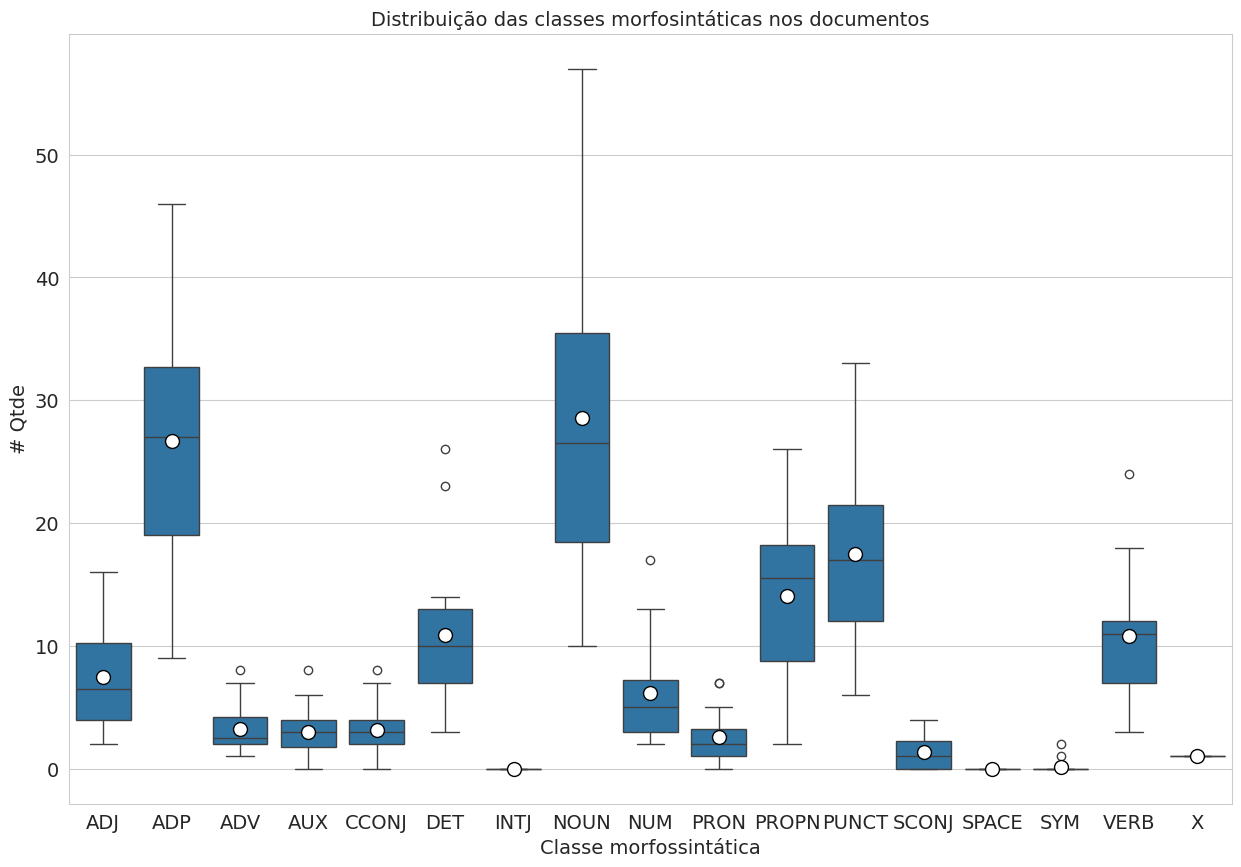

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(dfstats_documentos_dic_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = dfstats_documentos_dic_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de POS Tagging nos documentos

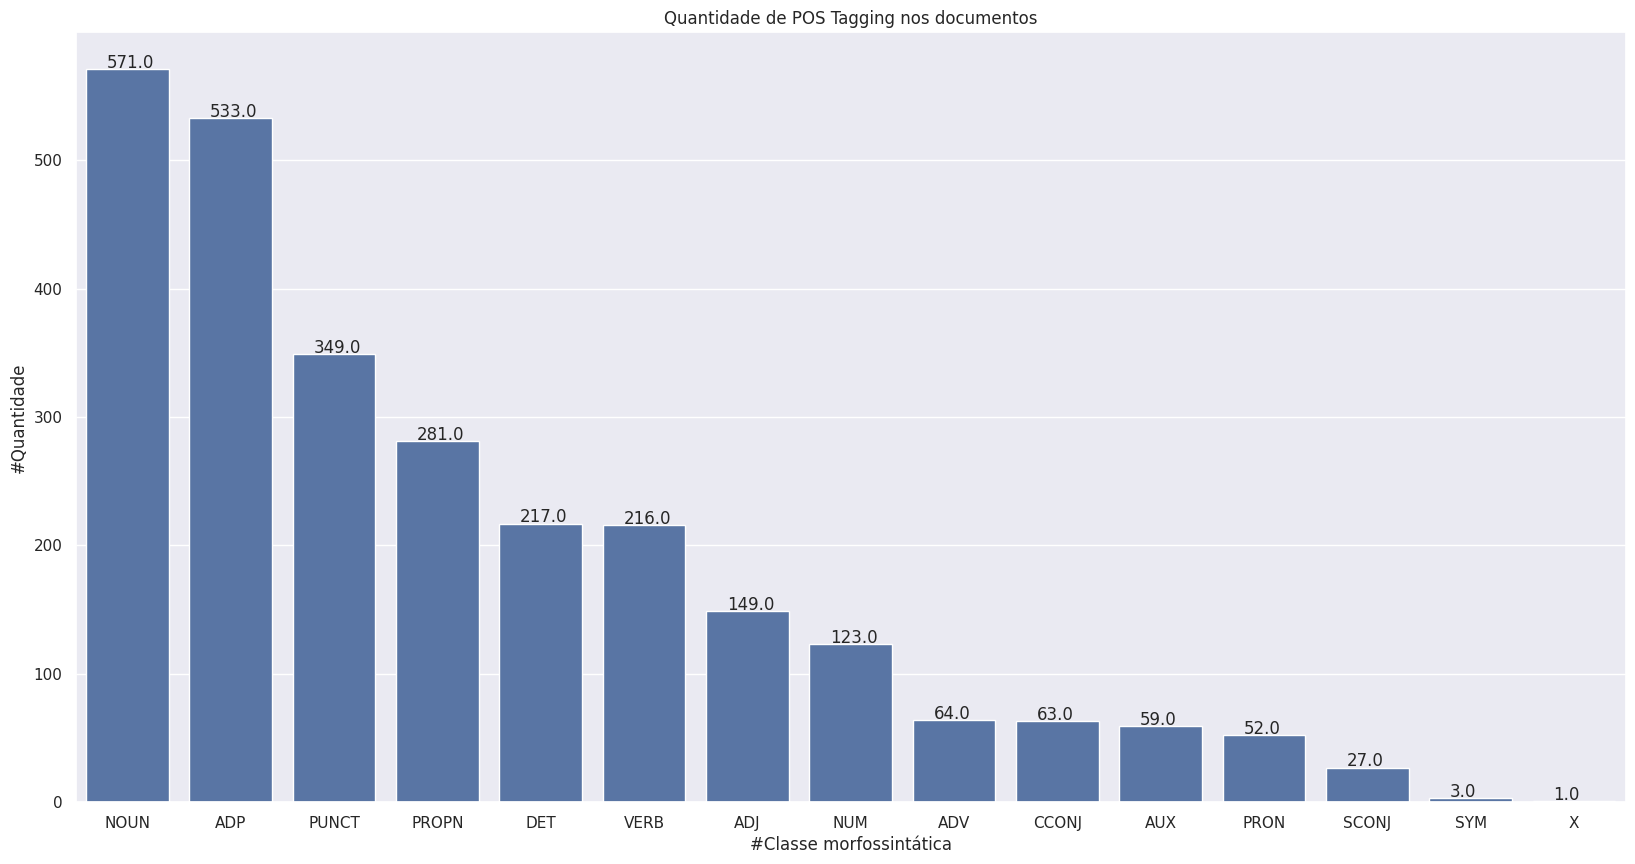

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_documentos_pos['pos'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="pos", data = dfstats_documentos_pos, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de POS Tagging nos documentos")
plt.xlabel("#Classe morfossintática")
plt.ylabel("#Quantidade")

plt.show()

#### 5.2.3.3 NER

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_documentos_dic_ner = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_dic_ner])

# Exibe as estatísticas
dfstats_documentos_dic_ner.describe(include="all")

,LOC,MISC,ORG,PER
count,20.00,20.00,20.00,20.00
mean,4.65,0.65,2.15,1.35
std,2.83,0.99,2.06,2.50
min,0.00,0.00,0.00,0.00
25%,2.75,0.00,0.00,0.00
50%,5.00,0.00,2.00,0.50
75%,7.00,1.25,3.00,1.00
max,9.00,3.00,8.00,10.00


Organiza os dados para gerar o boxplot

In [ ]:
# Converte os dados para o boxplot
lista_dic_ner = []
# Percorre as estatísticas ner dos documentos
for x in stats_documentos_dic_ner:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])
    for chave, valor in posx.items():
        lista_dic_ner.append([x[0], chave, valor])

# Converte em um dataframe
dfstats_documentos_dic_ner = pd.DataFrame(lista_dic_ner, columns=("id", "ner", "qtde"))

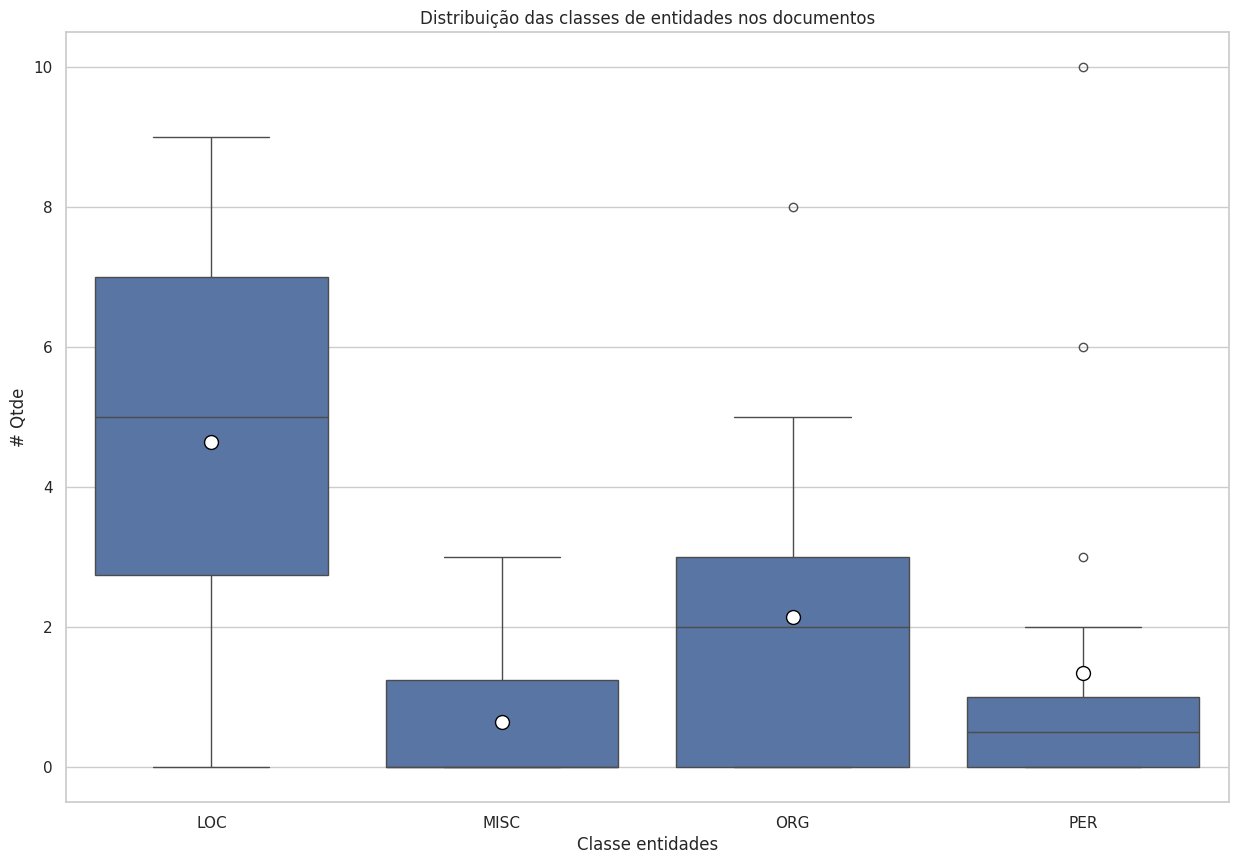

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(dfstats_documentos_dic_ner['ner'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "ner", y = "qtde", data = dfstats_documentos_dic_ner, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes de entidades nos documentos")
# Texto do eixo x
plt.xlabel("Classe entidades")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de NER nos documentos

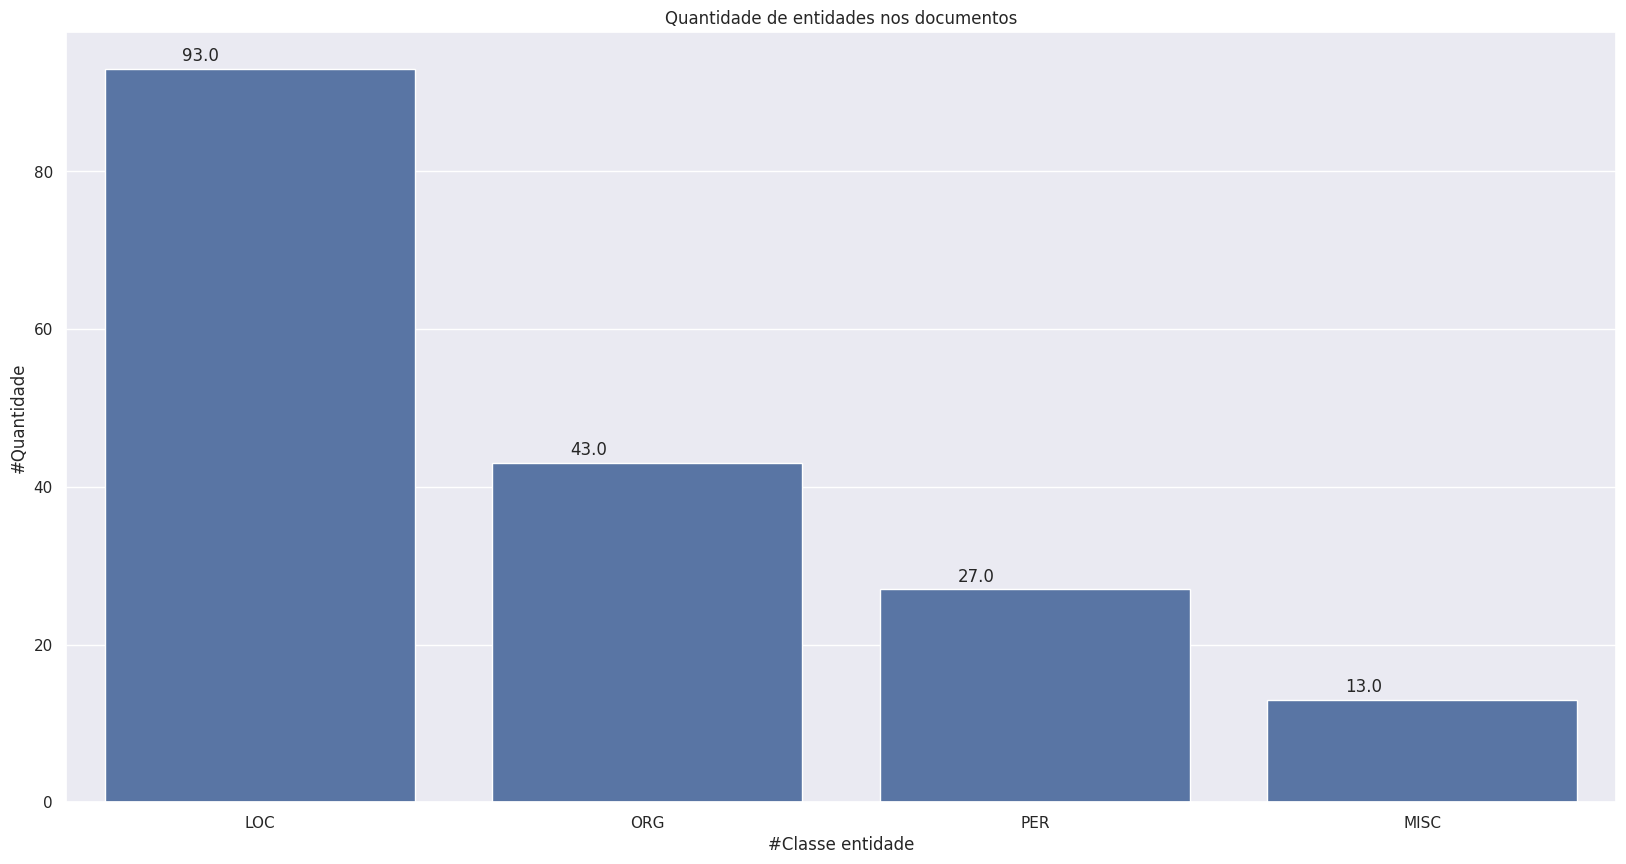

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_documentos_ner['classe'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="classe", data = dfstats_documentos_ner, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de entidades nos documentos")
plt.xlabel("#Classe entidade")
plt.ylabel("#Quantidade")

plt.show()

#### 5.2.3.4 Lista palavras

Lista as 20 palavras com maiores ocorrências no conjunto de dados.

In [ ]:
for i, valor in enumerate(sorted(dicionario_palavras, key = dicionario_palavras.get, reverse=True)):
  if i < 20:
    print(valor, "=>", dicionario_palavras[valor])

, => 193
de => 143
. => 97
a => 61
da => 59
e => 55
do => 54
o => 47
na => 37
que => 36
em => 32
no => 31
um => 23
A => 20
com => 18
( => 18
) => 18
O => 18
' => 18
para => 17


#### 5.2.3.5 Lista palavras desconhecidas e ocorrências

Lista as 20 palavras desconhecidas pelo BERT com maiores ocorrência.

In [ ]:
lista_palavras_desconhecidas_ocorrencias = []

for palavra in sorted(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral]))):
  conta = 0
  tokenizada = ""
  for x in sorted(lista_palavras_desconhecidas_geral, key = lambda x: x[0]):
    if x[0] == palavra:
      conta = conta + 1
      tokenizada = x[1]
  #print(palavra, "=>", tokenizada, "=>", conta)
  lista_palavras_desconhecidas_ocorrencias.append([palavra, tokenizada, conta])

for i, palavra in enumerate(sorted(lista_palavras_desconhecidas_ocorrencias, key = lambda x: x[2], reverse=True)):
  if i < 20:
     print(palavra[0], "=>", palavra[1], "=>", palavra[2])

terça => ['ter', '##ça'] => 4
Infraero => ['Inf', '##ra', '##ero'] => 3
Kaká => ['Ka', '##k', '##á'] => 3
giram => ['gira', '##m'] => 3
Bernardinho => ['Bernard', '##inho'] => 2
Bukavu => ['Bu', '##ka', '##v', '##u'] => 2
Congonhas => ['Congo', '##nha', '##s'] => 2
Coréia => ['Cor', '##éia'] => 2
Cumbica => ['Cu', '##mb', '##ica'] => 2
Dominó => ['Domin', '##ó'] => 2
Itaú => ['Ita', '##ú'] => 2
Jobim => ['Jo', '##bi', '##m'] => 2
Lanka => ['Lan', '##ka'] => 2
Maradona => ['Mara', '##don', '##a'] => 2
Marginal => ['Mar', '##gina', '##l'] => 2
Niigata => ['Ni', '##iga', '##ta'] => 2
PCC => ['PC', '##C'] => 2
PF => ['P', '##F'] => 2
Pyongyang => ['Py', '##ong', '##yan', '##g'] => 2
Robinho => ['Robin', '##ho'] => 2


### 5.2.4 Por sentença

#### 5.2.4.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_sentencas)

df_stats.describe(include="all")

,id,sentenca,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo,qtdepalavrasdesconhecidas,qtdener
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,11.05,2.55,27.08,32.34,16.11,2.13,2.16,2.75,5.71,8.46,3.05,1.76
std,5.63,2.30,11.57,14.76,7.64,1.13,1.19,1.34,2.94,3.71,2.50,1.72
min,1.00,0.00,7.00,8.00,3.00,0.00,0.00,1.00,1.00,2.00,0.00,0.00
25%,6.75,1.00,18.75,20.00,10.00,1.00,1.00,2.00,4.00,6.00,1.00,0.00
50%,11.50,2.00,26.00,31.00,15.00,2.00,2.00,3.00,6.00,8.00,3.00,1.00
75%,16.00,4.00,35.00,42.00,22.00,3.00,3.00,4.00,7.00,10.00,4.25,3.00
max,20.00,9.00,72.00,95.00,41.00,6.00,6.00,7.00,23.00,28.00,16.00,7.00


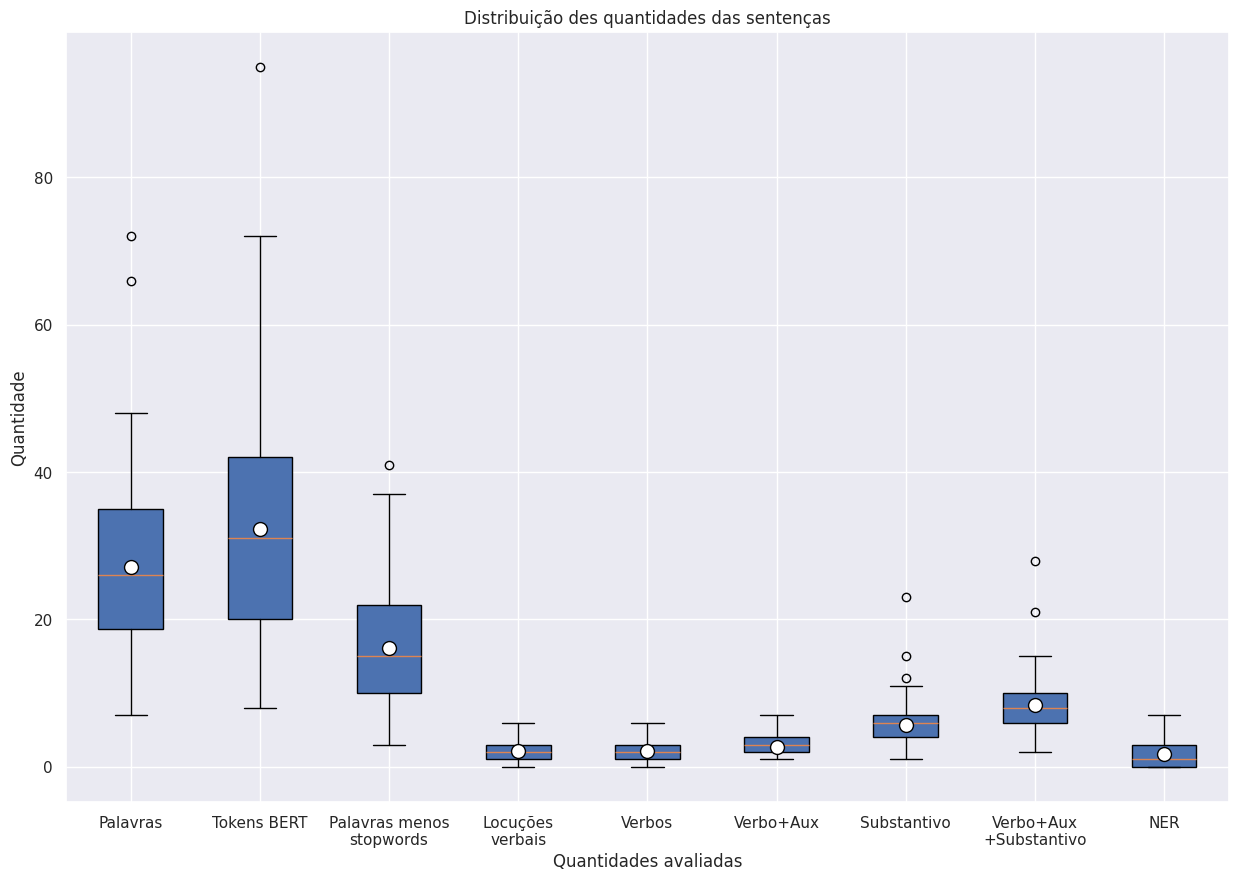

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades das sentenças")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

rotulos = [[x["qtdepalavras"] for x in stats_sentencas],
           [x["qtdetokensbert"] for x in stats_sentencas],
           [x["qtdepalavrassemstopword"] for x in stats_sentencas],
           [x["qtdelocverbo"] for x in stats_sentencas],
           [x["qtdeverbo"] for x in stats_sentencas],
           [x["qtdeverboaux"] for x in stats_sentencas],
           [x["qtdesubstantivo"] for x in stats_sentencas],
           [x["qtdeverboauxsubstantivo"] for x in stats_sentencas],
           [x["qtdener"] for x in stats_sentencas],
           ]

# Estrutura do gráfico
ax.boxplot(rotulos, patch_artist=True,
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, ["Palavras",
                     "Tokens BERT",
                     "Palavras menos\nstopwords",
                     "Locuções\nverbais",
                     "Verbos",
                     "Verbo+Aux",
                     "Substantivo",
                     "Verbo+Aux\n+Substantivo",
                     "NER"])

# Mostra o gráfico
plt.show()

#### 5.2.4.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_dic_pos = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_dic_pos])

# Exibe as estatísticas
df_stats_sentencas_dic_pos.describe()

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,1.0
mean,0.52,2.16,3.49,2.17,5.71,0.59,0.63,5.33,2.81,1.49,0.64,1.23,0.27,0.03,0.0,0.0,1.0
std,0.75,1.19,2.31,1.68,2.94,0.64,0.69,2.83,3.08,1.48,0.81,1.32,0.53,0.17,0.0,0.0,NaN
min,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.0
25%,0.00,1.00,2.00,1.00,4.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.0
50%,0.00,2.00,3.00,2.00,6.00,1.00,1.00,5.00,2.00,1.00,0.00,1.00,0.00,0.00,0.0,0.0,1.0
75%,1.00,3.00,4.00,3.00,7.00,1.00,1.00,7.00,5.00,2.00,1.00,2.00,0.00,0.00,0.0,0.0,1.0
max,3.00,6.00,11.00,11.00,23.00,2.00,3.00,20.00,12.00,7.00,3.00,6.00,2.00,1.00,0.0,0.0,1.0


In [ ]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_dic_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_dic_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde"))

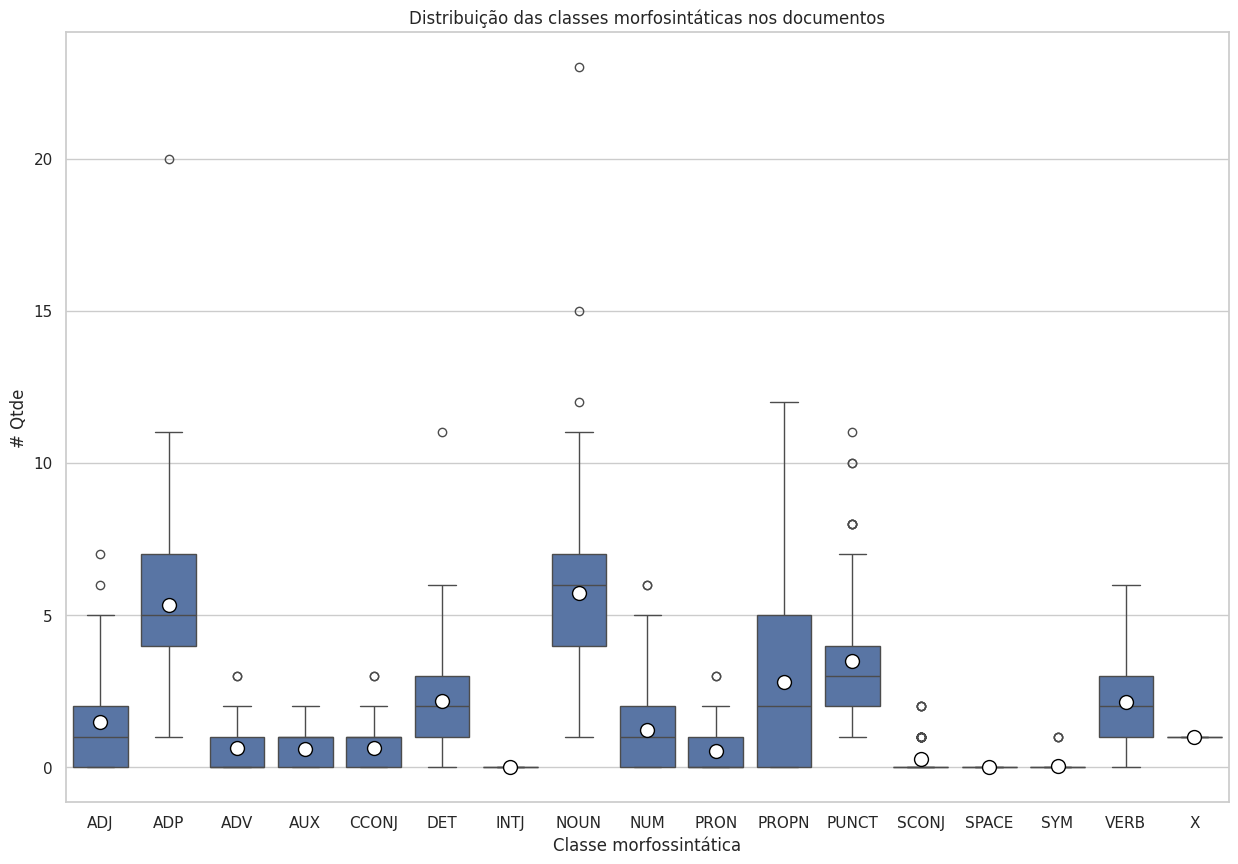

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_dic_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_sentencas_dic_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes morfossintática por sentença

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


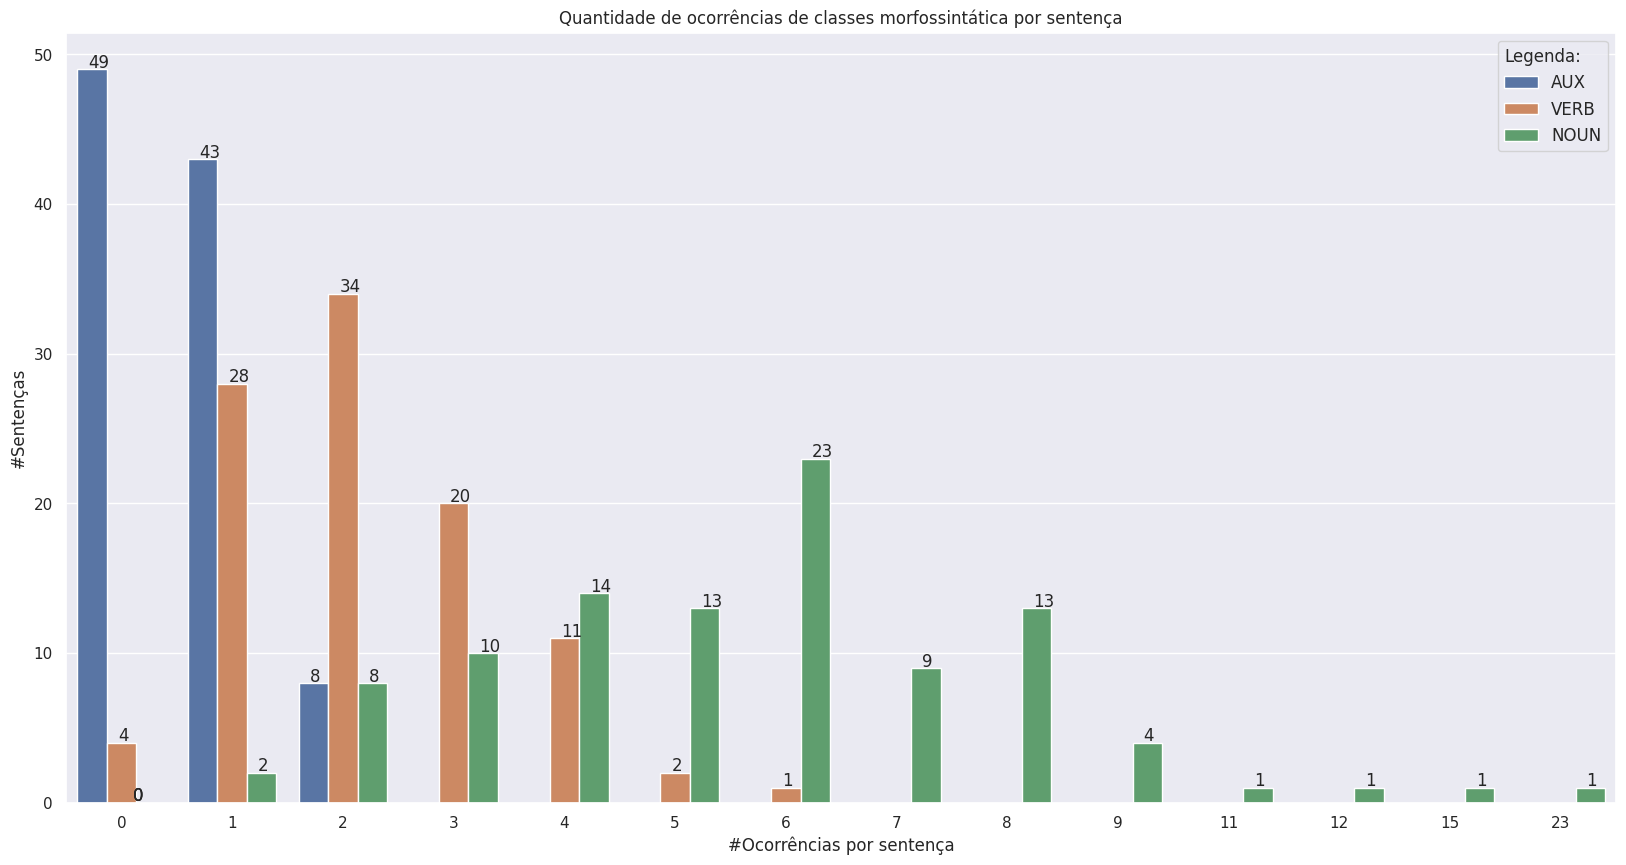

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_pos = df_stats_sentencas_dic_pos[df_stats_sentencas_dic_pos["pos"].isin(["NOUN","VERB","AUX"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="pos"  ,data=df_pos)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))

plt.title("Quantidade de ocorrências de classes morfossintática por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 4(#Sentenças) sentenças onde palavras da classe morfossintática VERB(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.3 Gráficos de POS Tagging nas sentenças dos documentos

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


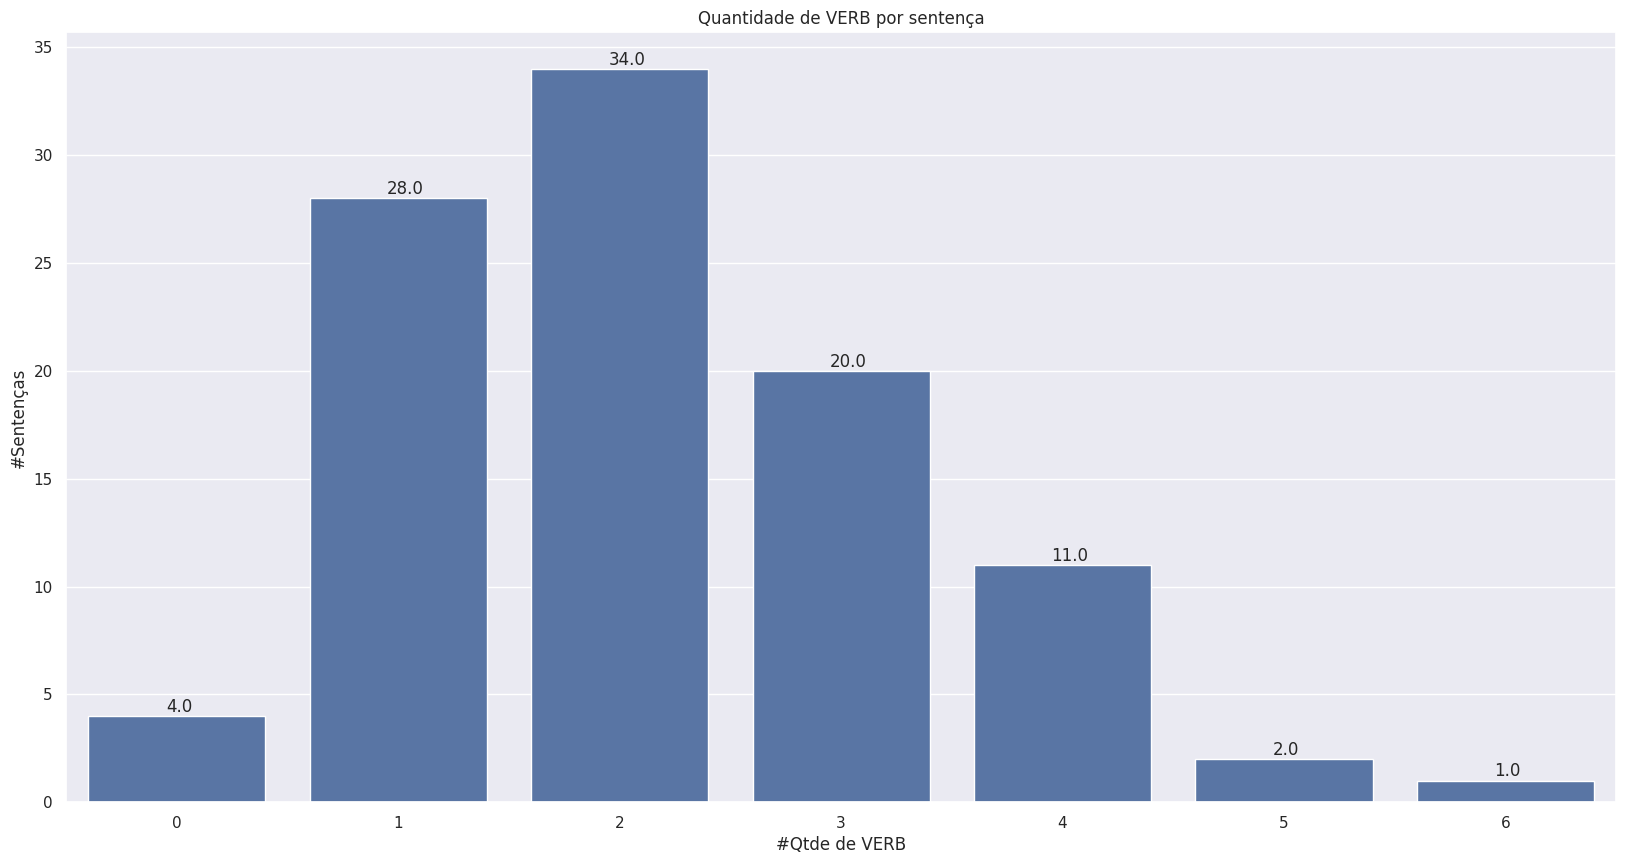

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="VERB"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de VERB por sentença")
plt.xlabel("#Qtde de VERB")
plt.ylabel("#Sentenças")

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


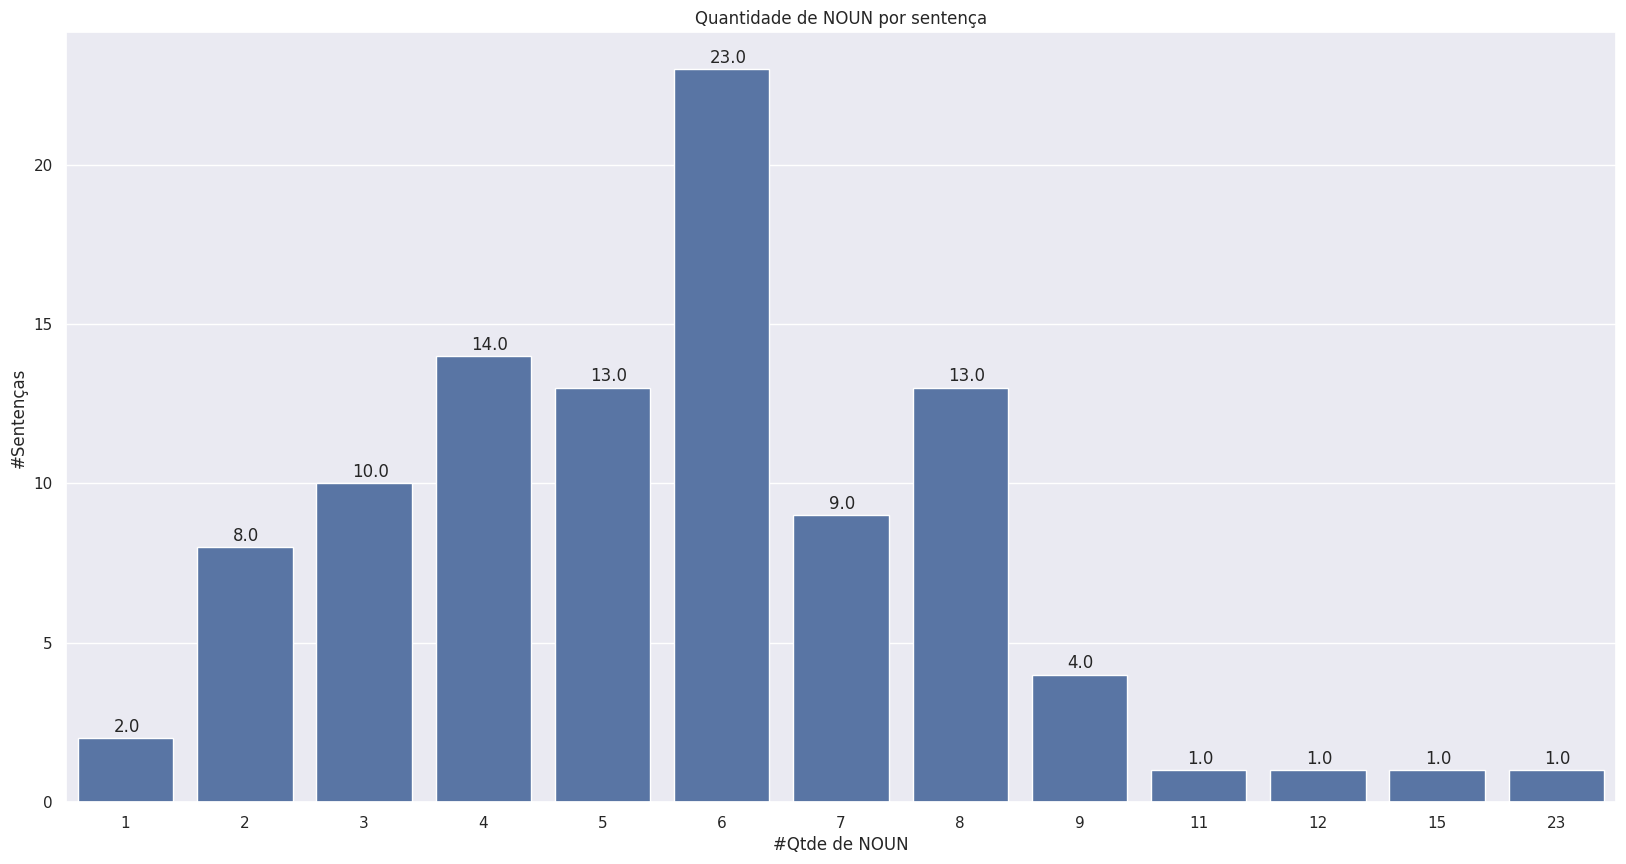

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="NOUN"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de NOUN por sentença")
plt.xlabel("#Qtde de NOUN")
plt.ylabel("#Sentenças")

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


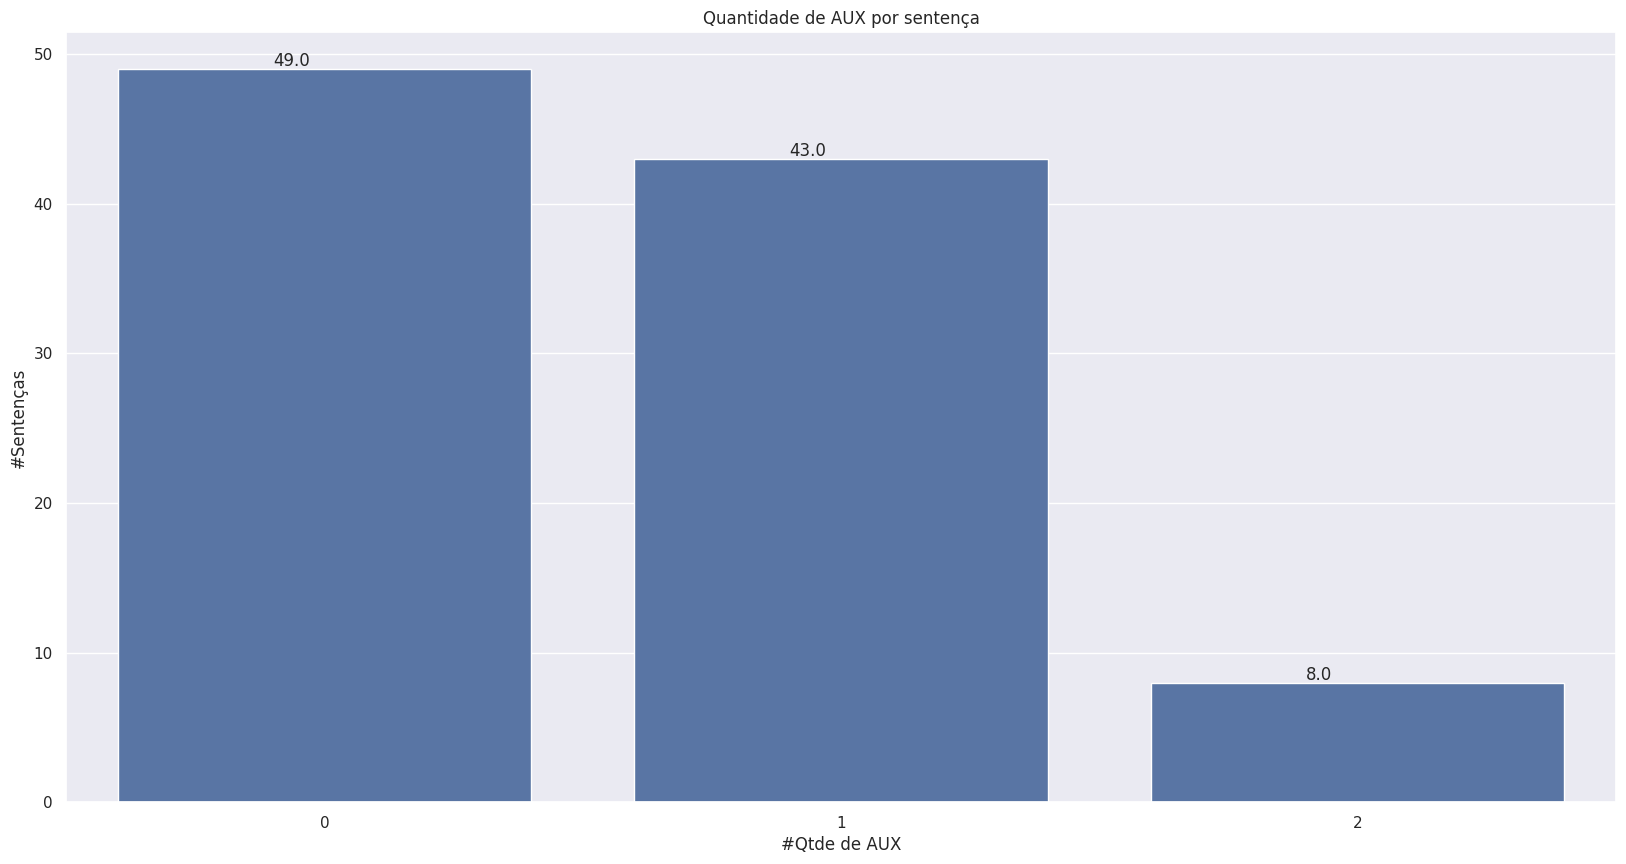

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="AUX"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de AUX por sentença")
plt.xlabel("#Qtde de AUX")
plt.ylabel("#Sentenças")

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


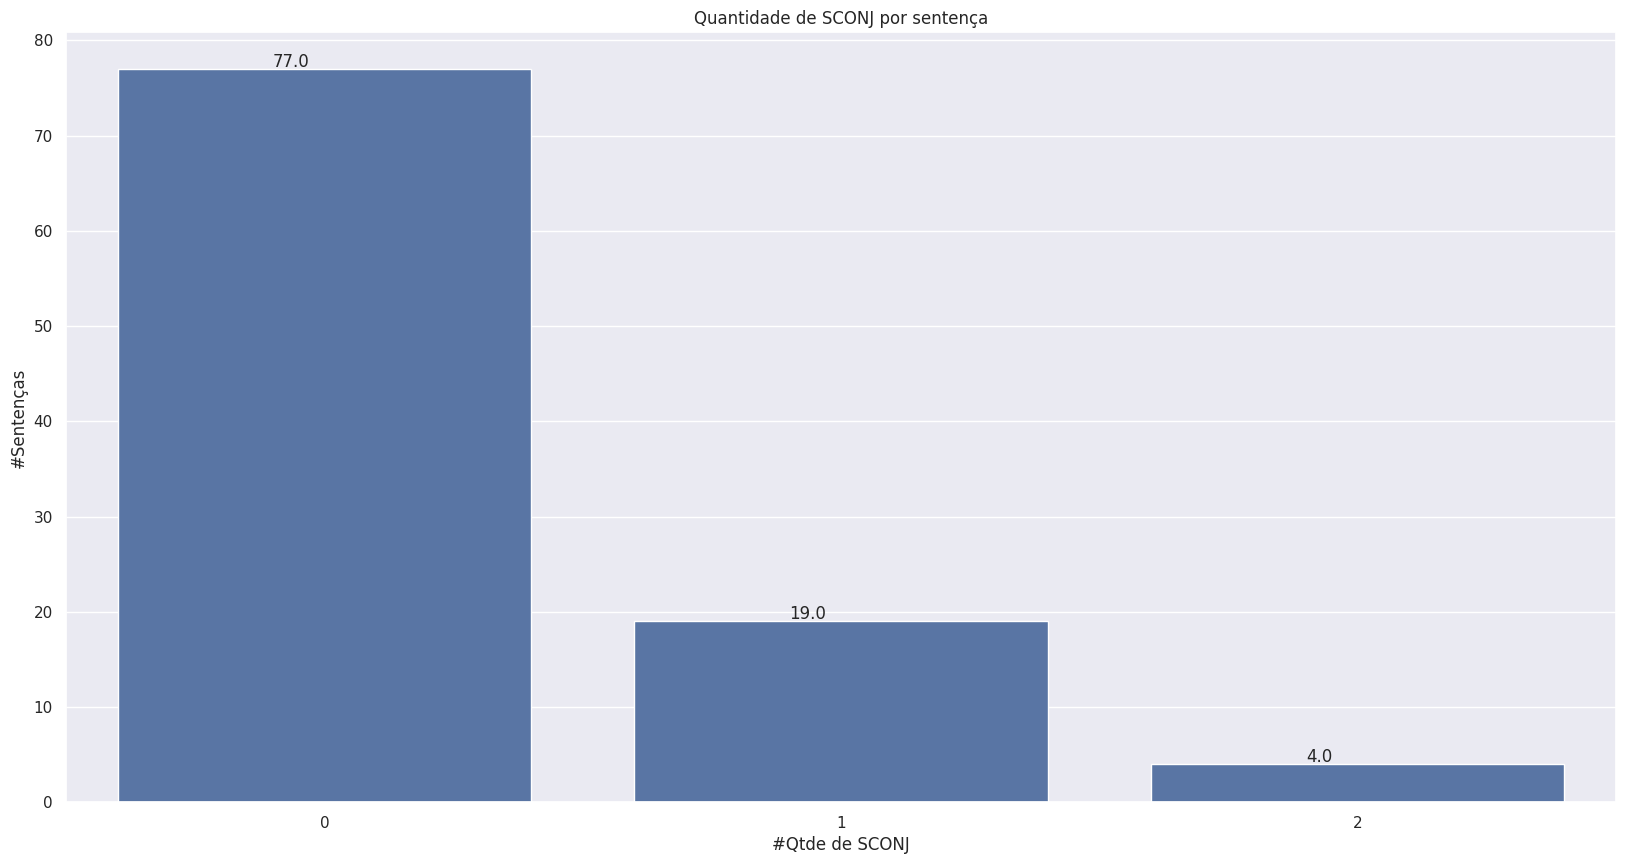

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="SCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de SCONJ por sentença")
plt.xlabel("#Qtde de SCONJ")
plt.ylabel("#Sentenças")

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


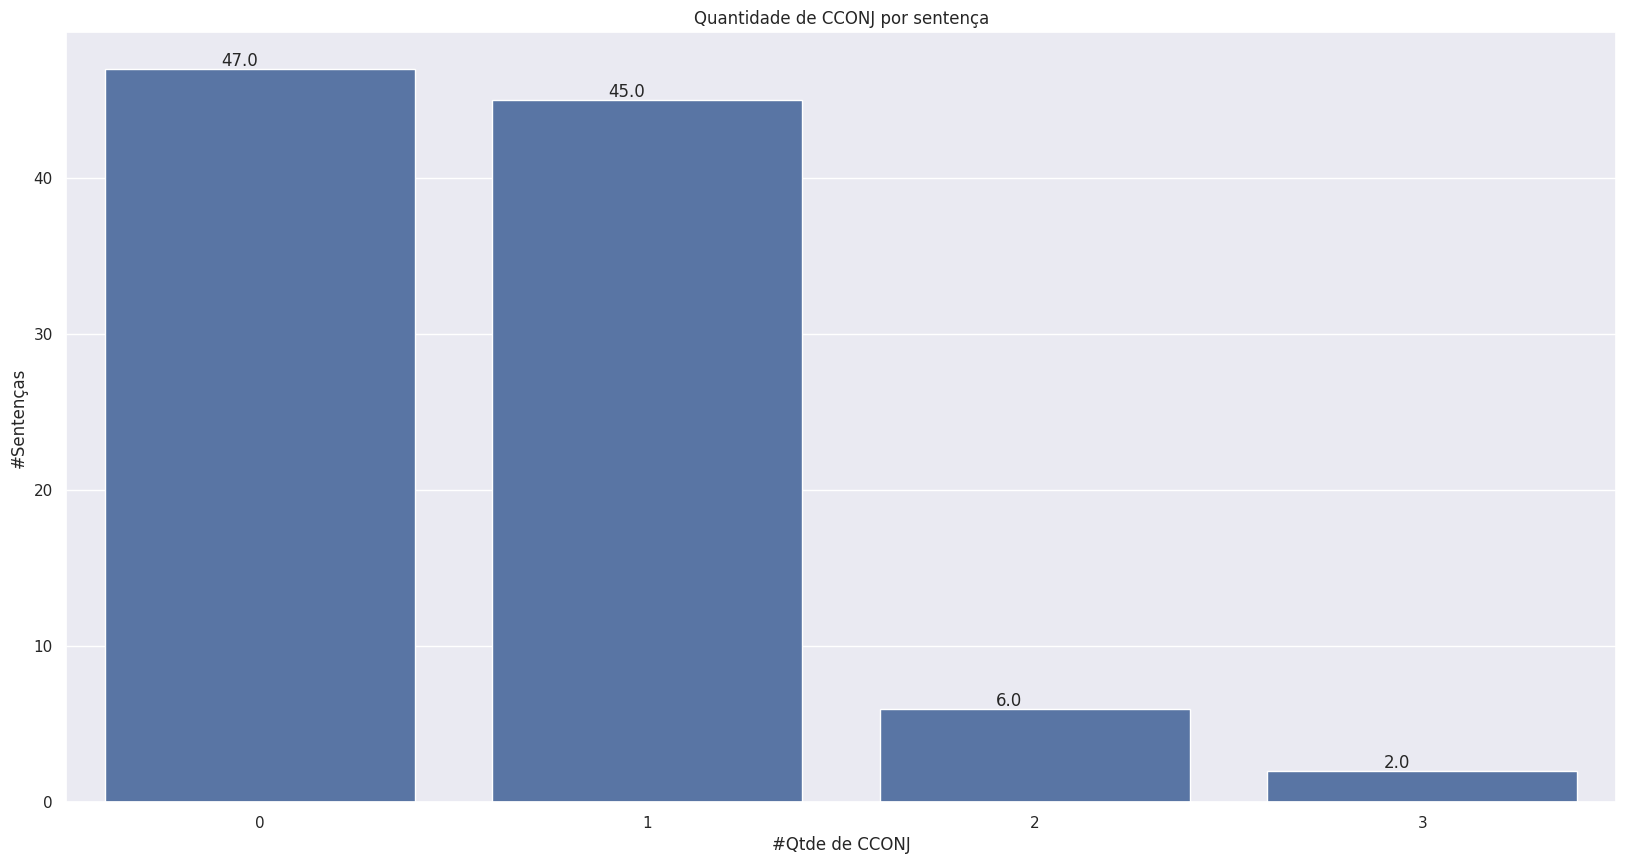

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="CCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de CCONJ por sentença")
plt.xlabel("#Qtde de CCONJ")
plt.ylabel("#Sentenças")

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


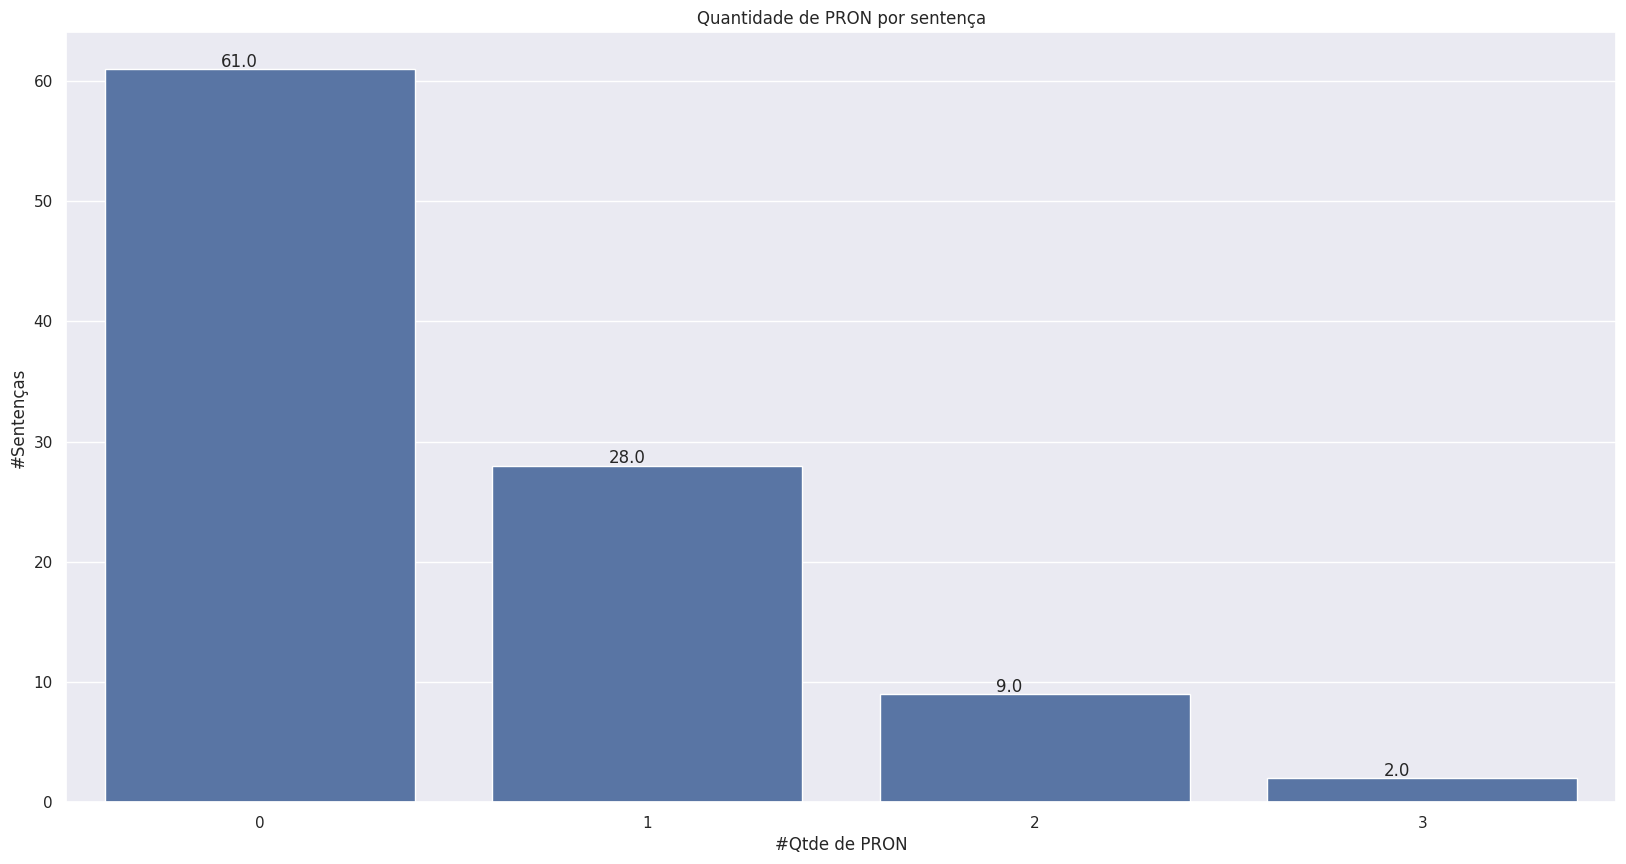

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_pos.iterrows() if f["pos"]=="PRON"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de PRON por sentença")
plt.xlabel("#Qtde de PRON")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.4.4 NER

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_dic_ner = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_dic_ner])

# Exibe as estatísticas
df_stats_sentencas_dic_ner.describe()

,LOC,MISC,ORG,PER
count,100.00,100.00,100.00,100.00
mean,0.93,0.13,0.43,0.27
std,1.22,0.46,0.74,0.62
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.50,0.00,0.00,0.00
75%,1.00,0.00,1.00,0.00
max,5.00,3.00,3.00,3.00


In [ ]:
# Converte os dados para o boxplot
lista_ner = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_dic_ner:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])
    for chave, valor in posx.items():
        lista_ner.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_dic_ner = pd.DataFrame(lista_ner, columns=("id", "ner", "qtde"))

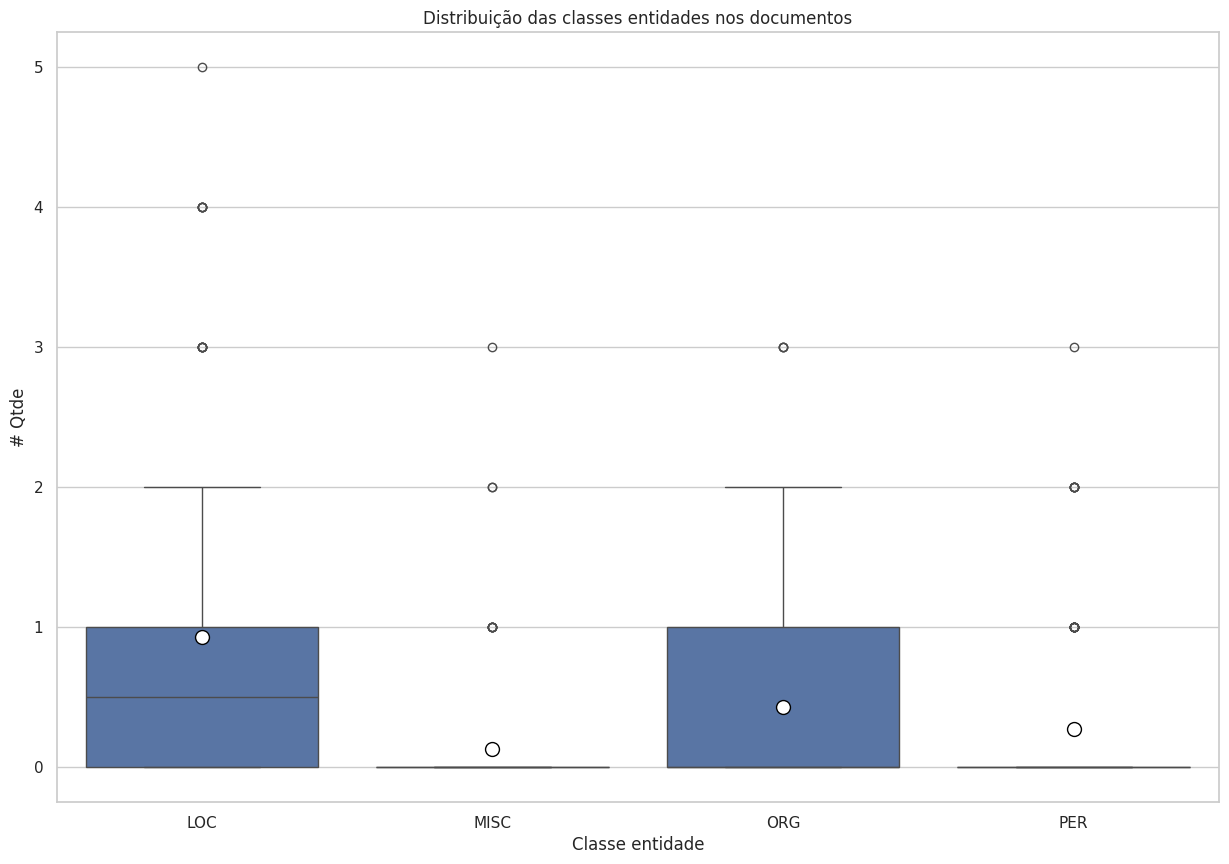

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_dic_ner['ner'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "ner", y = "qtde", data = df_stats_sentencas_dic_ner, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes entidades nos documentos")
# Texto do eixo x
plt.xlabel("Classe entidade")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes entidades por sentença

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


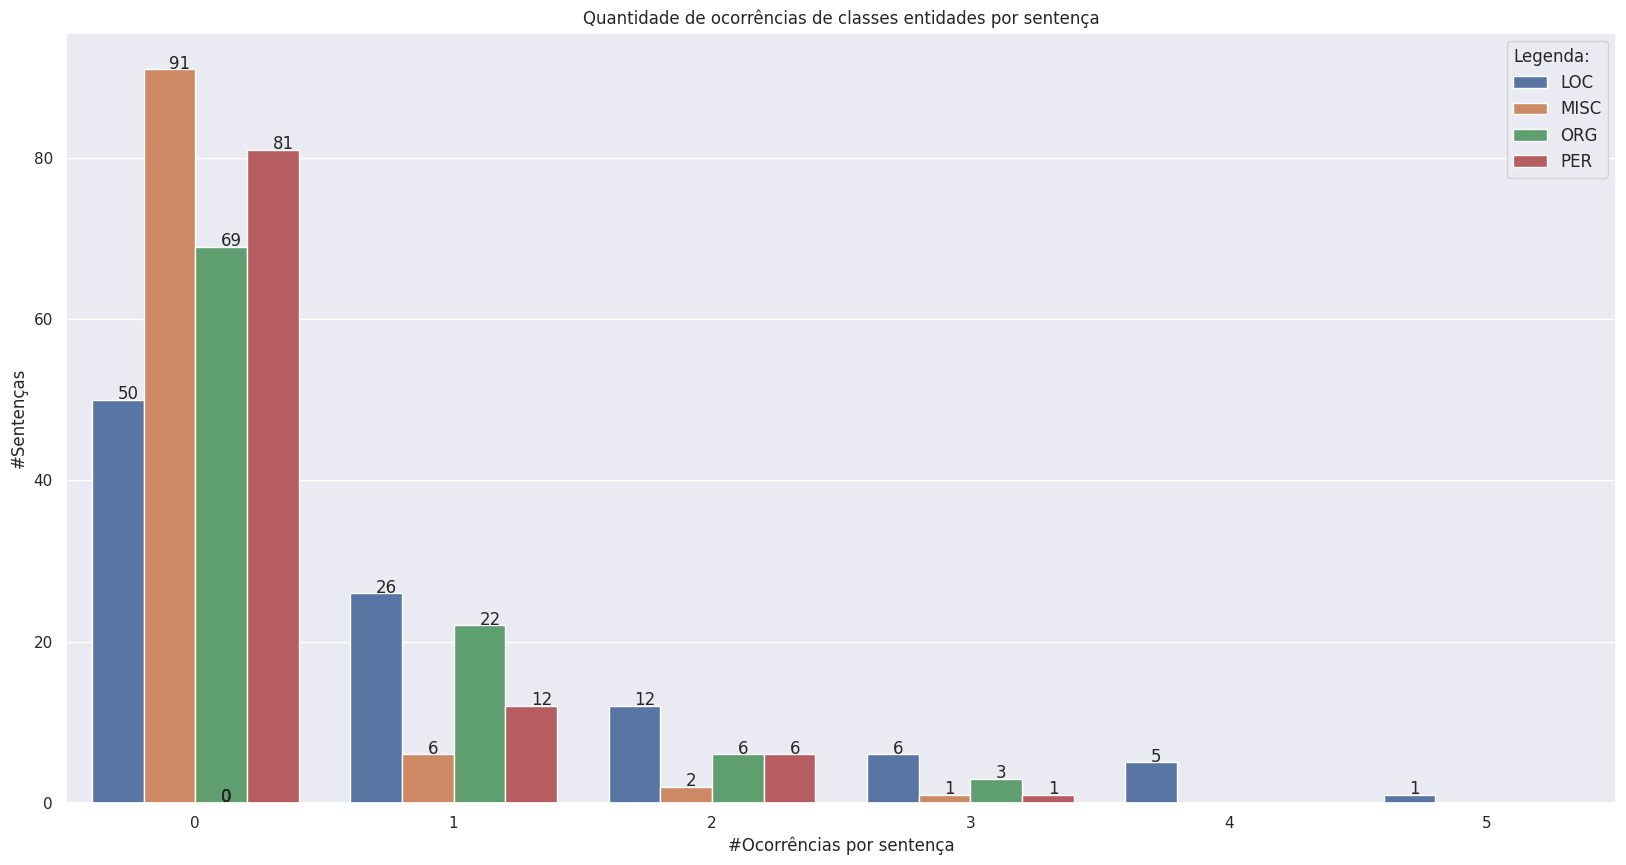

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_ner = df_stats_sentencas_dic_ner[df_stats_sentencas_dic_ner["ner"].isin(["LOC","MISC","ORG","PER"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="ner" ,data=df_ner)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))

plt.title("Quantidade de ocorrências de classes entidades por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 4(#Sentenças) sentenças onde palavras da classe morfossintática LOC(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.5 Gráficos NER nas sentenças dos documentos

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


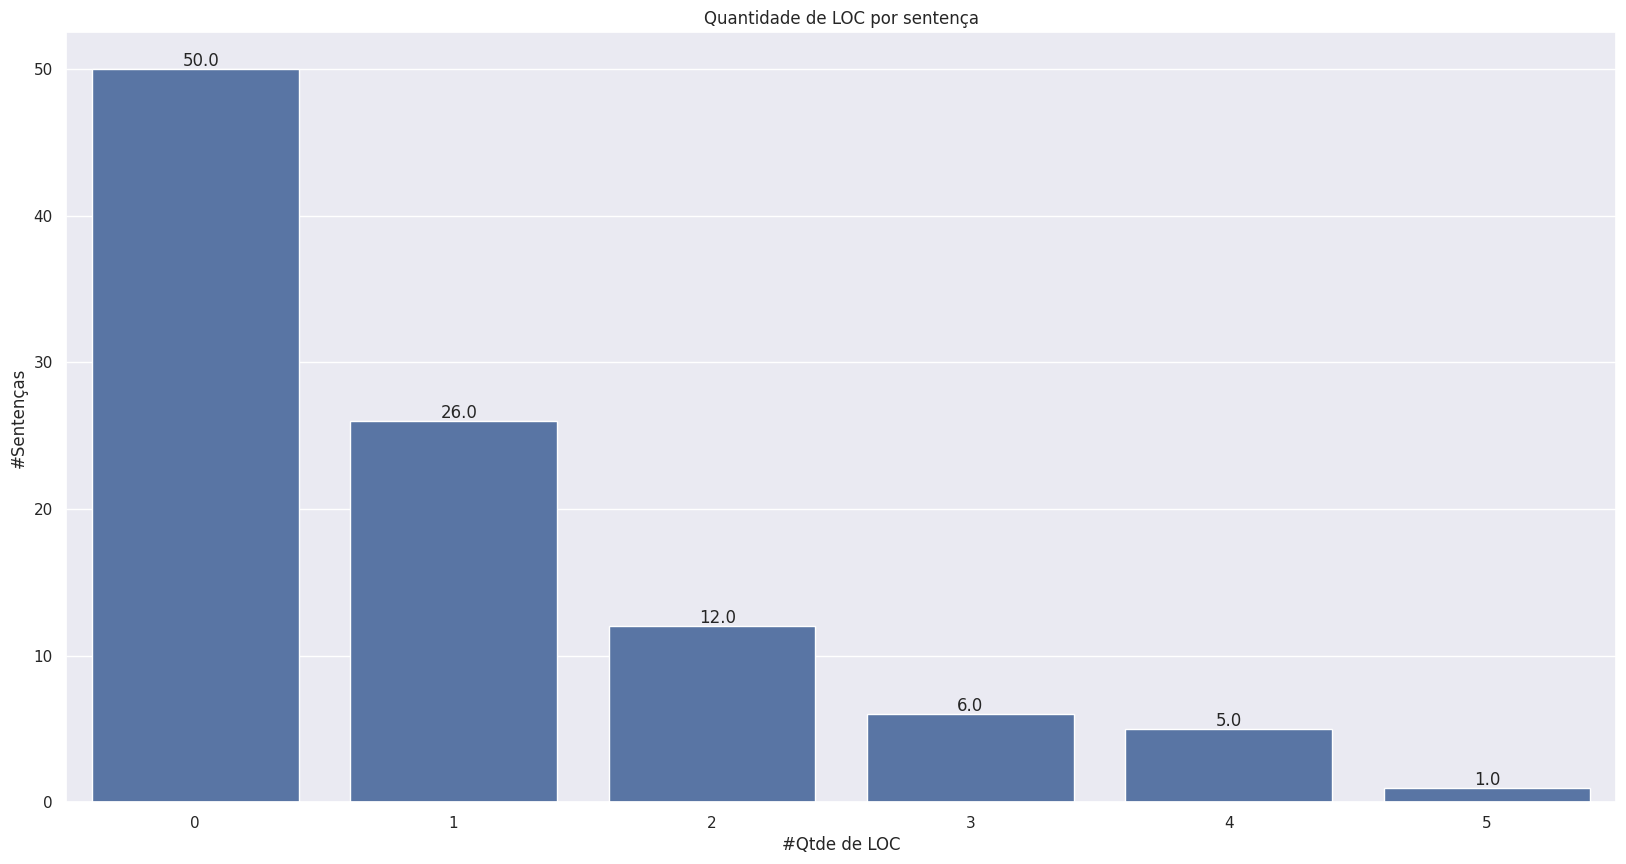

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_ner.iterrows() if f["ner"]=="LOC"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de LOC por sentença")
plt.xlabel("#Qtde de LOC")
plt.ylabel("#Sentenças")

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


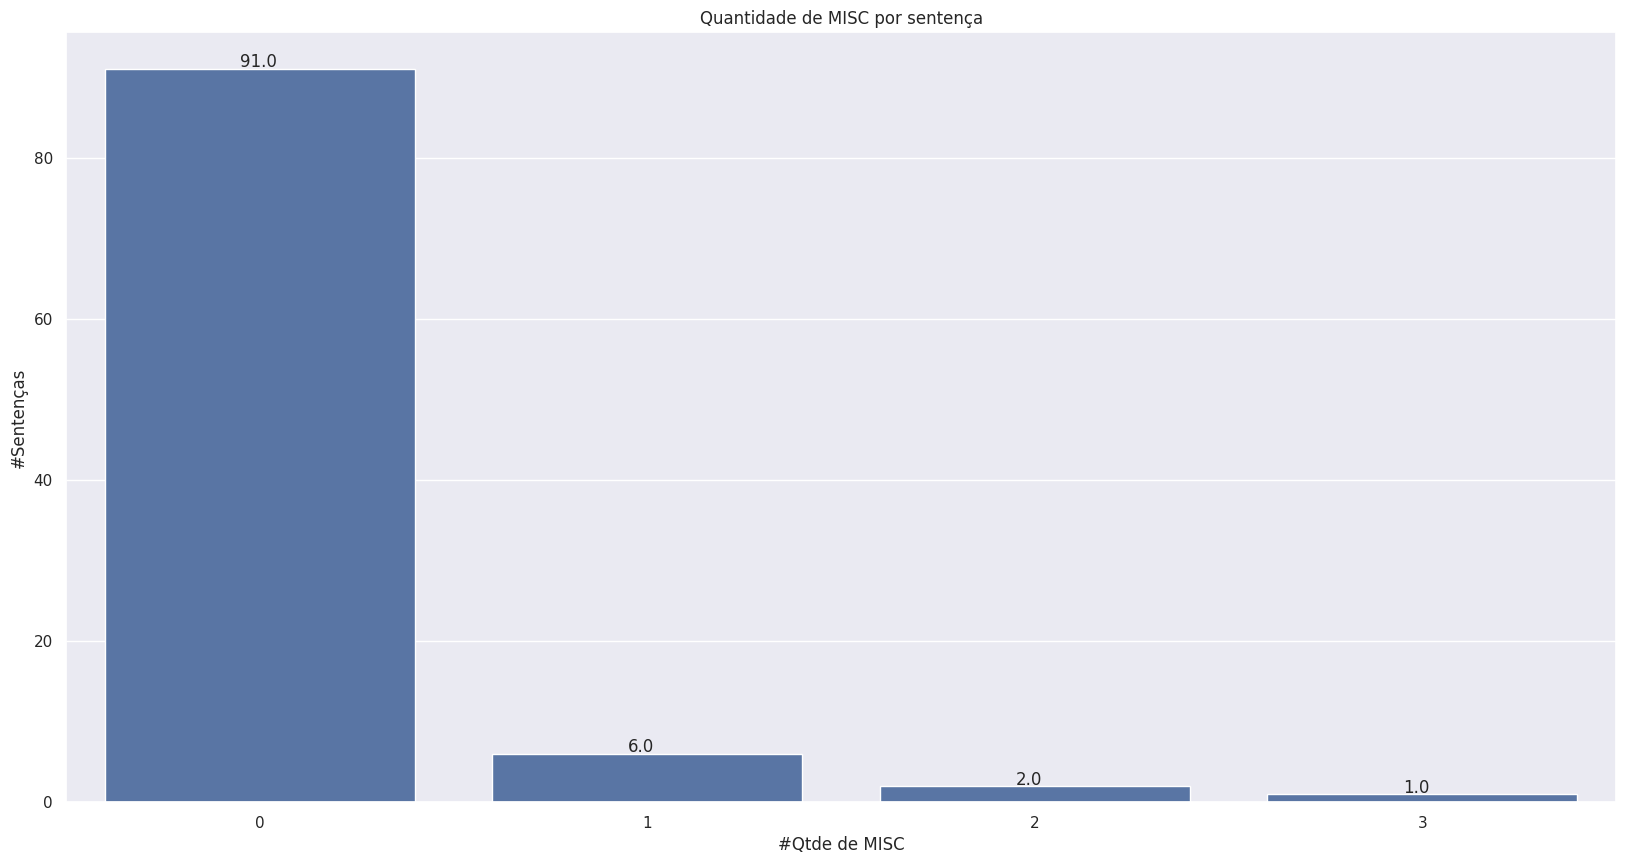

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_ner.iterrows() if f["ner"]=="MISC"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de MISC por sentença")
plt.xlabel("#Qtde de MISC")
plt.ylabel("#Sentenças")

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


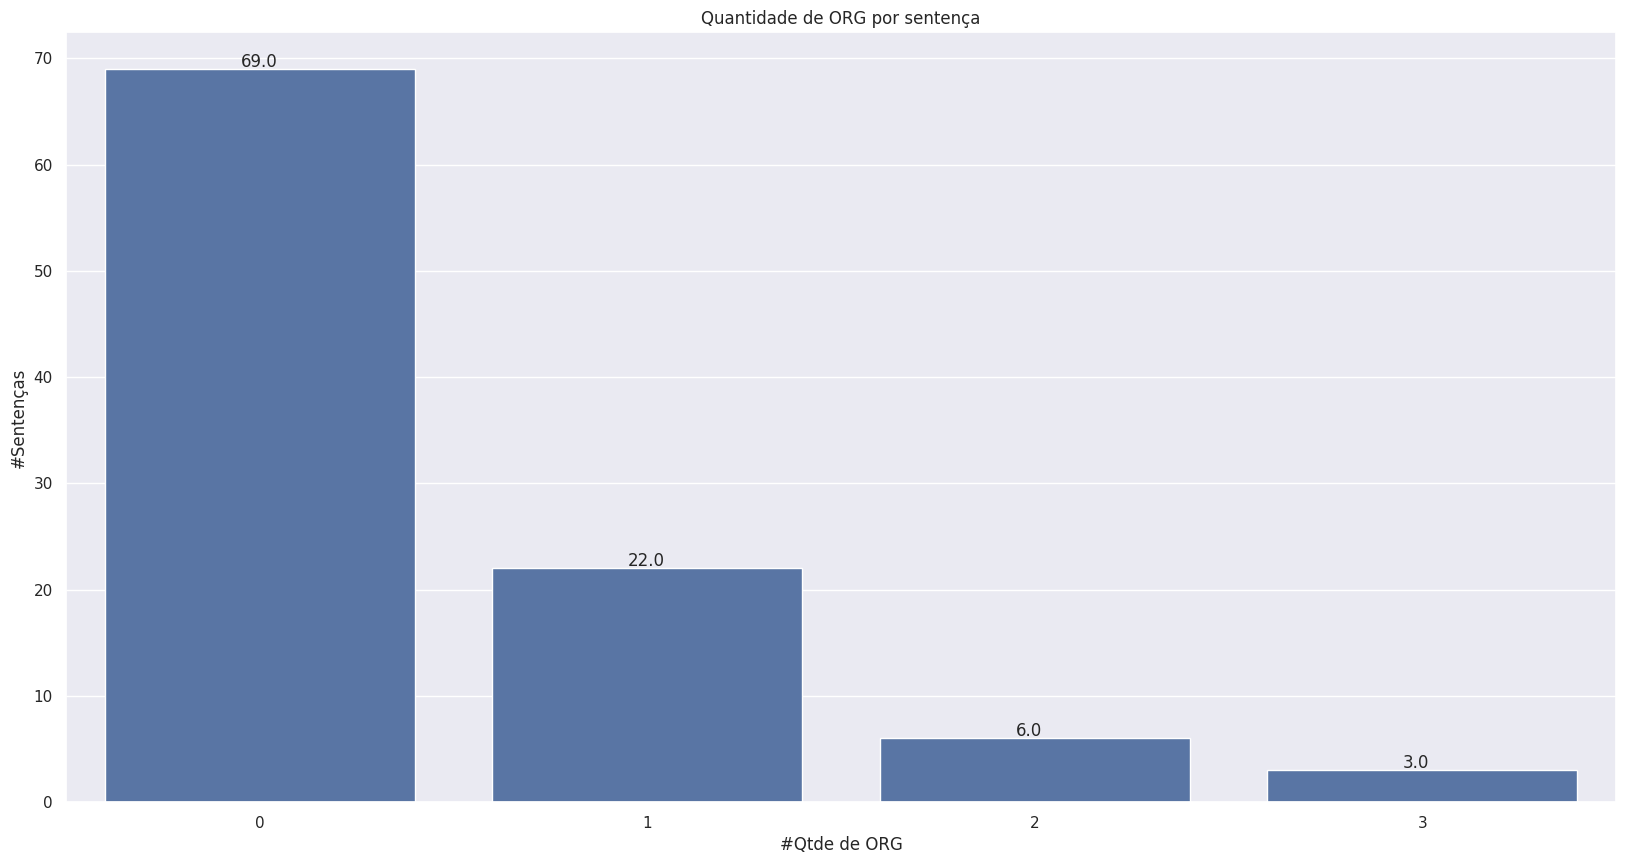

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_dic_ner.iterrows() if f["ner"]=="ORG"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.2))

plt.title("Quantidade de ORG por sentença")
plt.xlabel("#Qtde de ORG")
plt.ylabel("#Sentenças")

plt.show()

### 5.2.5 Por Janela

#### 5.2.5.1 Função que gera as janelas

In [ ]:
def contaItensLista(lista):
  '''
  Conta os itens das lista de listas.

  Parâmetros:
    `lista` - Uma lista de lista itens.

  Retorno:
    `qtde_itens` - Quantidade de itens das listas.
  '''
  # Quantidade itens da lista
  qtde_itens = 0

  for item in lista:
    qtde_itens = qtde_itens + len(item)

  return qtde_itens

In [ ]:
def truncaJanela(lista_janela,
                 maximo_itens,
                 lista_centro_janela):
  '''
  Trunca as palavras da janela até o máximo da janela.

  Parâmetros:
    `lista_janela` - Um dataframe com os itens.
    `maximo_itens` - Máximo de itens na janela. Trunca das extremidades preservando a palavra central.
    `lista_centro_janela` - Lista com os índices dos centros da janela.

  Retorno:
    `lista_janela` - Janela truncada pelo máximo de itens.
  '''
  # Quantidade de itens nas janelas antes
  qtde_itens1 = contaItensLista(lista_janela)
  # print("quantidade de itens janela antes:", qtde_itens1)

  # Controle se não alcançado o máximo de palavras
  minimo_alcancado = False

  # Indices para os elementos a serem excluídos
  indice_esquerda = 0
  indice_direita = len(lista_janela) -1

  # Remove as palavras das extremidade que ultrapassam o tamanho máximo
  while qtde_itens1 > maximo_itens and minimo_alcancado == False:

    # Recupera os intervalo das folhas da direita e esquerda e centro
    # Intervalo da folha da esquerda do centro
    # Sempre inicia em 0
    inicio_folha_esquerda = 0
    fim_folha_esquerda = lista_centro_janela[0]

    # Intervalo do centro
    #inicio_centro_esquerda = lista_centro_janela[0]
    #fim_centro_direita = lista_centro_janela[-1]+1

    # Intervalo da folha da direita do centro
    inicio_folha_direita = lista_centro_janela[-1]+1
    # Vai até o final da lista
    fim_folha_direita = len(lista_janela)

    # Conta os elementos dos intervalos
    conta_itens_esquerda = contaItensLista(lista_janela[inicio_folha_esquerda:fim_folha_esquerda])
    #conta_itens_centro = contaItensLista(lista_janela[inicio_centro_esquerda:fim_centro_direita])
    conta_itens_direita = contaItensLista(lista_janela[inicio_folha_direita:fim_folha_direita])

    # print("")
    # print("inicio_folha_esquerda :", inicio_folha_esquerda, "/fim_folha_esquerda:", fim_folha_esquerda, " conta:", conta_itens_esquerda)
    # print("inicio_centro_esquerda:",inicio_centro_esquerda,"/fim_centro_direita:", fim_centro_direita, " conta:", conta_itens_centro)
    # print("inicio_folha_direita  :",inicio_folha_direita,"/fim_folha_direita:", fim_folha_direita, " conta:", conta_itens_direita)

    # Se a quantidade de itens a direita for maior apaga deste lado
    if conta_itens_direita > conta_itens_esquerda:
      # Remove da direita
      if len(lista_janela[indice_direita]) > 0:
        # Remove do fim da janela
        lista_janela[indice_direita].pop()
        if len(lista_janela[indice_direita]) == 0:
          # Não pode ser menor que o centro
          if indice_direita > lista_centro_janela[-1]:
            indice_direita = indice_direita - 1
    else:
        # Remove da esquerda
        if len(lista_janela[indice_esquerda]) > 0:
          # Remove do inicio da janela
          lista_janela[indice_esquerda].pop(0)
          if len(lista_janela[indice_esquerda]) == 0:
            # Não pode ser menor que o centro
            if indice_esquerda < lista_centro_janela[0]:
              indice_esquerda = indice_esquerda + 1

    # Calcula a nova quantidade de itens
    qtde_itens2 = contaItensLista(lista_janela)

    # Verifica se conseguiu reduzir a quantidade de itens
    if (qtde_itens1 == qtde_itens2):
      print("Atenção!: Truncamento de janela não conseguiu reduzir além de ", qtde_itens2, " para o máximo ", maximo_itens)
      minimo_alcancado = True

    # Atribui uma nova quantidade
    qtde_itens1 = qtde_itens2

  return lista_janela

In [ ]:
def getJanelaLista(lista, tamanho_janela, indice_passo, maximo_itens=None):
  '''
  Cria janelas de itens de uma lista

  Parâmetros:
    `lista` - Uma lista de lista com os itens a se serem colocados em uma janela.
    `tamanho_janela` - Tamanho da janela a ser construída.
    `indice_passo` - Índice do passo que se deseja da janela.
    `maximo_itens` - Máximo de itens na janela. Trunca das extremidades preservando a palavra central.

  Retorno:
    `lista_janela` - Lista com os itens em janelas.
    `string_janela` - String com os itens em janelas.
    `lista_indice_janela` - Lista com os índices dos itens que forma a janela.
    `lista_centro_janela` - Lista com os índices dos centros da janela.
  '''

  # Se a lista de itens é menor ou igual ao tamanho da janela
  if len(lista) <= tamanho_janela:

    # Recupera os itens da janela
    lista_janela = lista

    # Guarda os índices dos itens das janelas
    lista_indice_janela = []

    # Adiciona os índices das janelas
    for i in range(len(lista)):
      lista_indice_janela.append(i)

    # Guarda os índices dos centros das janelas
    lista_centro_janela = []
    # Calcula o centro
    centro_janela = int((len(lista)/2))
    lista_centro_janela.append(centro_janela)

    # Concatena em uma string as palavras das itens da janela
    lista_janela_itens = []
    for item in lista_janela:
      lista_janela_itens.append(" ".join(item))

    return lista_janela, " ".join(lista_janela_itens), lista_indice_janela, lista_centro_janela

  else:
    # Lista maior que o tamanho da janela
    # Calcula o tamanho da folha da janela(quantidade de itens a esquerda e direita do centro da janela).
    folha_janela = int((tamanho_janela-1) /2)
    # Define o centro da janela
    centro_janela = -1
    # Se a janela está dentro do intervalo da lista de itens
    if indice_passo >= 0 and indice_passo < len(lista):

      # Guarda os itens da janela
      lista_janela = []
      # Guarda os índices dos itens das janelas
      lista_indice_janela = []
      # Guarda os índices dos centros das janelas
      # Por enquanto somente centro com um elemento
      lista_centro_janela = []

      # Inicio da lista sem janelas completas depois do meio da janela, folha da direita do centro
      if indice_passo < folha_janela:
        # print("Inicio da lista")
        # itens anteriores
        #Evita estourar o início da lista
        inicio = 0
        fim = indice_passo
        # print("Anterior: inicio:", inicio, " fim:", fim)
        for j in range(inicio, fim):
          # Recupera o documento da lista
          documento = lista[j]
          lista_janela.append(documento)
          # Adiciona o indice do documento na lista
          lista_indice_janela.append(j)

        # item central
        # Recupera o documento da lista
        documento = lista[indice_passo]
        lista_janela.append(documento)
        # Adiciona o indice do documento na lista
        lista_indice_janela.append(indice_passo)
        # Guarda o centro da janela
        centro_janela = len(lista_janela)-1
        lista_centro_janela.append(centro_janela)

        # itens posteriores
        inicio = indice_passo + 1
        fim = indice_passo + folha_janela + 1
        # print("Posterior: inicio:", inicio, " fim:", fim)
        for j in range(inicio,fim):
          # Recupera o documento da lista
          documento = lista[j]
          lista_janela.append(documento)
          # Adiciona o indice do documento na lista
          lista_indice_janela.append(j)

      else:
        # Meio da lista com janelas completas antes e depois, folhas de tamanhos iguais a esquerda e a direita
        if indice_passo < len(lista)-folha_janela:
          # print(" Meio da lista")

          # itens anteriores
          inicio = indice_passo - folha_janela
          fim = indice_passo
          # print("inicio:", inicio, " fim:", fim)
          for j in range(inicio, fim):
            # Recupera o documento da lista
            documento = lista[j]
            # Adiciona o documento a janela
            lista_janela.append(documento)
            # Adiciona o indice do documento na lista
            lista_indice_janela.append(j)

          # item central
          # Recupera o documento da lista
          documento = lista[indice_passo]
          # Adiciona o documento a janela
          lista_janela.append(documento)
          # Adiciona o indice do documento na lista
          lista_indice_janela.append(indice_passo)
          # Guarda o centro da janela
          centro_janela = len(lista_janela)-1
          lista_centro_janela.append(centro_janela)

          # itens posteriores
          inicio = indice_passo + 1
          fim = indice_passo + 1 + folha_janela
          for j in range(inicio,fim):
            # Recupera o documento da lista
            documento = lista[j]
            # Adiciona o documento a janela
            lista_janela.append(documento)
            # Adiciona o indice do documento na lista
            lista_indice_janela.append(j)

        else:
          # Fim da lista sem janelas completas antes do meio da janela, folha da esquerda do centro
          if indice_passo >= len(lista)-folha_janela:
            # print("Fim da lista")

            # itens anteriores
            inicio = indice_passo - folha_janela
            fim = indice_passo
            #print("inicio:", inicio, " fim:", fim)
            for j in range(inicio, fim):
              # Recupera o documento da lista
              documento = lista[j]
              # Adiciona o documento a janela
              lista_janela.append(documento)
              # Adiciona o indice do documento na lista
              lista_indice_janela.append(j)

            # item central
            # Recupera o documento da lista
            documento = lista[indice_passo]
            # Adiciona o documento a janela
            lista_janela.append(documento)
            # Adiciona o indice do documento na lista
            lista_indice_janela.append(indice_passo)
            # Guarda o centro da janela
            centro_janela = len(lista_janela)-1
            lista_centro_janela.append(centro_janela)

            # itens posteriores
            inicio = indice_passo + 1
            fim = indice_passo + 1 + folha_janela
            # Evita o extrapolar o limite da lista de itens
            if fim > len(lista):
              fim = len(lista)
            for j in range(inicio,fim):
              # Recupera o documento da lista
              documento = lista[j]
              # Adiciona o documento a janela
              lista_janela.append(documento)
              # Adiciona o indice do documento na lista
              lista_indice_janela.append(j)
    else:
      print("Índice fora do intervalo da lista de itens.")

    # Se existir maximo_itens realiza o truncamento
    if maximo_itens != None:
      # Cria uma copia da lista de itens para evitar a referência
      lista_apagar = []
      for item in lista_janela:
          lista_apagar.append(item.copy())

      # Trunca a quantidade de itens da janela até o máximo de itens.
      lista_janela = truncaJanela(lista_apagar, maximo_itens, lista_centro_janela)

    # Junta em uma string os itens das listas  da janela
    lista_janela_itens = []
    for item in lista_janela:
      lista_janela_itens.append(" ".join(item))

    return lista_janela, " ".join(lista_janela_itens), lista_indice_janela, lista_centro_janela

#### 5.2.5.2 Calcula palavras e tokens por janela

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documento_janelas = []
stats_janelas = []

print("Processando",len(df_dataset),"documentos")

# Barra de progresso dos documentos
df_dataset_bar = tqdm_notebook(df_dataset.iterrows(), desc=f"Documentos", unit=f" documento", total=len(df_dataset))

# Percorre os documentos do conjunto de dados
for i, linha_documento in df_dataset_bar:
    # Recupera o id do documento
    id_documento = linha_documento["id"]
    #print("\nid_documento:",id_documento)

    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento["sentencas"]
    # print("lista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento))

    # Localiza e carrega a lista das POSTagging das sentenças do documento de acordo com o tipo armazenado
    # Considera somente a posição 1 com as sentenças
    lista_pos_documento = df_dataset_pos.iloc[i][1]
    #print("lista_pos_documento:",lista_pos_documento)
    #print("len(lista_pos_documento):",len(lista_pos_documento))

    # Inicialização contadores de documento
    total_palavras_documento = 0

    # Inicialização contadores de documento
    total_palavras_documento = 0
    total_tokens_BERT_documento = 0
    total_janela_tamanho_3 = 0
    total_janela_tamanho_5 = 0
    total_token_BERT_tamanho_3 = 0
    total_token_BERT_tamanho_5 = 0

    # Converte em um dataframe
    pd_lista_sentenca = pd.DataFrame(lista_sentenca_documento, columns = ["documento"])
    # print("len(pd_lista_sentenca):",len(pd_lista_sentenca))

    # Gera uma lista de lista de palavras da sentença para gerar as janelas.
    lista_documento_palavras = []
    for j, x in pd_lista_sentenca.iterrows():
      # Recupera a lista dos tokens da sentença
      sentenca_token = lista_pos_documento[j][0]
      lista_documento_palavras.append(sentenca_token)
    # print("lista_documento_palavras:",lista_documento_palavras)

    for j, x in pd_lista_sentenca.iterrows():
      # recupera a sentença
      sentenca = lista_sentenca_documento[j]
      #print(j, "\doc:", x['documento'])

      # Recupera a lista dos tokens da sentença
      sentenca_token = lista_pos_documento[j][0]
      # print("sentenca_token:",sentenca_token)
      #print("len(sentenca_token):",len(sentenca_token))

      ######### Estatísticas das palavras da sentença
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      ######### Estatísticas dos tokens BERT
      # Divide a Sentença em tokens do BERT
      sentenca_tokenizada = tokenizer.tokenize(sentenca)

      # Quantidade de tokens por Sentença
      qtde_token_BERT = len(sentenca_tokenizada)

      # Acumula a quantidade de tokens da Sentença
      total_tokens_BERT_documento = total_tokens_BERT_documento + qtde_token_BERT

      ######### Gera janelas de tamanho 3 (1 anterior + 1 centro + 1 posterior)
      lista_janela3, string_janela3, lista_indice_janela3, centro_janela3 = getJanelaLista(lista_documento_palavras, 3, j)

      # Divide a Sentença em tokens do BERT
      sentenca_tokenizada_janela3 = tokenizer.tokenize(string_janela3)

      # Quantidade de tokens por Sentença
      qtde_token_BERT_janela3 = len(sentenca_tokenizada_janela3)

      # Acumula a quantidade de tokens da Sentença
      total_token_BERT_tamanho_3 = total_token_BERT_tamanho_3 + qtde_token_BERT_janela3

      # Conta as palavras da janela
      qtde_palavras_janela3 = contaItensLista(lista_janela3)

      # Acumula os totais do documento
      total_janela_tamanho_3 = total_janela_tamanho_3 + qtde_palavras_janela3

      ######### Gera janelas de tamanho 5 (2 anterior + 1 centro + 2 posterior)
      lista_janela5, string_janela5, lista_indice_janela5, centro_janela5 = getJanelaLista(lista_documento_palavras, 5, j)

      #Divide a Sentença em tokens do BERT
      sentenca_tokenizada_janela5 = tokenizer.tokenize(string_janela5)

      # Quantidade de tokens por Sentença
      qtde_token_BERT_janela5 = len(sentenca_tokenizada_janela5)

      # Acumula a quantidade de tokens da Sentença
      total_token_BERT_tamanho_5 = total_token_BERT_tamanho_5 + qtde_token_BERT_janela5

      # Conta as palavras da janela
      qtde_palavras_janela5 = contaItensLista(lista_janela5)

      # Acumula os totais do documento
      total_janela_tamanho_5 = total_janela_tamanho_5 + qtde_palavras_janela5

      # Registra as estatística das janelas
      stats_janelas.append(
        {
          "id": id_documento,
          "qtdepalavras" : qtdePalavra,
          "qtdetokensbert" : qtde_token_BERT,
          "qtdepalavrasjanela3" : qtde_palavras_janela3,
          "qtdepalavrasjanela5" : qtde_palavras_janela5,
          "qtdetokenbertjanela3" : qtde_token_BERT_janela3,
          "qtdetokenbertjanela5" : qtde_token_BERT_janela5,
        }
      )

    # Registra as estatística do documento
    stats_documento_janelas.append(
      {
        "id": id_documento,
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,
        "qtdetokensbert" : total_tokens_BERT_documento,
        "totalpalavrasjanela3" : total_janela_tamanho_3,
        "totalpalavrasjanela5" : total_janela_tamanho_5,
        "totaltokenbertjanela3" : total_token_BERT_tamanho_3,
        "totaltokenbertjanela5" : total_token_BERT_tamanho_5,
      }
    )

Processando 20 documentos


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

/tmp/ipython-input-91-1944028826.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lista_pos_documento = df_dataset_pos.iloc[i][1]


#### 5.2.5.3 Estatísticas palavras e tokens por janela

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_janelas = pd.DataFrame(data=stats_janelas)

dfstats_janelas.describe(include="all")

,id,qtdepalavras,qtdetokensbert,qtdepalavrasjanela3,qtdepalavrasjanela5,qtdetokenbertjanela3,qtdetokenbertjanela5
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,11.05,27.08,32.34,70.61,110.88,84.34,132.05
std,5.63,11.57,14.76,24.70,32.44,31.50,39.51
min,1.00,7.00,8.00,29.00,44.00,31.00,49.00
25%,6.75,18.75,20.00,53.50,89.00,62.00,100.00
50%,11.50,26.00,31.00,67.50,109.00,80.50,129.50
75%,16.00,35.00,42.00,82.25,137.75,97.50,171.00
max,20.00,72.00,95.00,145.00,172.00,184.00,190.00


#### 5.2.5.4 Estatísticas palavras e tokens em janelas por documento

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.precision", 2)

# Cria um DataFrame das estatísticas
dfstats_documentos_janela = pd.DataFrame(data=stats_documento_janelas)

dfstats_documentos_janela.describe(include="all")

,id,qtdesentencas,qtdepalavras,qtdetokensbert,totalpalavrasjanela3,totalpalavrasjanela5,totaltokenbertjanela3,totaltokenbertjanela5
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,10.50,5.00,135.40,161.70,353.05,554.40,421.70,660.25
std,5.92,2.41,48.71,54.41,144.02,256.95,163.51,293.03
min,1.00,2.00,51.00,62.00,102.00,102.00,124.00,124.00
25%,5.75,3.75,104.00,127.75,236.50,383.00,291.25,481.50
50%,10.50,4.00,140.50,172.50,352.50,594.00,429.00,698.00
75%,15.25,5.25,160.25,192.25,437.50,737.25,538.50,867.75
max,20.00,10.00,236.00,258.00,649.00,1028.00,709.00,1122.00


### 5.2.6 Por Documento

#### 5.2.6.1 Gráfico Quantidade de documentos por quantidade de sentenças

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


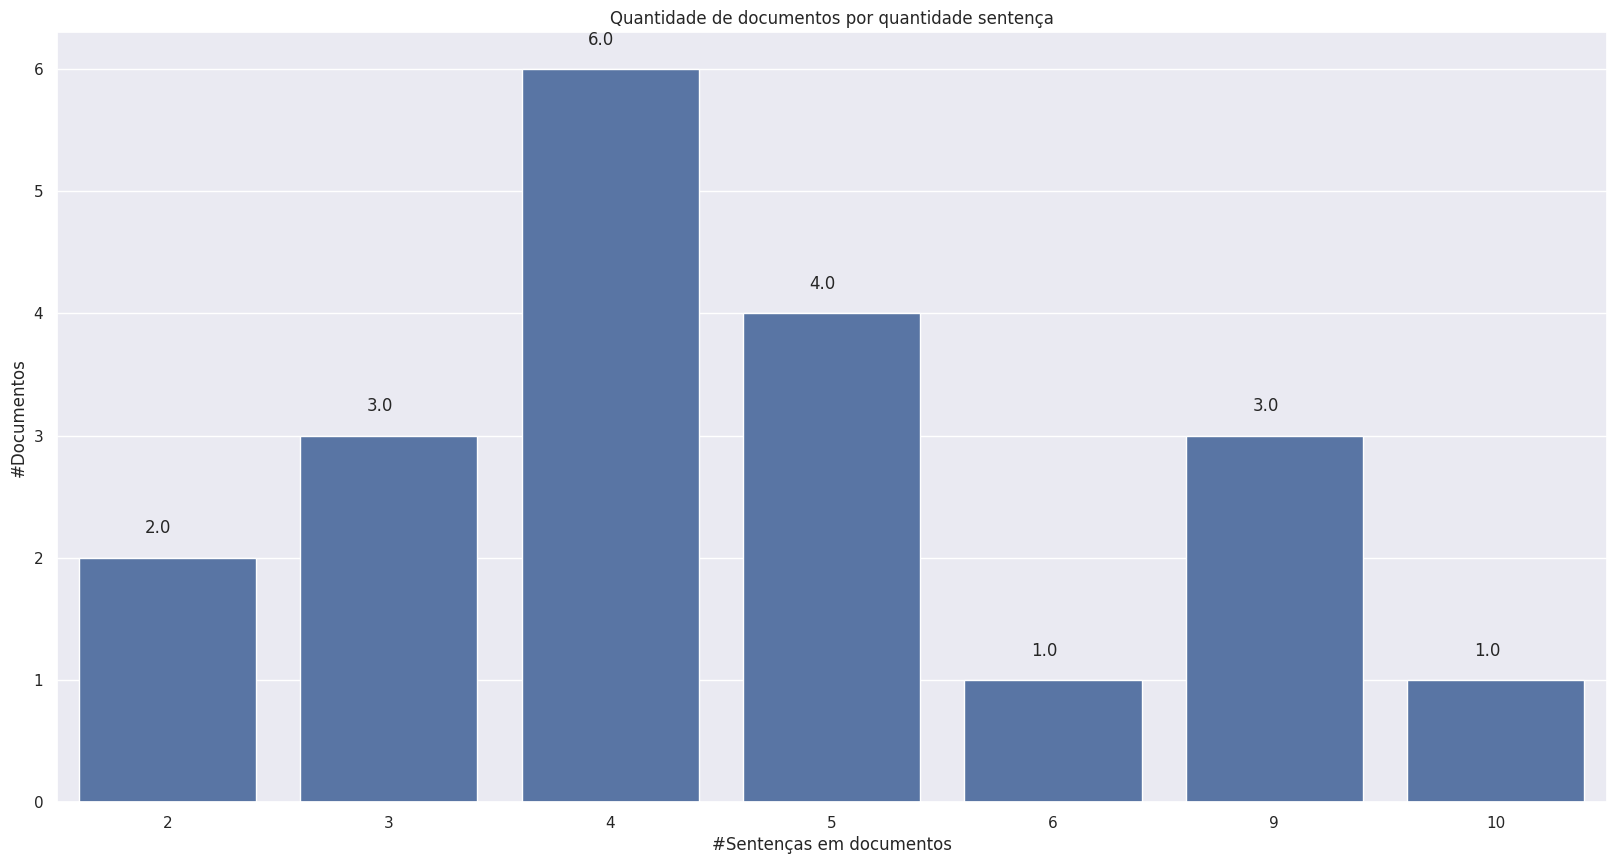

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesentencas"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.2))

plt.title("Quantidade de documentos por quantidade sentença")
plt.xlabel("#Sentenças em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.2 Gráfico Quantidade de documentos  por quantidade de palavras

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


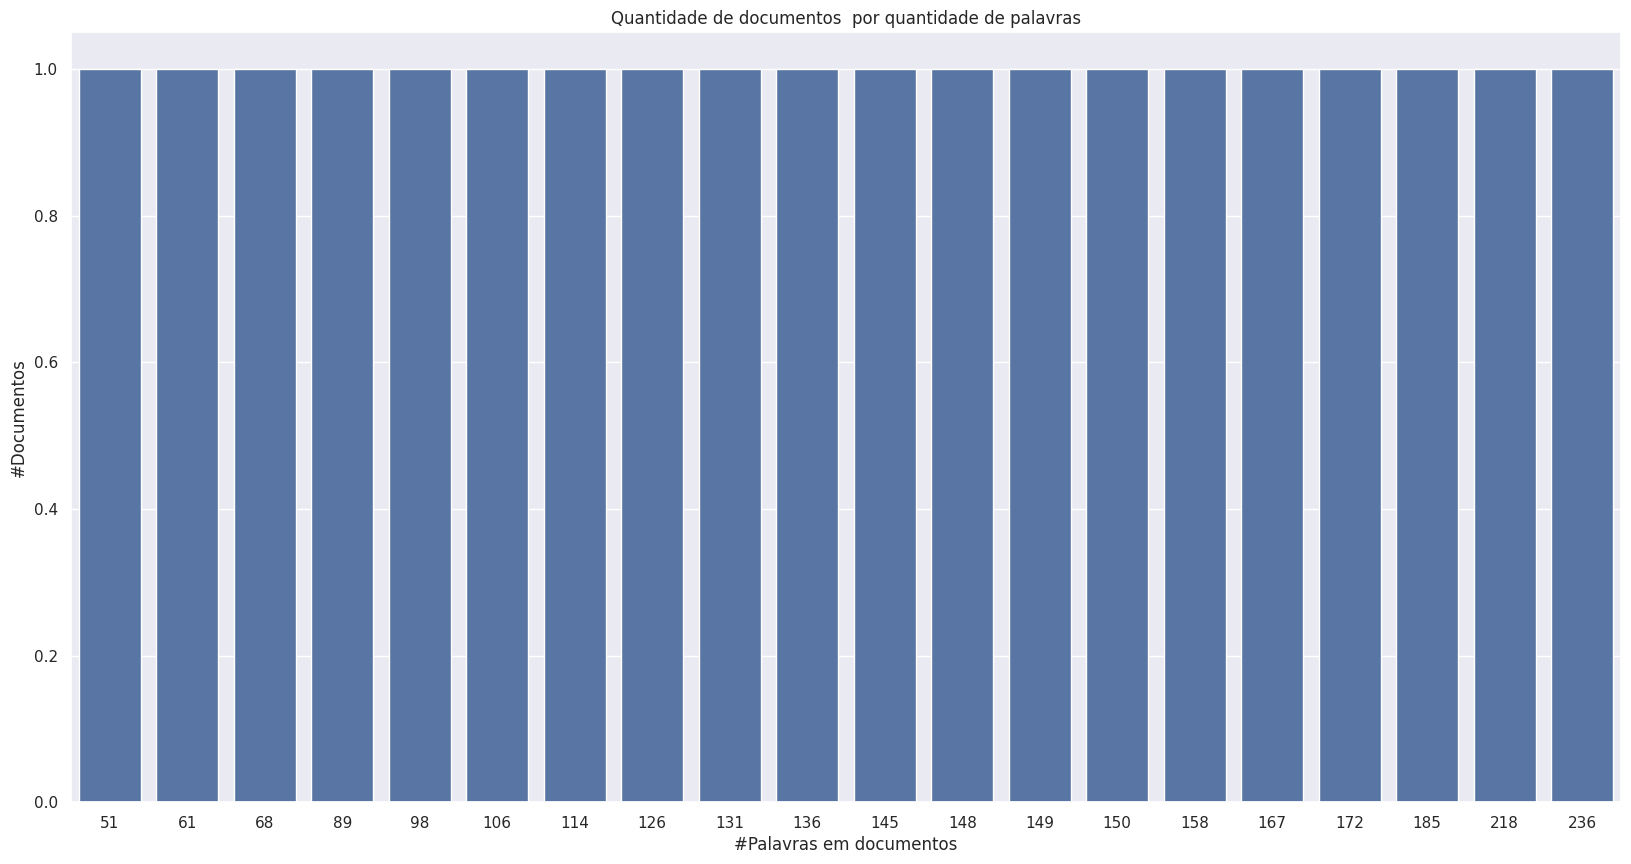

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de documentos  por quantidade de palavras")
plt.xlabel("#Palavras em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.3 Gráfico Quantidade de documentos  por quantidade de tokens

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


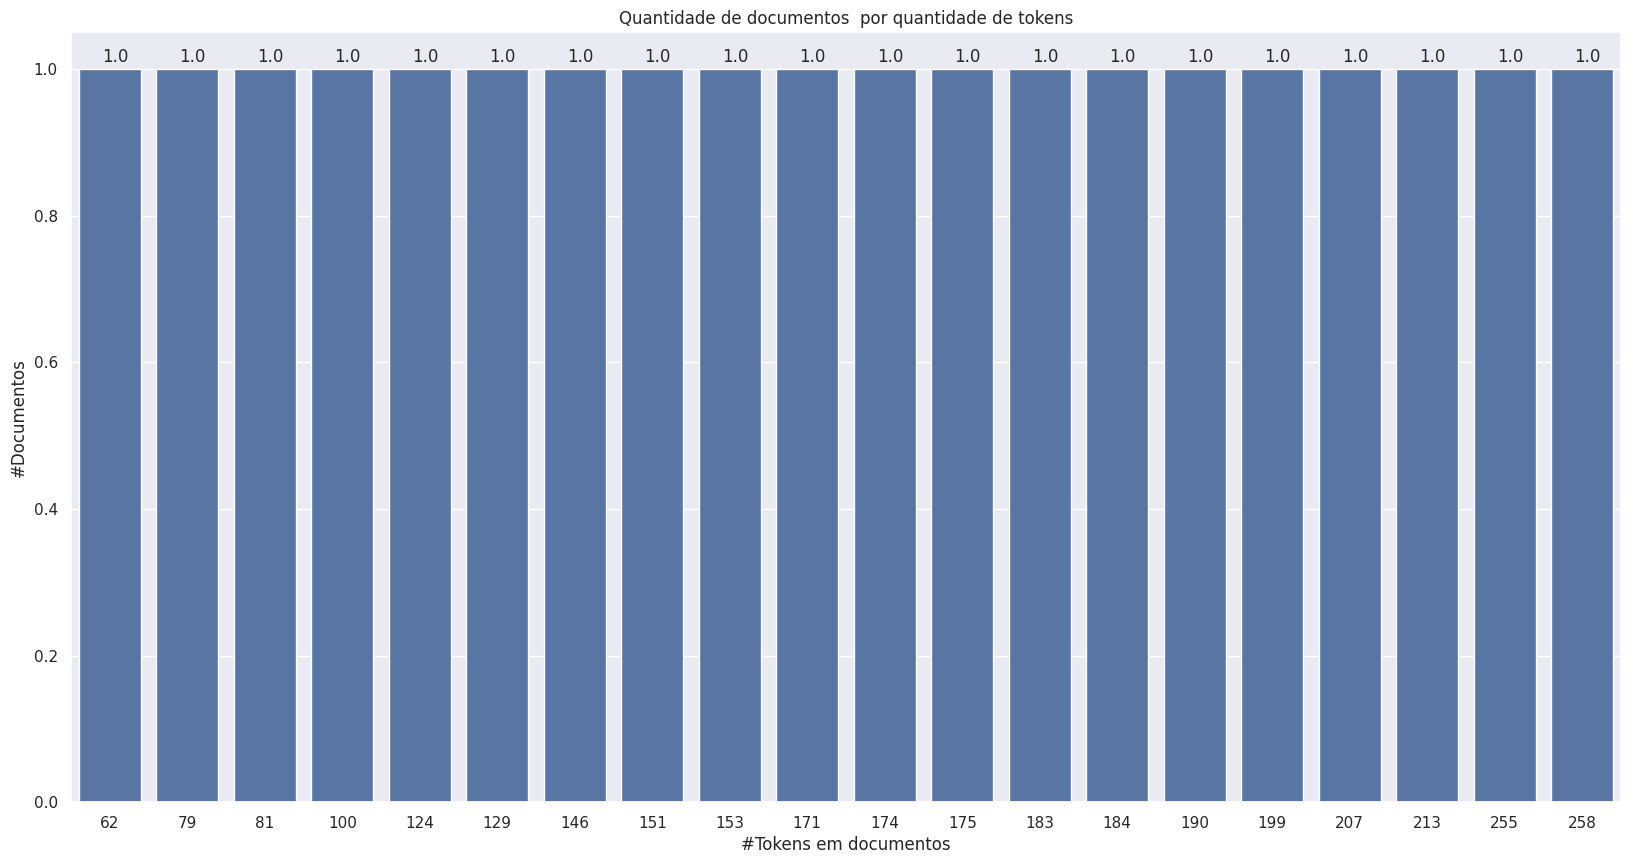

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de tokens")
plt.xlabel("#Tokens em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.4 Gráfico Quantidade de documentos  por quantidade de palavras desconsiderando as stopword

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


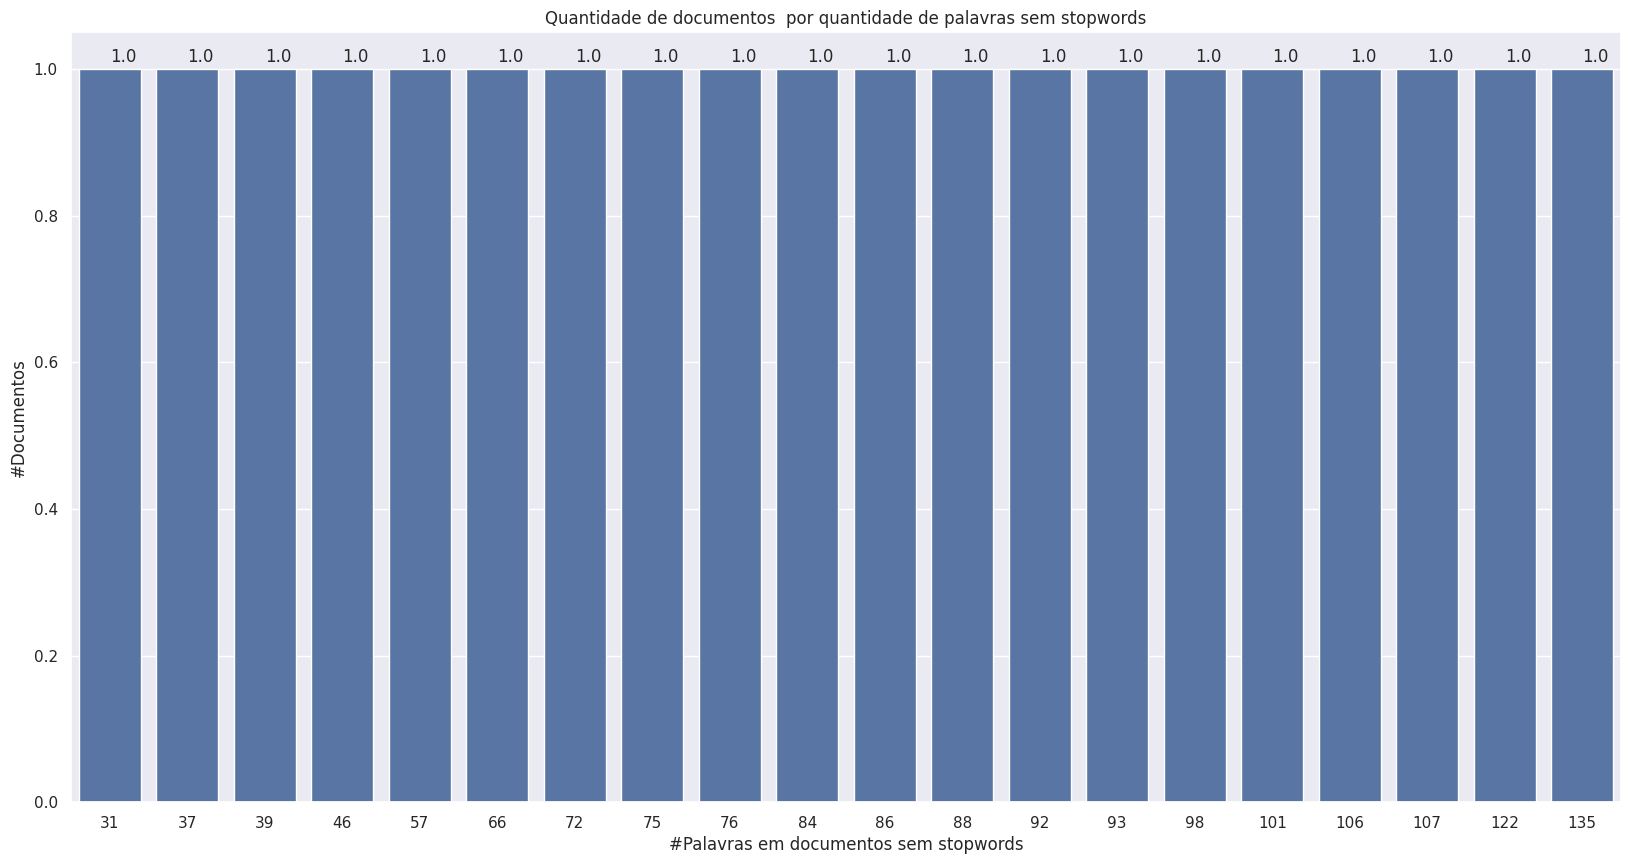

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de palavras sem stopwords")
plt.xlabel("#Palavras em documentos sem stopwords")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.5 Gráfico Quantidade de documentos  por quantidade de locuções verbais

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


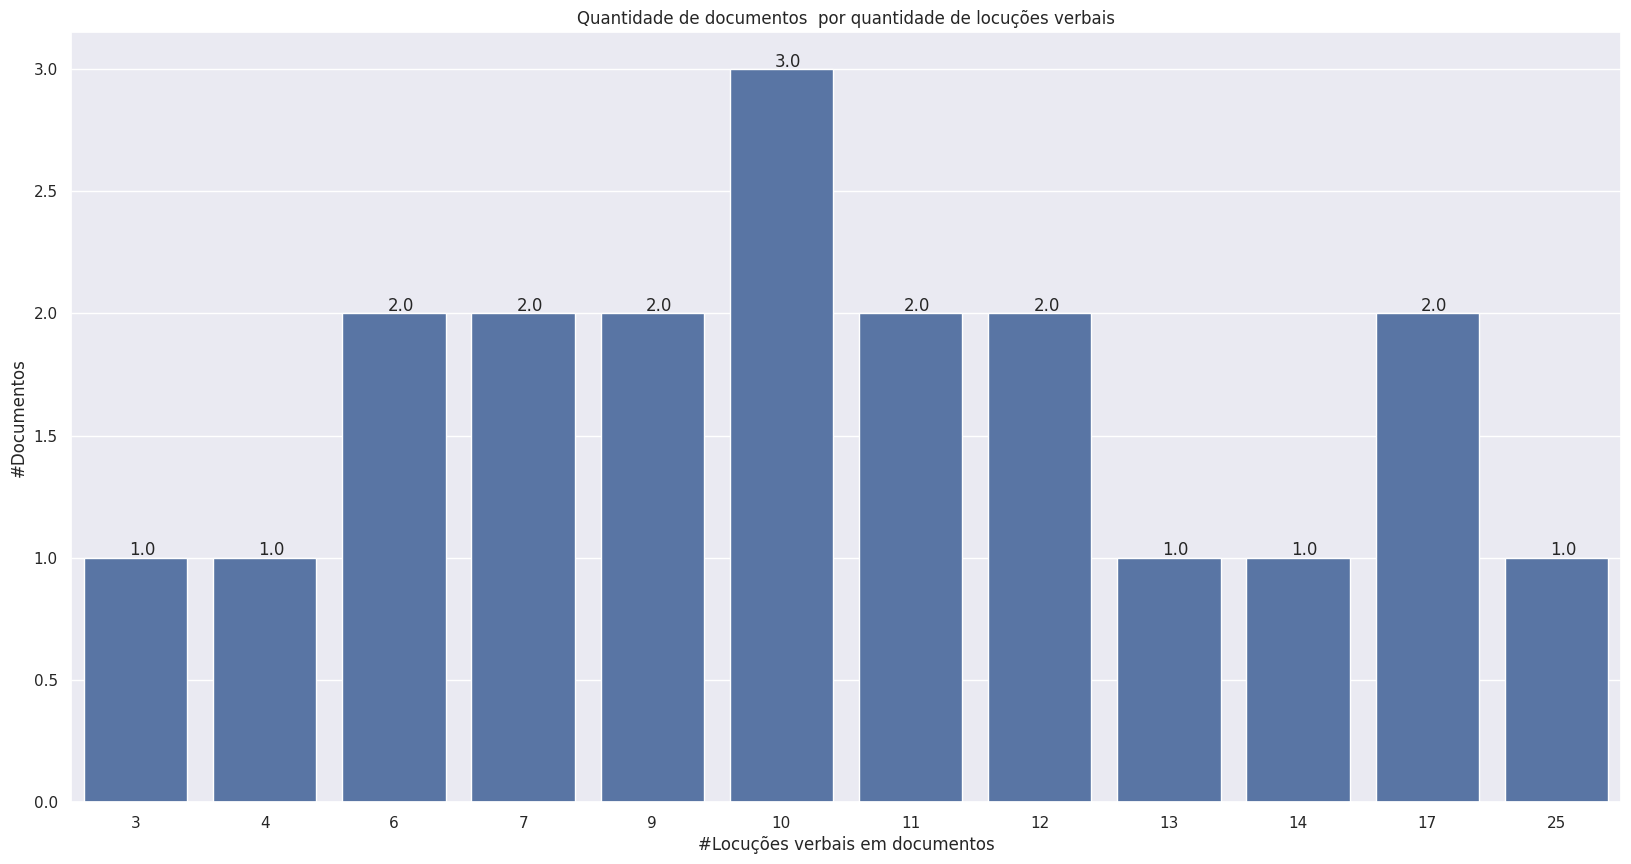

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.6 Gráfico Quantidade de documentos  por quantidade de verbos

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


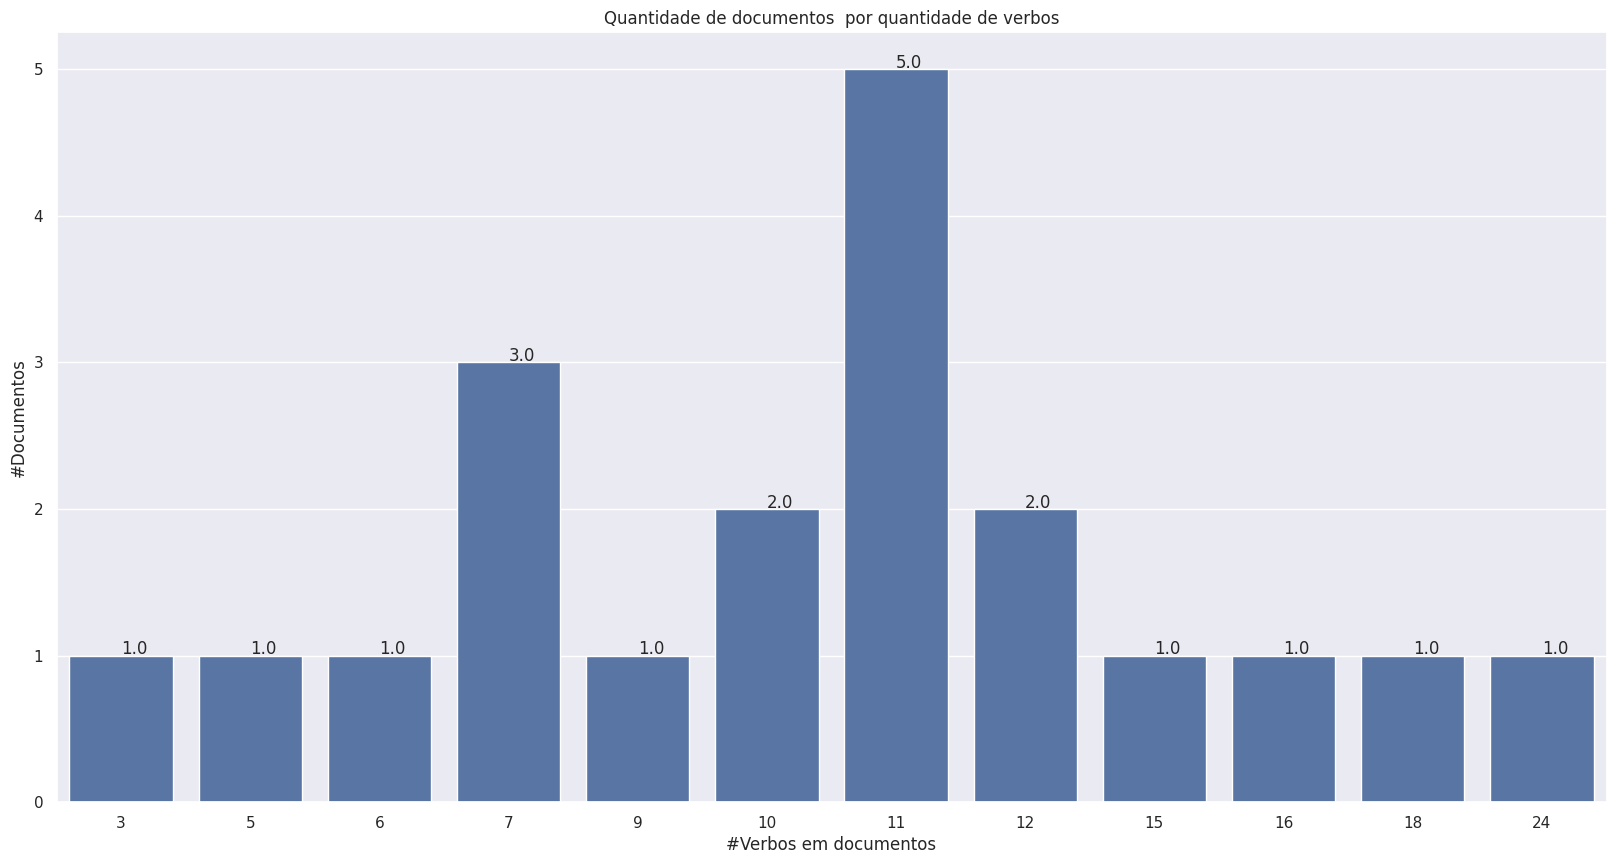

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos")
plt.xlabel("#Verbos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.7 Gráfico Quantidade de documentos  por quantidade de verbos(VERB) e verbos auxiliares(AUX)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


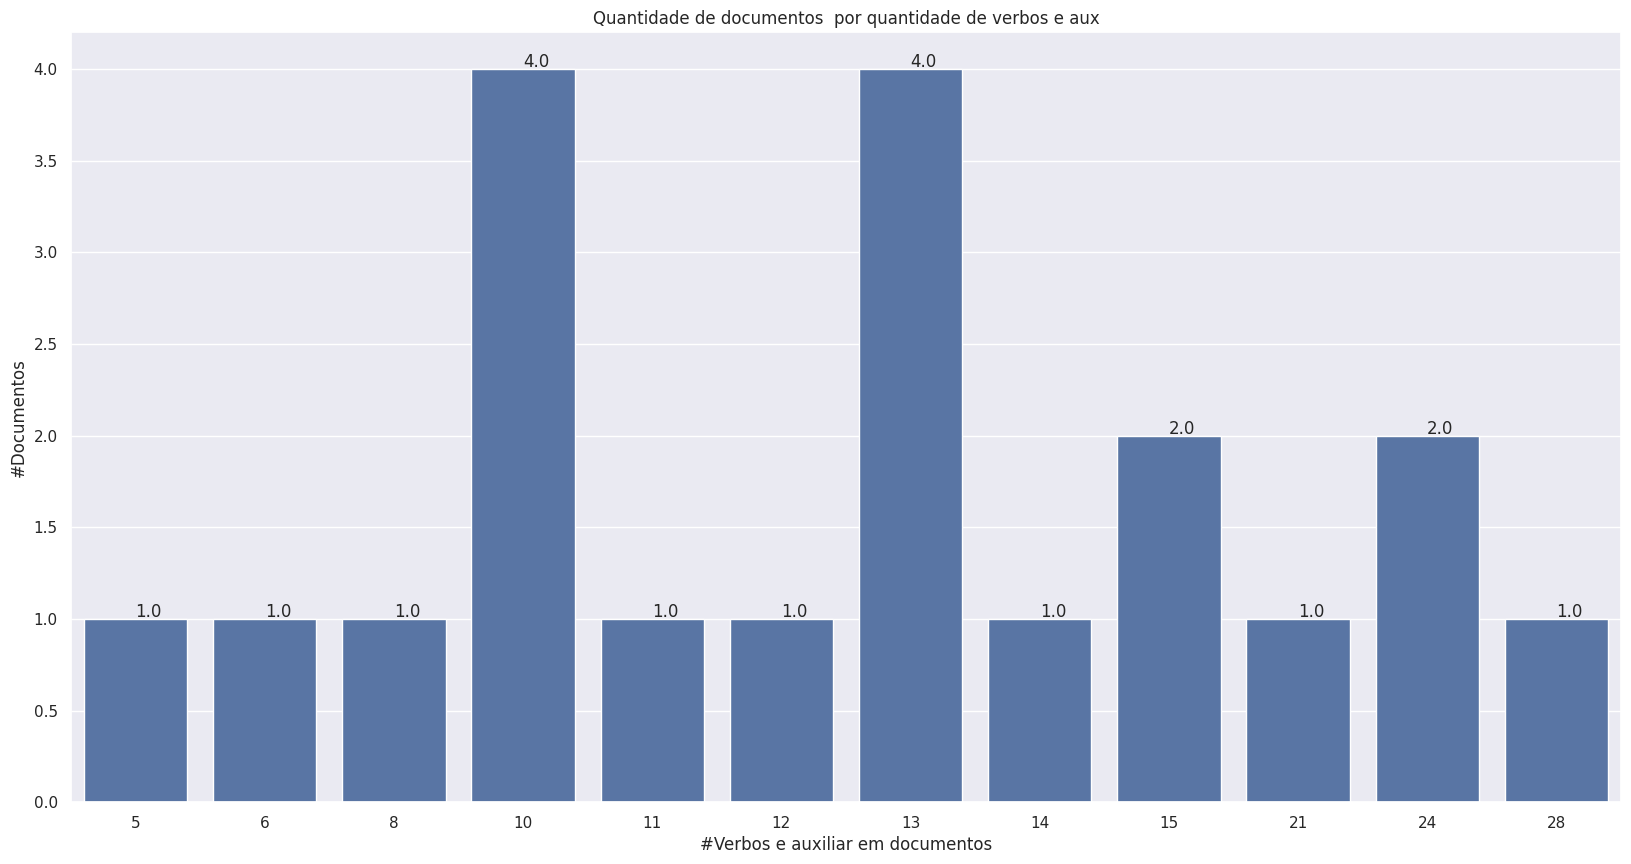

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.8 Gráfico Quantidade de documentos  por quantidade de substantivos(NOUN)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


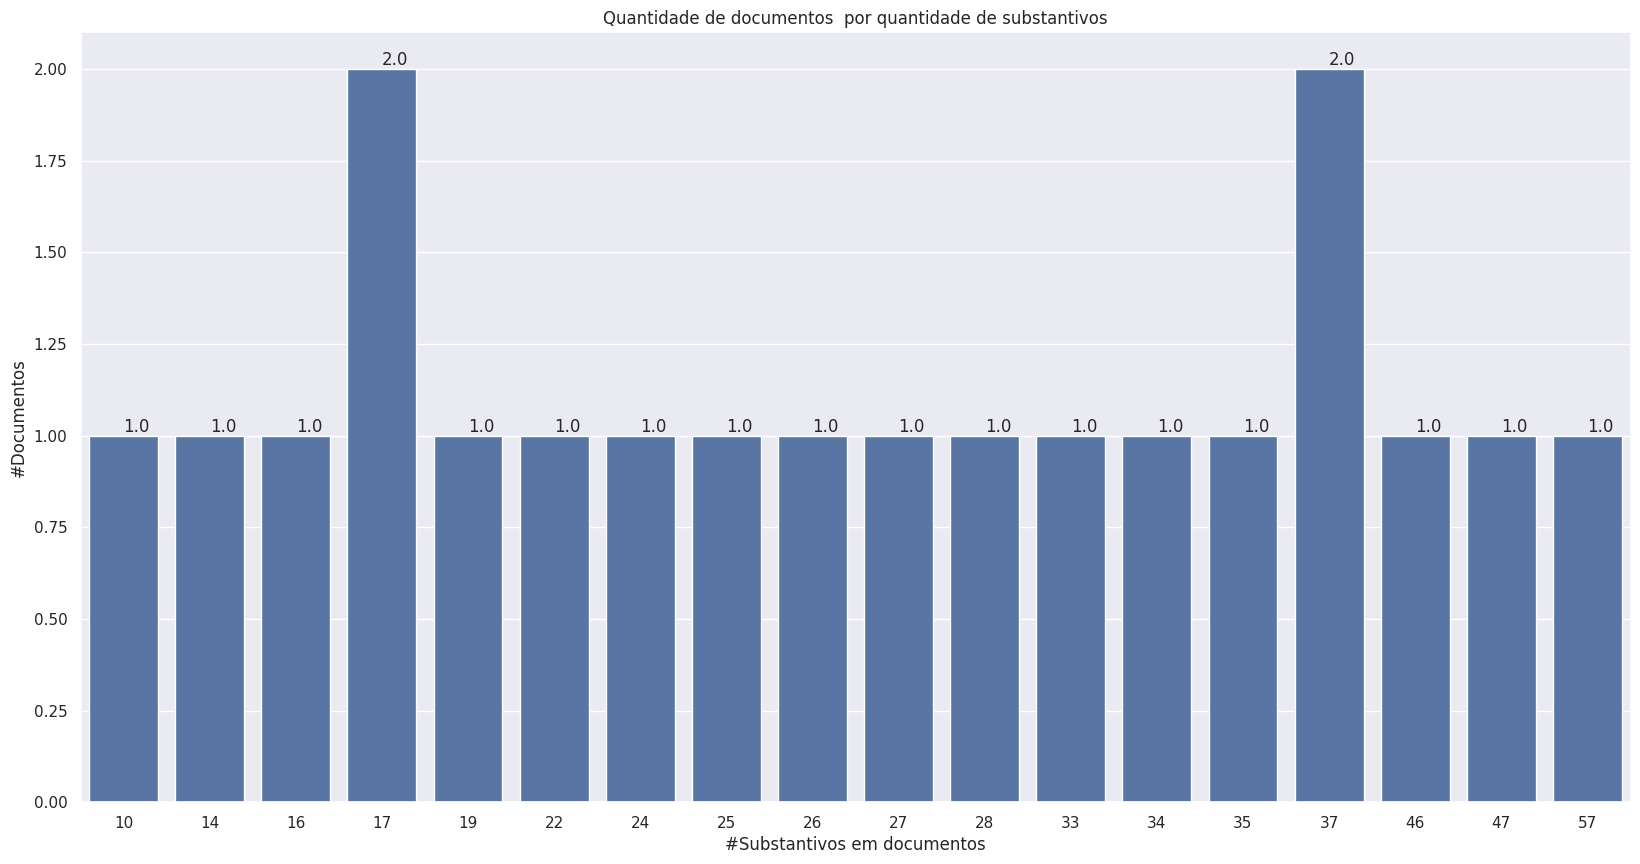

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de substantivos")
plt.xlabel("#Substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.9 Gráfico Quantidade de documentos  por quantidade de verbos(AUX) e substantivo(NOUN)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


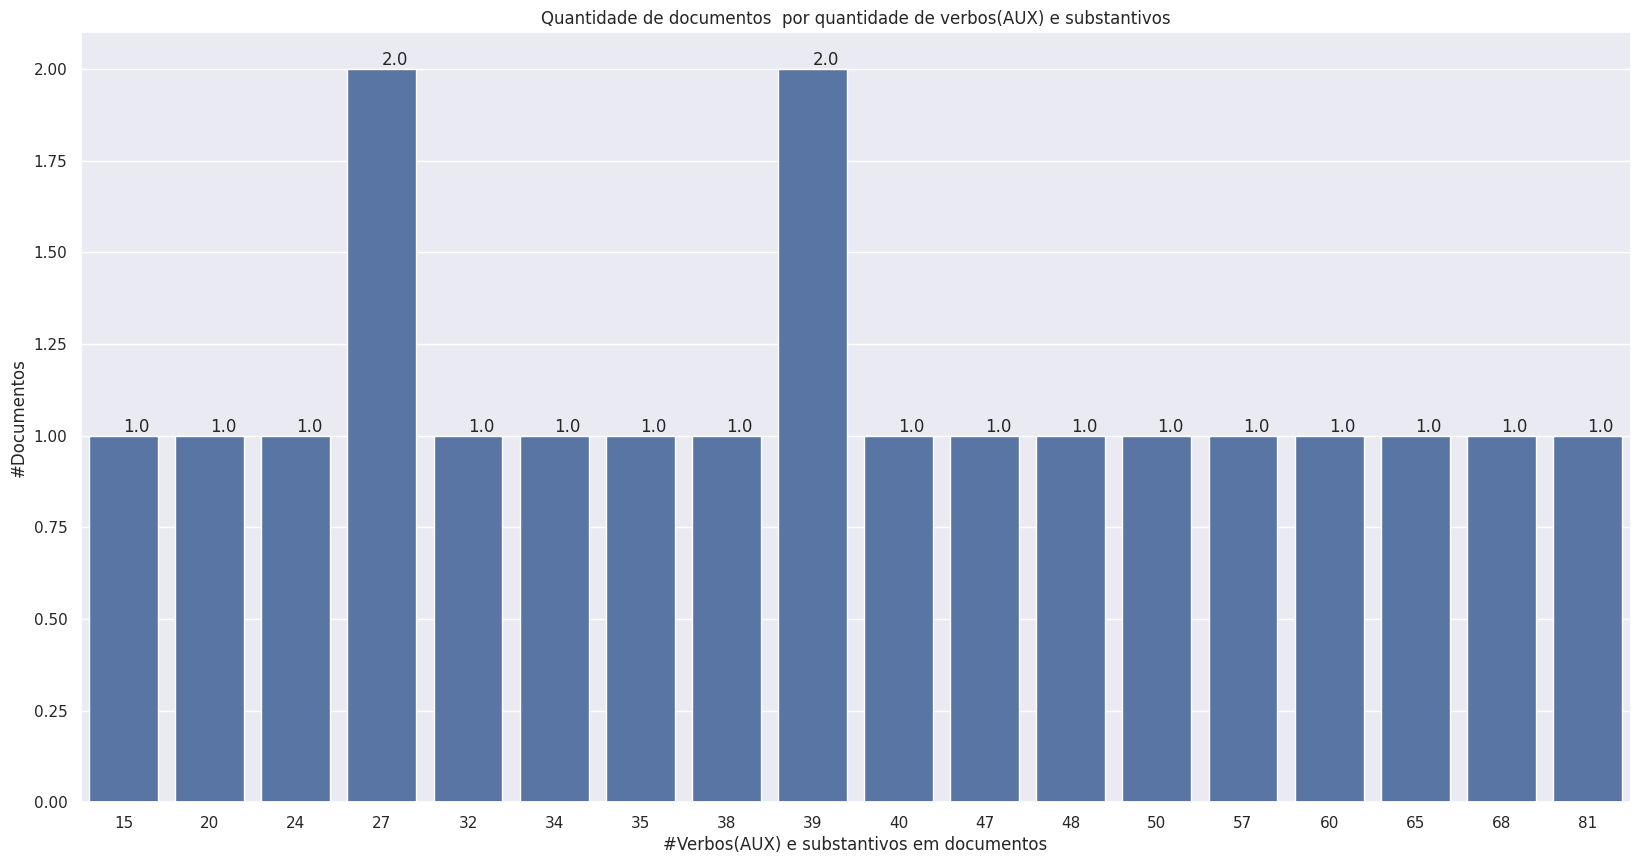

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos  por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.10 Gráfico Quantidade de documentos por quantidade de entidades reconhecidas

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


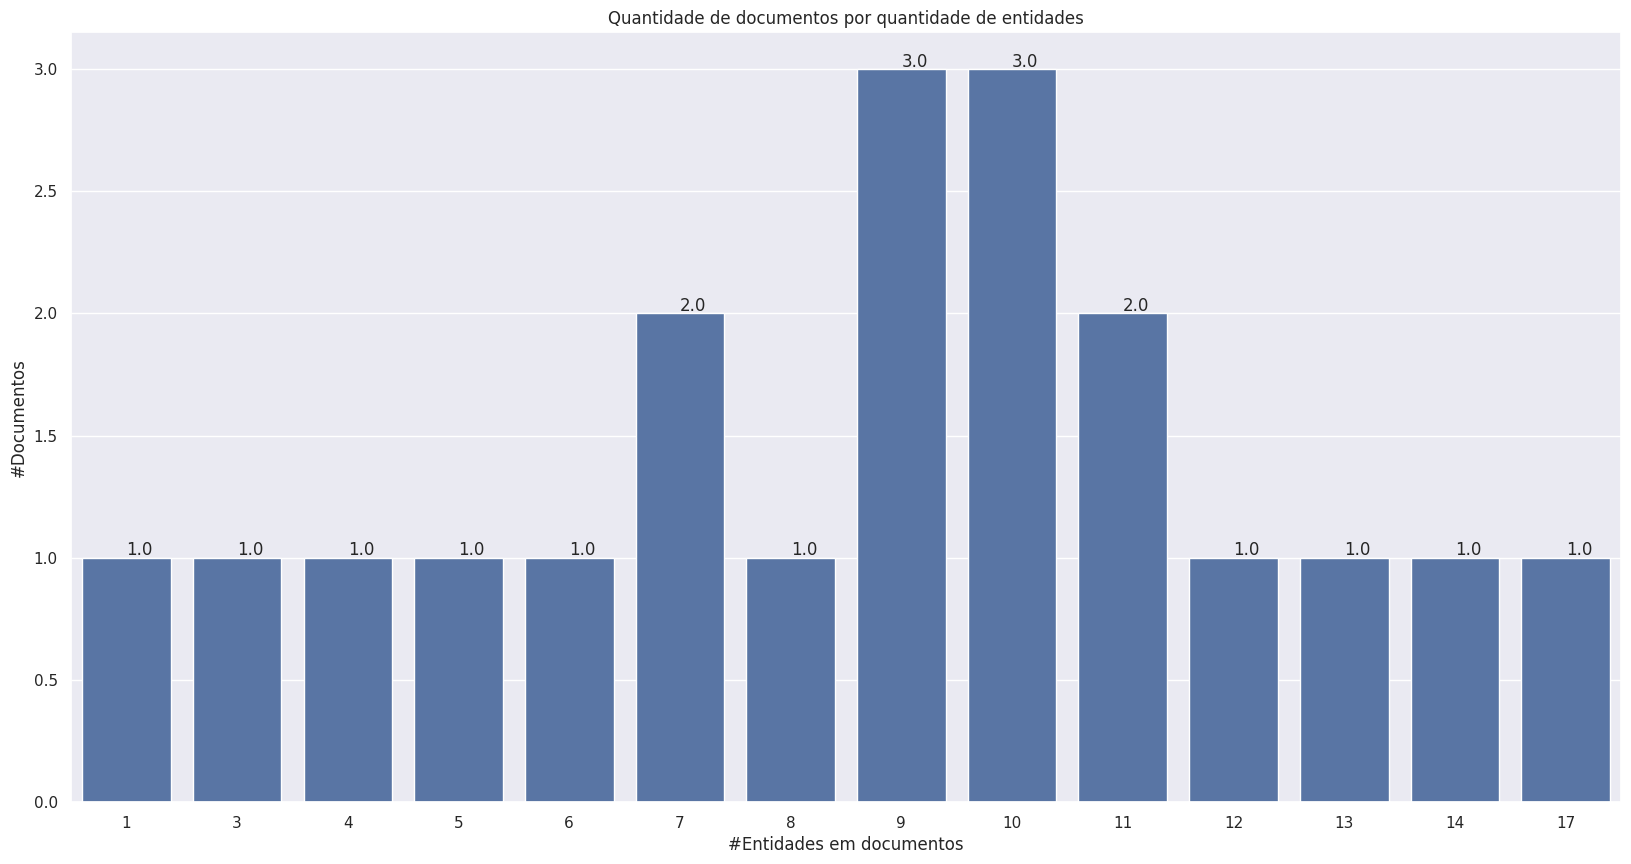

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdener"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.01))

plt.title("Quantidade de documentos por quantidade de entidades")
plt.xlabel("#Entidades em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.6.11 Gráfico da distribuição do comprimento dos documentos tokenizados

In [ ]:
# Recupera o comprimento dos documentos tokenizados
tamanhos_sentencas = [len(x) for x in documento_tokenizado]

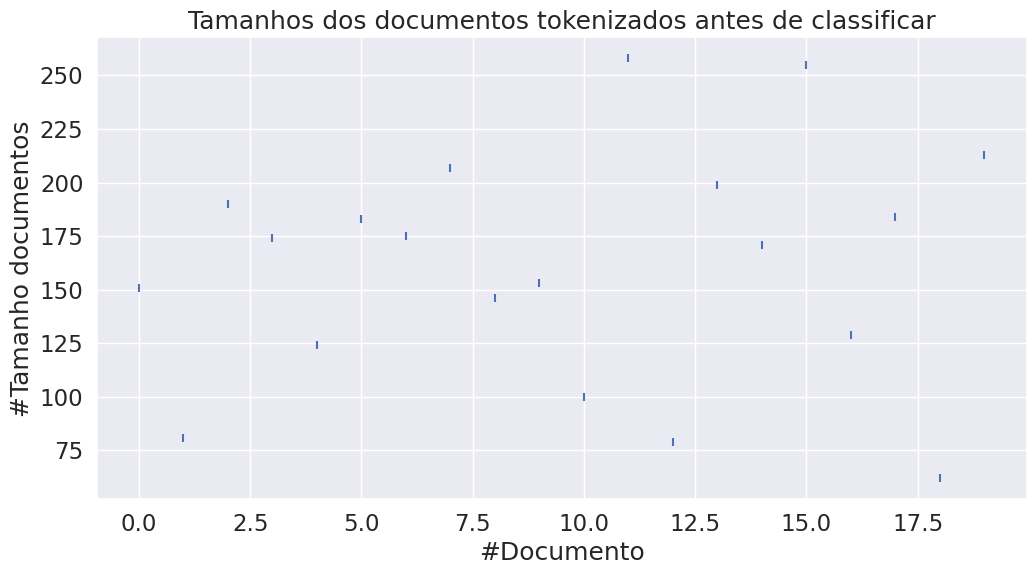

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Aumenta o tamanho da plotagem e o tamanho da fonte.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Adiciona os valores as colunas
plt.scatter(range(0, len(tamanhos_sentencas)), tamanhos_sentencas, marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados antes de classificar")

plt.show()

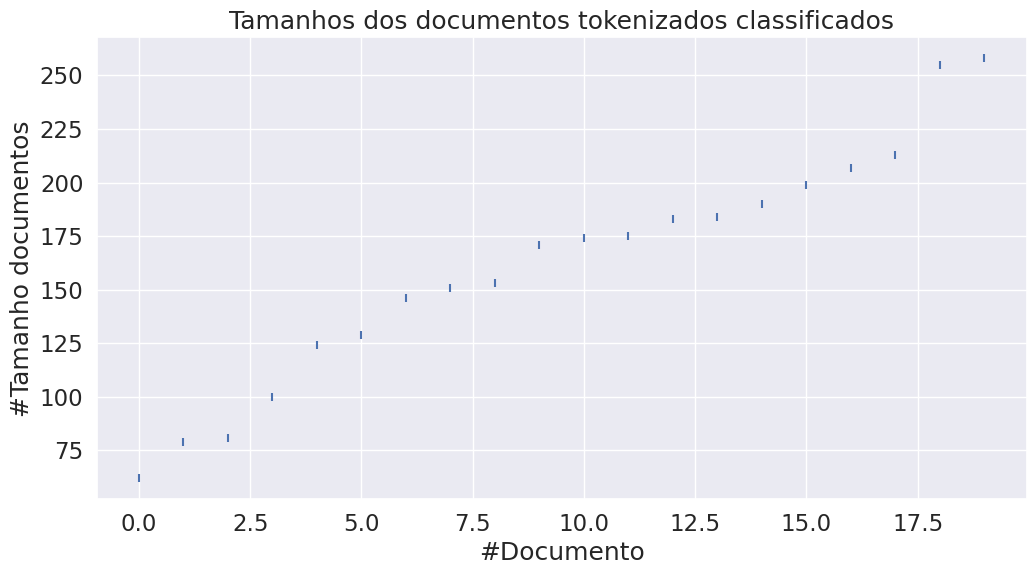

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(tamanhos_sentencas)), sorted(tamanhos_sentencas), marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados classificados")

plt.show()

### 5.2.7 Por sentença

#### 5.2.7.1 Gráfico Quantidade de sentenças de documentos  por quantidade de palavras

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


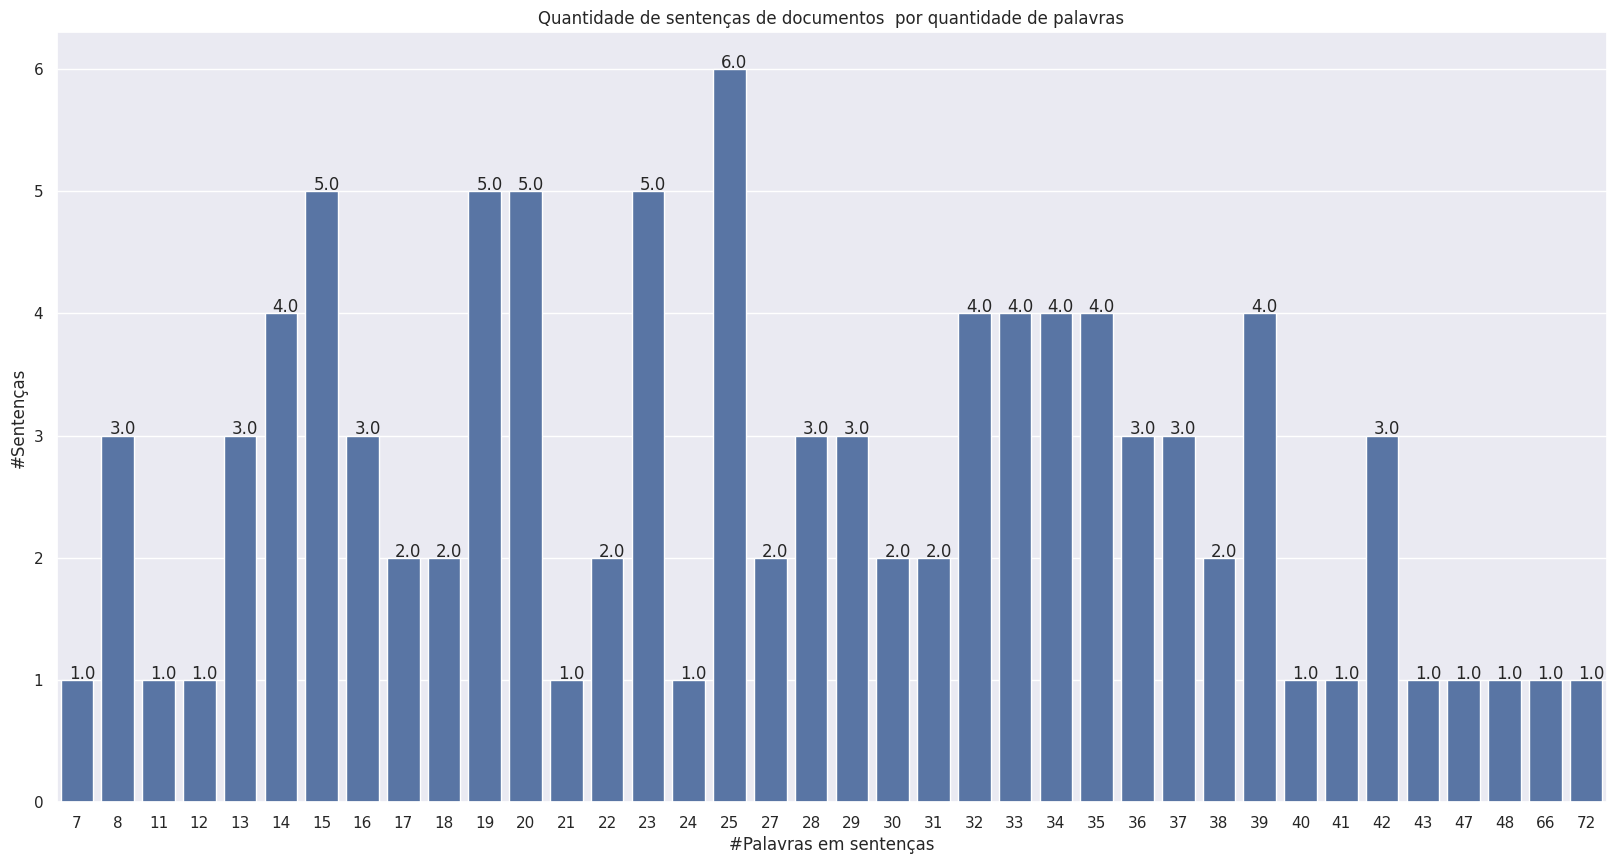

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos  por quantidade de palavras")
plt.xlabel("#Palavras em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.2 Gráfico Quantidade de sentenças de documentos  por quantidade de tokens

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


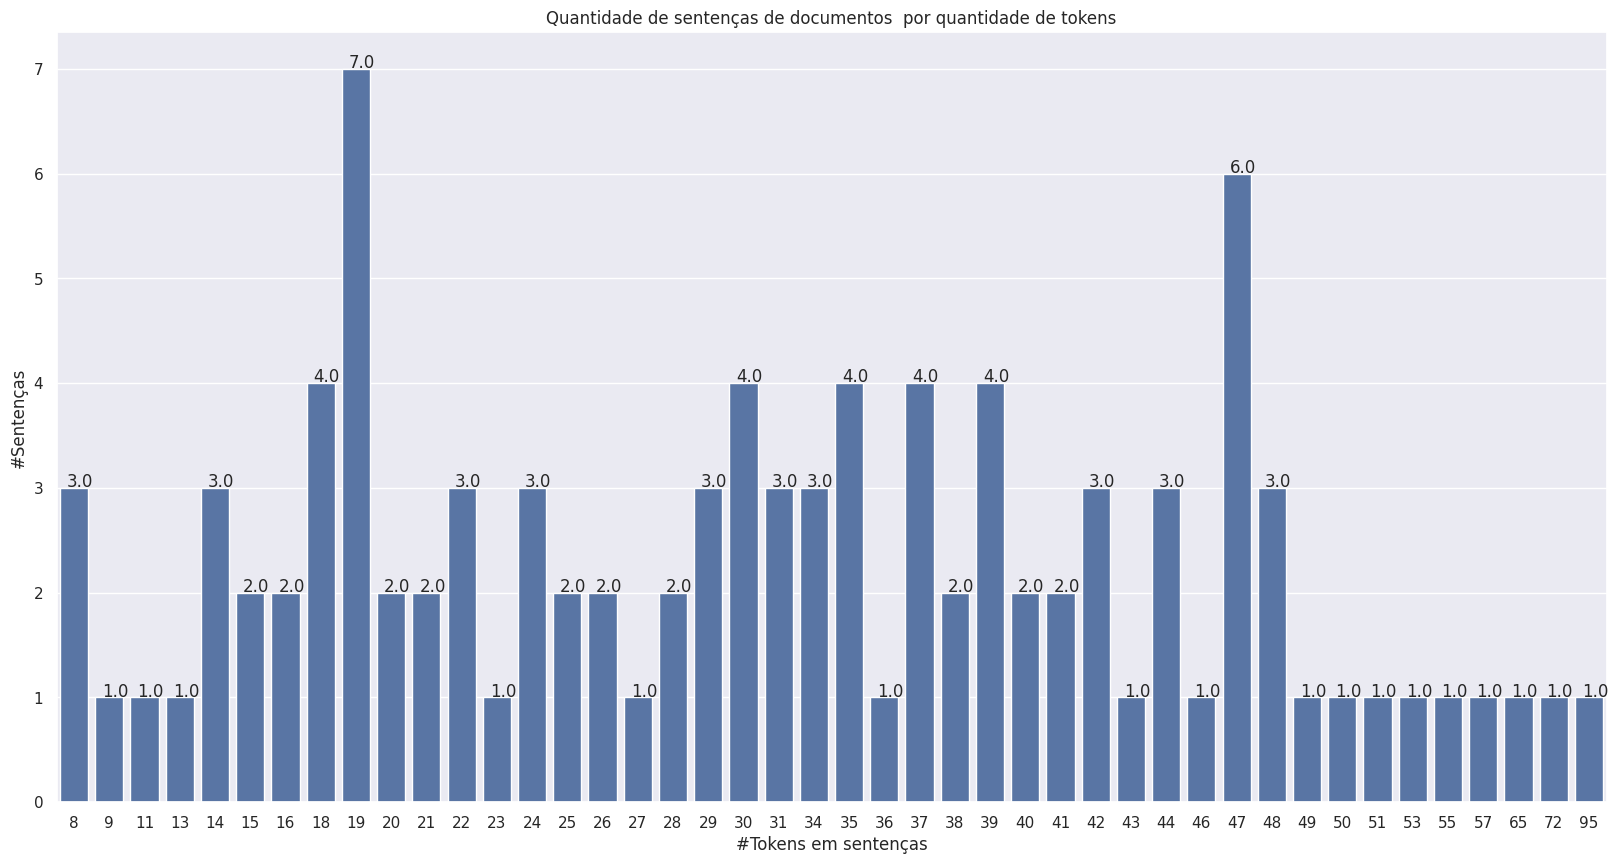

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos  por quantidade de tokens")
plt.xlabel("#Tokens em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.3 Gráfico Quantidade de sentenças de documentos  por quantidade de palavras desconsiderando stopwords

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


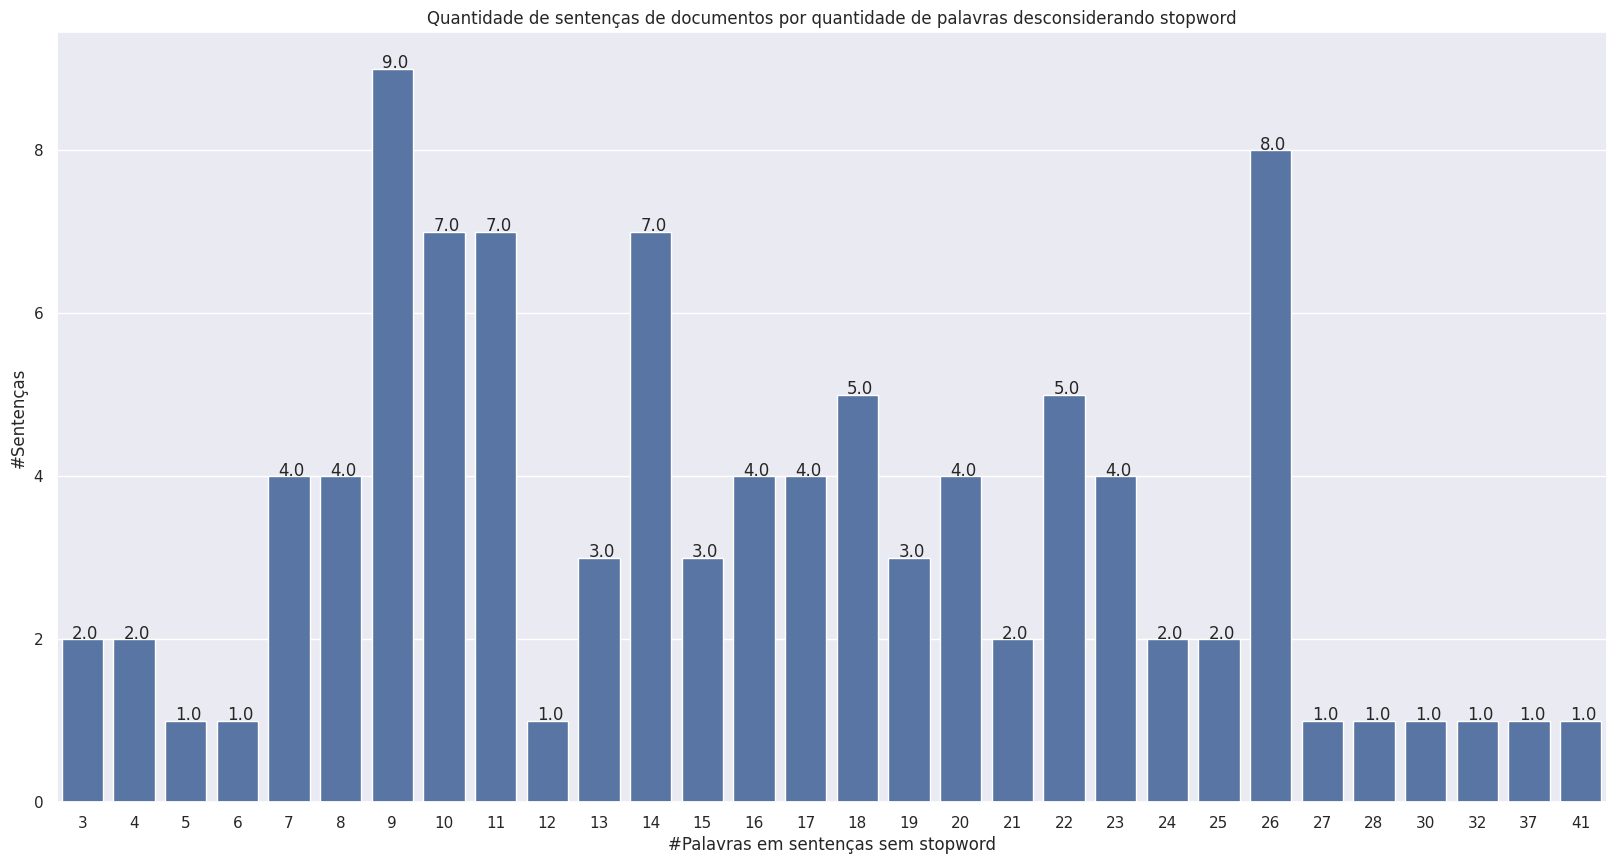

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+0.01))

plt.title("Quantidade de sentenças de documentos por quantidade de palavras desconsiderando stopword")
plt.xlabel("#Palavras em sentenças sem stopword")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.4 Gráfico Quantidade de sentenças de documentos  por quantidade de locuções verbais

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


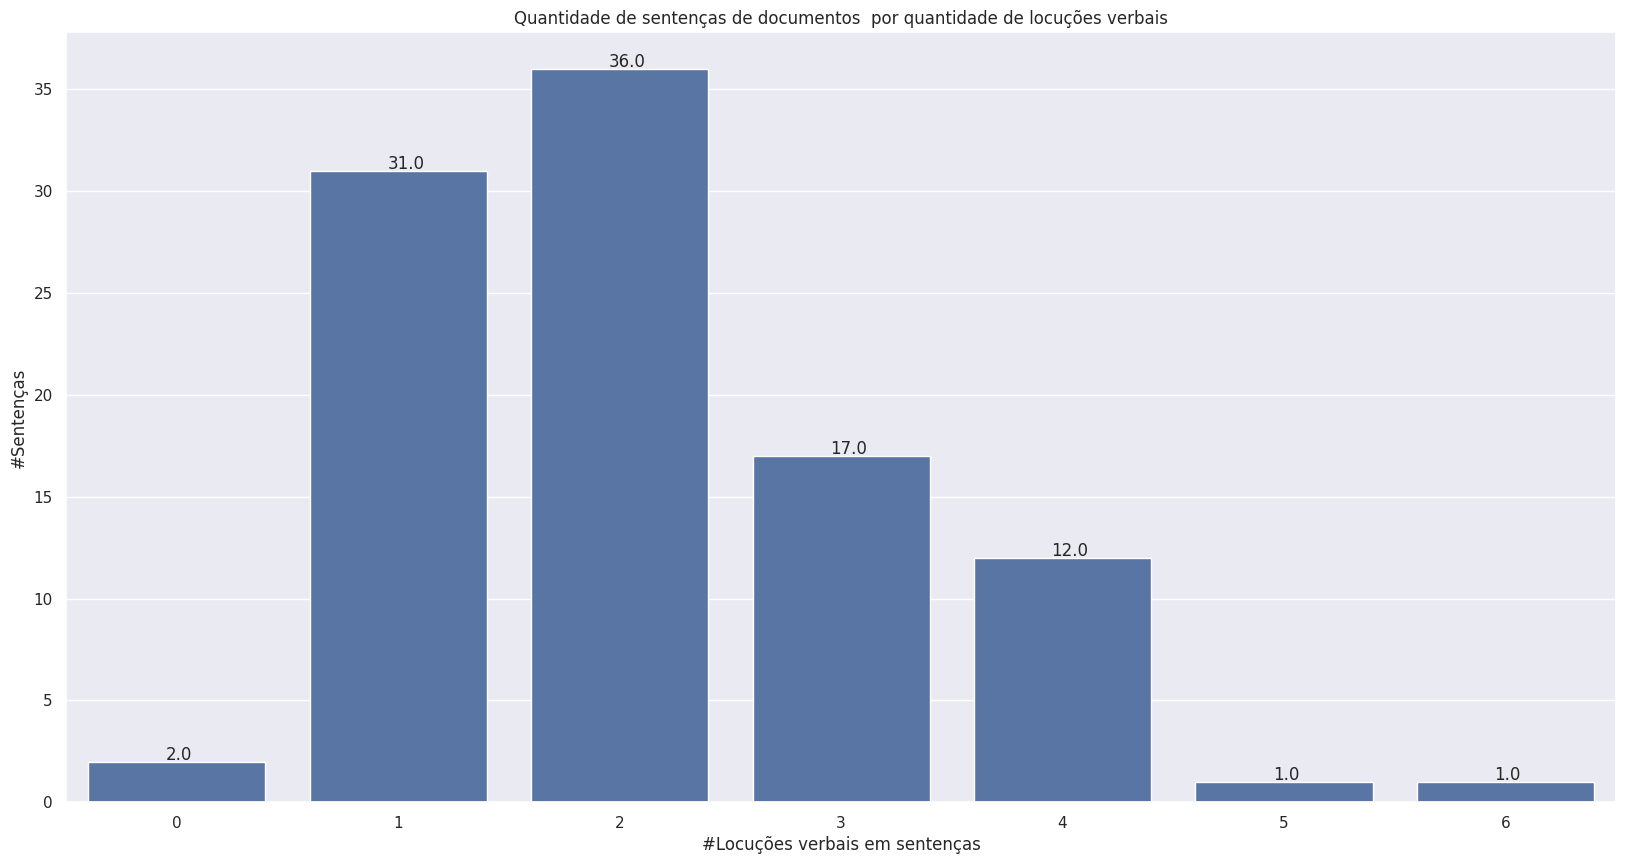

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.5 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos(VERB)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


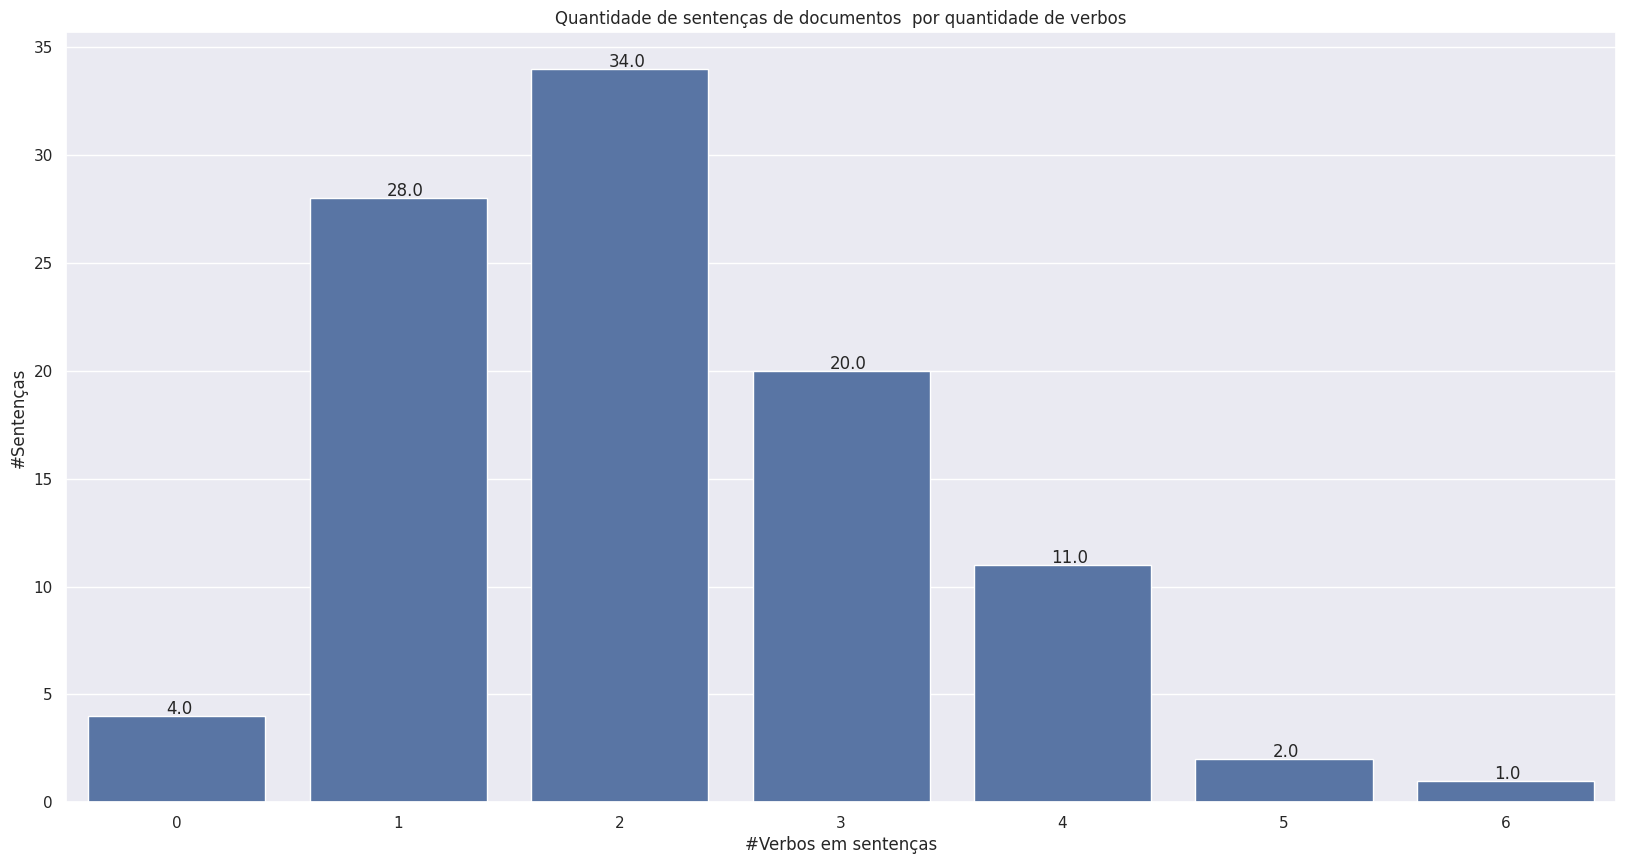

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.35, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de verbos")
plt.xlabel("#Verbos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.6 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos(VERB) e verbos auxiliares(AUX)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


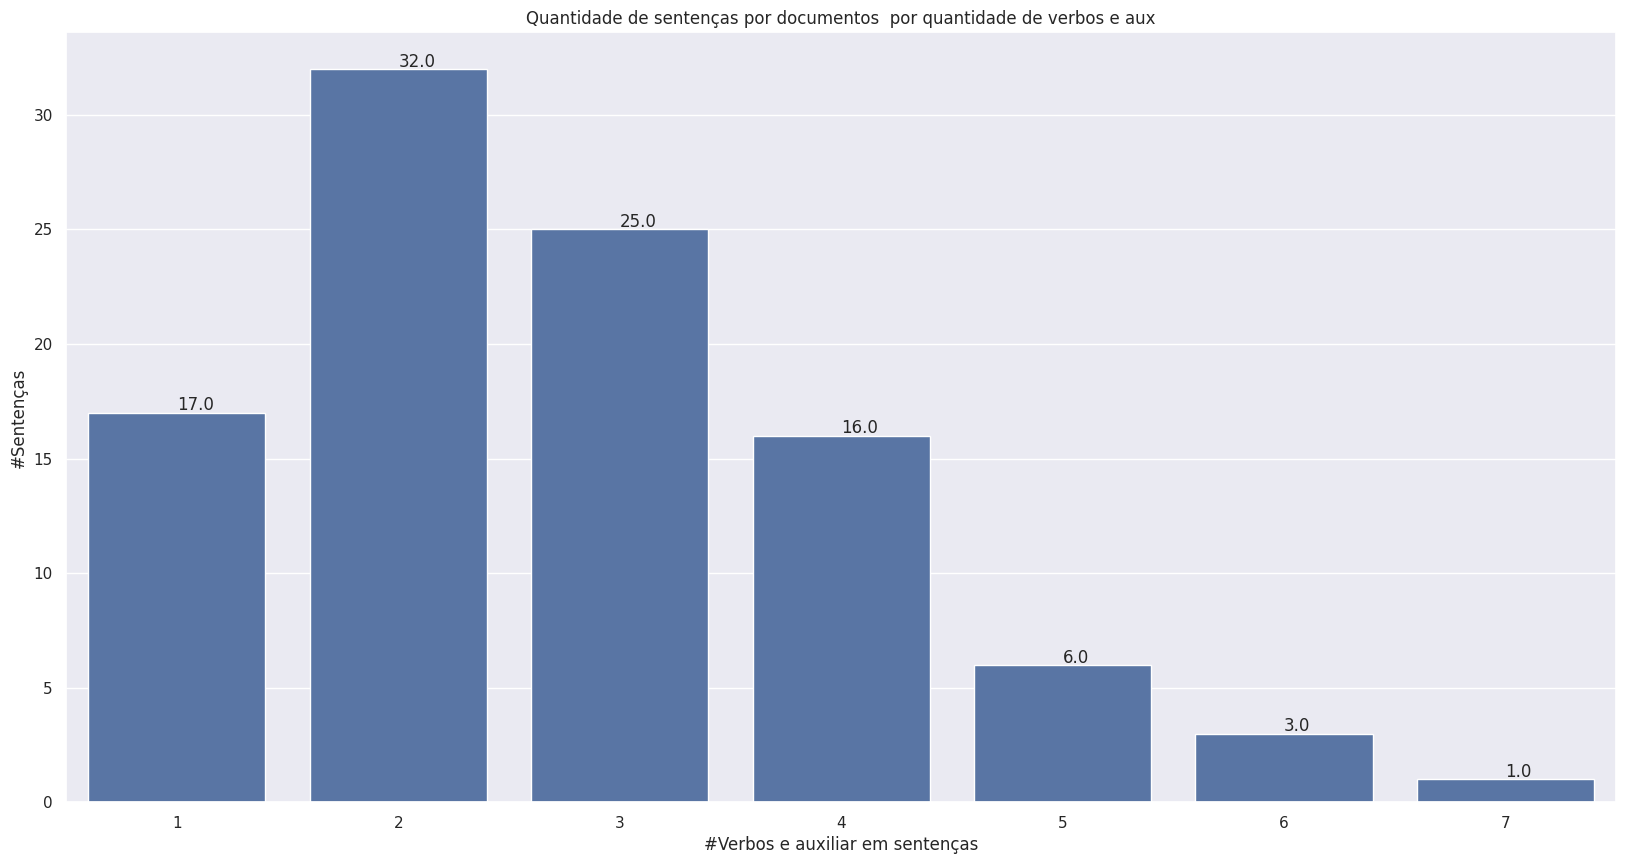

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças por documentos  por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.7 Gráfico Quantidade de sentenças de documentos  por quantidade de substantivos(NOUN)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


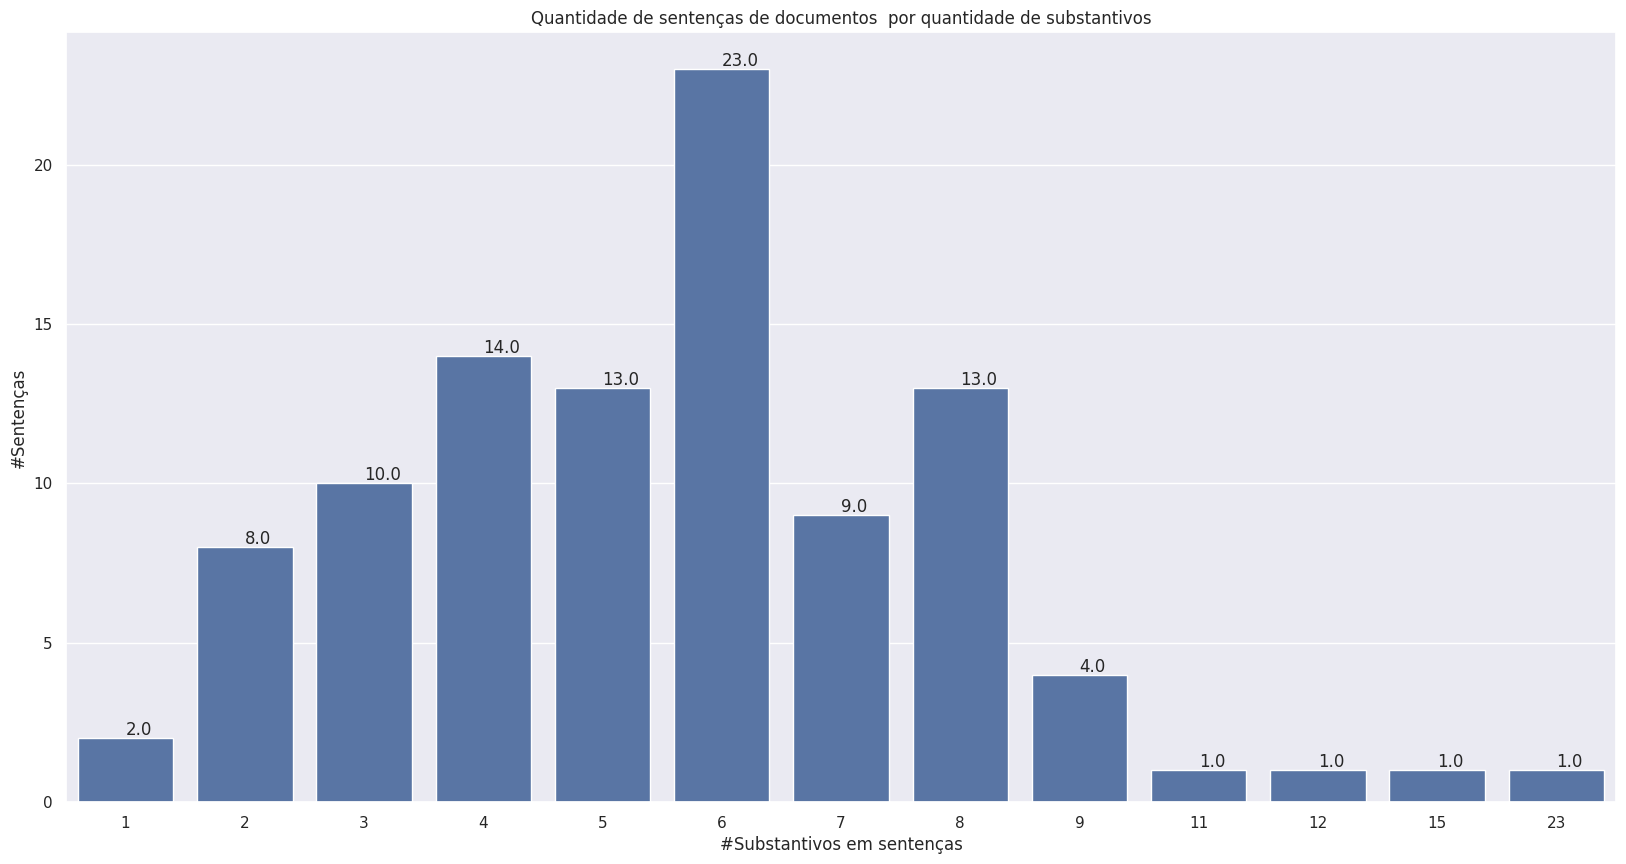

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de substantivos")
plt.xlabel("#Substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.8 Gráfico Quantidade de sentenças de documentos  por quantidade de verbos(AUX) e substantivo

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


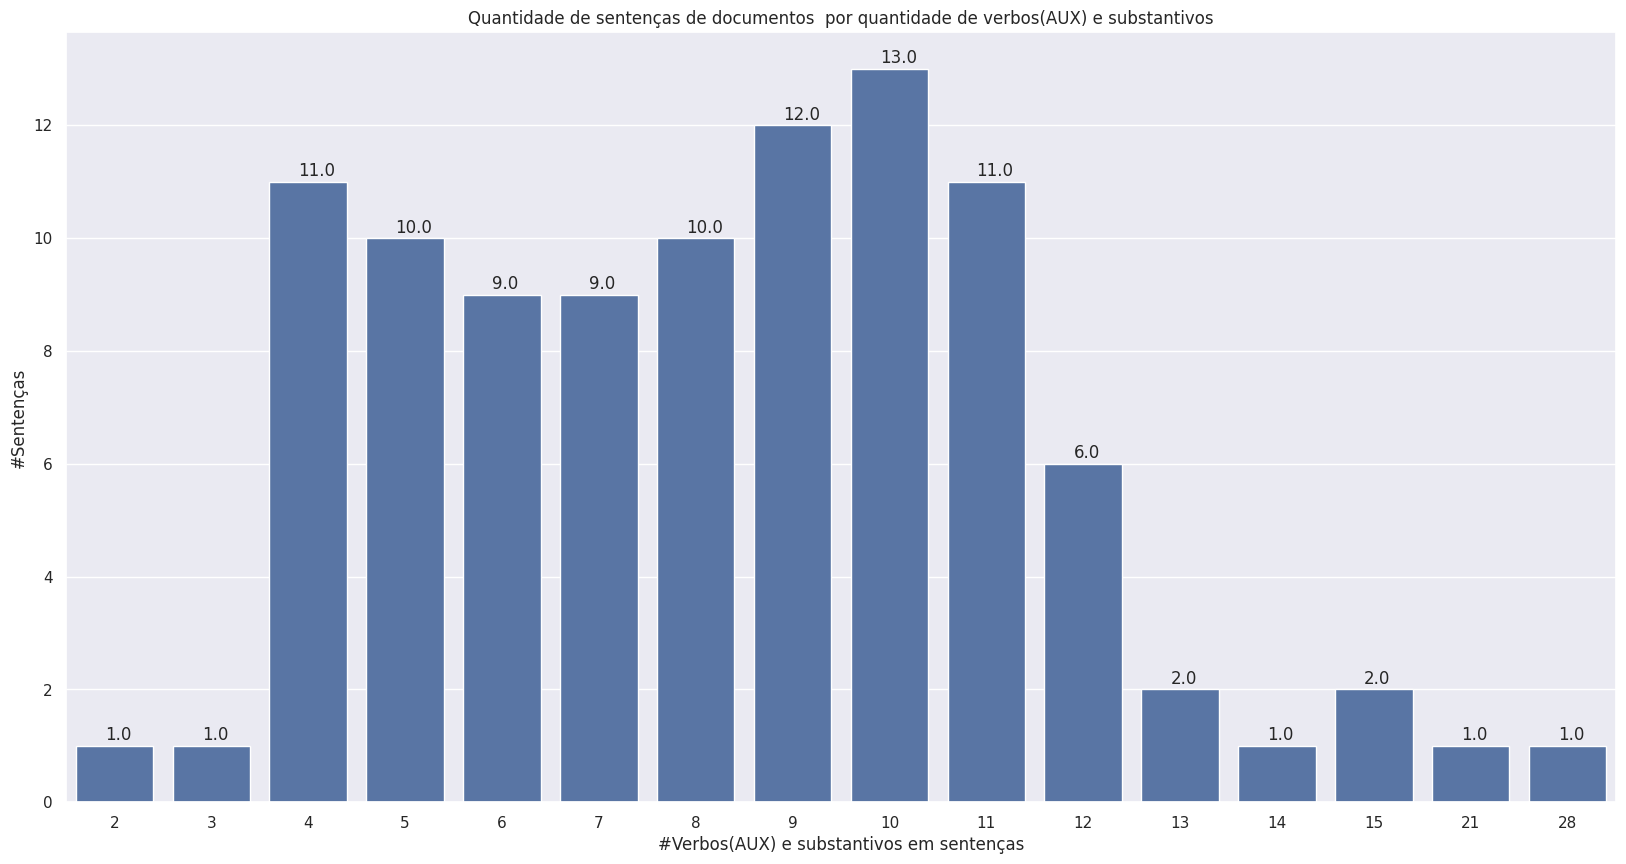

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos  por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.7.9 Gráfico Quantidade de sentenças de documentos  por quantidade de entidades

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


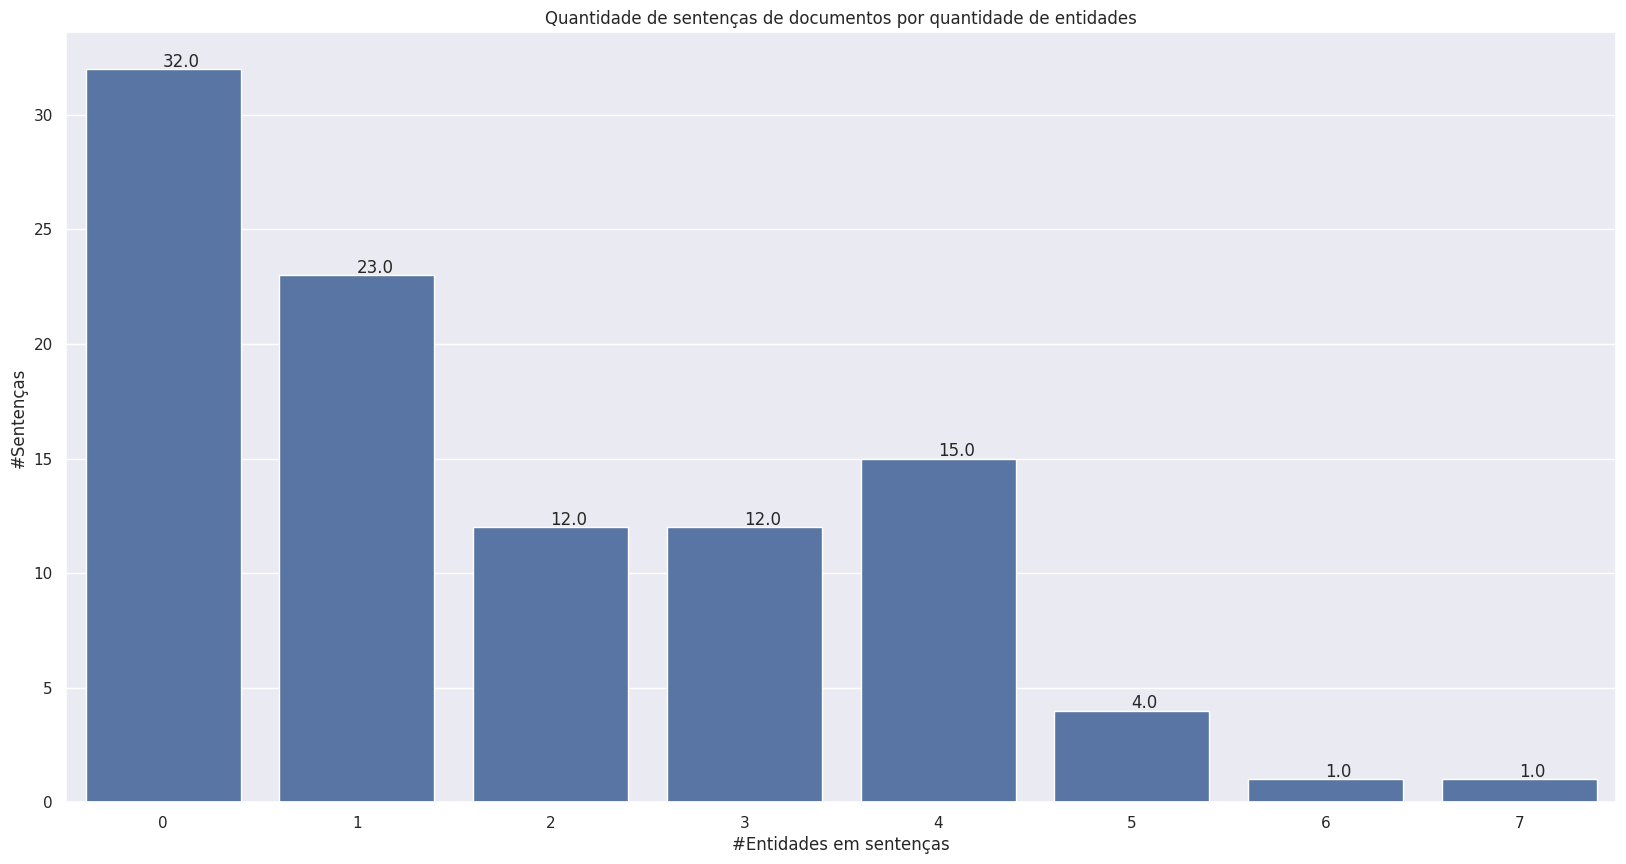

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdener"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos por quantidade de entidades")
plt.xlabel("#Entidades em sentenças")
plt.ylabel("#Sentenças")

plt.show()

# 6 Finalização

## 6.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:02:48 (h:mm:ss)
